<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Valeo/Valeo_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "FR.PA"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02   3.54   3.78   3.54   3.67       1.91  1736271
2009-01-05   3.68   3.77   3.55   3.73       1.95  2843871
2009-01-06   3.72   4.07   3.72   4.05       2.12  3290877
2009-01-07   4.01   4.08   3.89   3.94       2.06  2534205
2009-01-08   3.83   3.88   3.77   3.81       1.99  1805292
...           ...    ...    ...    ...        ...      ...
2018-12-21  23.25  24.98  23.20  24.98      23.76  4100101
2018-12-24  24.51  25.18  24.50  25.18      23.95   628071
2018-12-27  25.40  25.71  23.67  23.87      22.70  1932681
2018-12-28  24.21  24.71  24.05  24.55      23.35   958471
2018-12-31  24.77  25.63  24.62  25.51      24.26   538967

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     28.608306    28.951064    28.225927    28.597101    23.168478  1.403209e+06
std      19.080772    19.231949    18.901820    19.070134    18.539994  9.440100e+05
min       2.740000     2.820000     2.670000     2.710000     1.420000  0.000000e+00
25%      11.670000    11.930000    11.430000    11.707500     6.837500  8.156250e+05
50%      25.420000    25.715000    25.005000    25.340000    19.380000  1.158916e+06
75%      45.807500    46.272500    45.250000    45.795000    37.290000  1.736102e+06
max      67.750000    67.800000    66.020000    67.120000    61.590000  1.494212e+07

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13   3.48   3.53   3.42   3.42       1.79  2542719   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   3.298390   3.194687   3.020988   3.351984   3.301861   3.288119       3.235       3.265   3.081408   3.24500   3.403996   3.2170   3.296389   3.24500   3.393333   3.253627                3.532054                  3.24500                2.957946                3.675581                  3.24500                2.814419                3.819108                  3.24500                2.670892                3.962635                  3.24500                2.527365   3.301861   3.380126   3.249094                3.588915                 3.301861                3.014807                3.732442                 3.301861                2.871280                3.875969                 3.301861                2.727753                4.019496                 3.301861   
2009-03-16   3.47   3.60   3.40   3.50       1.83  1432230   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   3.308471   3.197531   3.031168   3.419122   3.345892   3.302368       3.275       3.300   3.117295   3.27250   3.477549   3.2765   3.353056   3.27250   3.460000   3.257857                3.606079                  3.27250                2.938921                3.772869                  3.27250                2.772131                3.939658                  3.27250                2.605342                4.106448                  3.27250                2.438552   3.345892   3.468372   3.255473                3.679471                 3.345892                3.012312                3.846260                 3.345892                2.845523                4.013050                 3.345892                2.678733                4.179839                 3.345892   
2009-03-17   3.47   3.53   3.38   3.50       

Open         High          Low       Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.00000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     29.113994    29.461345    28.726125    29.10255    23.596736  1.374787e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    29.096158    29.046213     0.949804    29.102501    29.072579    29.035245    29.062061    29.021772    28.928411    29.072567    29.102303    29.072551    29.082511    29.072567    29.093457    29.012537               30.233323                29.072567               27.911811               30.813701                29.072567               27.331433               31.394079                29.072567               26.751055               31.974457                29.072567               26.170677    29.072579    29.095275    29.021656               30.233335                29.072579               27.911824               30.813713                29.072579               27.331446               31.394091   
std      18.927846    19.077007    18.751347    18.91723    18.471934  9.256165e+05     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238    18.950225    18.973573    34.629755    18.922594    18.920300    18.878632    18.923706    18.889832    18.941949    18.926867    18.919567    18.929923    18.921102    18.926867    18.912304    18.950026               19.468557                18.926867               18.413396               19.749264                18.926867               18.167995               20.036178                18.926867               17.930569               20.329038                18.926867               17.701436    18.920300    18.914189    18.946619               19.461645                18.920300               18.407205               19.742189                18.920300               18.162004               20.028949   
min       3.470000     3.530000     3.3800

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.000156  0.000000  0.000639  0.000000   0.000000  2542719   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000000  0.535078  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000305                0.000000                 0.000000                0.000682                0.000000                 0.000000                0.001062                0.000000                 0.000000                0.002352  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000040                0.000000                 0.000000                0.000418                0.000000                 0.000000                0.000799                0.000000                 0.000000   
2009-03-16  0.000000  0.001089  0.000319  0.001256   0.000669  1432230   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000162  0.000047  0.535155  0.001053  0.000702  0.000230    0.000633    0.000553  0.000555  0.000436  0.001156  0.000942  0.000898  0.000436  0.001053  0.000068                0.001147                 0.000436                0.000000                0.001461                 0.000436                0.000000                0.001756                 0.000436                0.000000                0.002028                 0.000436                0.000908  0.000702  0.001391  0.000103                0.001393                 0.000702                0.000000                0.001697                 0.000702                0.000000                0.001983                 0.000702                0.000000                0.002253                 0.000702   
2009-03-17  0.000000  0.000000  0.000000  0.001256  

140191

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         6 hours 12 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_5y448z
H2O cluster total nodes:    1
H2O cluster free memory:    8.47 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_192357_mod...  0.557264   4.569371              0.500000  0.654938  0.428944
1              DeepLearning_1_AutoML_20190827_192357  0.536510   7.018229              0.496212  0.650844  0.423598
2  DeepLearning_grid_1_AutoML_20190827_192357_mod...  0.506748   3.495587              0.500000  0.546363  0.298513
3  DeepLearning_grid_1_AutoML_20190827_192357_mod...  0.500000   0.699663              0.500000  0.503240  0.253251
4  DeepLearning_grid_1_AutoML_20190827_192357_mod...  0.500000   0.699336              0.500000  0.503079  0.253088
5  DeepLearning_grid_1_AutoML_20190827_192357_mod...  0.500000   0.700892              0.500000  0.503847  0.253861
6  DeepLearning_grid_1_AutoML_20190827_192357_mod...  0.493888   6.919549              0.500000  0.659756  0.435278
7  DeepLearning_grid_1_AutoML_20190827_192357_mod...  0.493506   8.320587              0.500000  0.641516  0.411543
8  DeepLearning_grid_1_AutoML_20190827_192357_mod...  0.492774   5.077915              0.492424  0.673364  0.453419
9  DeepLearning_grid_1_AutoML_20190827_192357_mod...  0.448084  11.430916              0.500000  0.740158  0.547833

variable  relative_importance  scaled_importance  percentage
0      BBANDS_lowerband_24_3_2             1.000000           1.000000    0.001037
1      BBANDS_lowerband_30_1_5             0.983711           0.983711    0.001020
2      BBANDS_upperband_20_0_2             0.983663           0.983663    0.001020
3     BBANDS_middleband_14_1_4             0.983610           0.983610    0.001020
4       BBANDS_lowerband_8_5_4             0.982038           0.982038    0.001018
...                        ...                  ...                ...         ...
1035                  WILLR_30             0.856817           0.856817    0.000889
1036   BBANDS_middleband_8_7_3             0.855491           0.855491    0.000887
1037                    ADX_20             0.852184           0.852184    0.000884
1038                 MAVP_14_5             0.850979           0.850979    0.000883
1039   BBANDS_upperband_30_5_4             0.850485           0.850485    0.000882

[1040 rows x 4 columns]

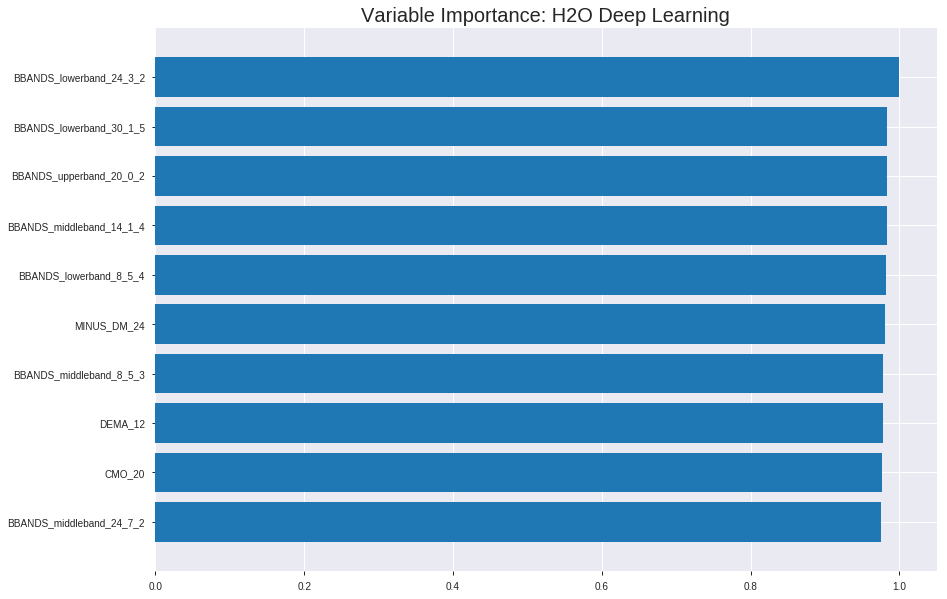

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_192357_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.40432371975634435
RMSE: 0.6358645451323295
LogLoss: 1.7298083059220986
Mean Per-Class Error: 0.4773250264764719
AUC: 0.5156328857393147
pr_auc: 0.5299315022343345
Gini: 0.0312657714786293
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00023551256107883265: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    818   1        (818.0/818.0)
1      0    935   0        (0.0/935.0)
Total  0    1753  0.4666   (818.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.000235513  0.695685   399
max f2                       0.000235513  0.851083   399
max f0point5                 0.00109797   0.590192   397
max accuracy                 0.00109797   0.539076   397
max precision                0.999834     0.636364   0
max recall                   0.000235513  1          399
max specificity              0.999834     0.97555    0
max absolute_mcc             0.896302     0.0556648  58
max min_per_class_accuracy   0.278719     0.508021   261
max mean_per_class_accuracy  0.896302     0.522675   58

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 40.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.999966           1.14575   1.14575            0.611111         0.999988    0.611111                    0.999988            0.0117647       0.0117647                  14.5752   14.5752
    2        0.0205362                   0.9998             1.04159   1.09367            0.555556         0.999898    0.583333                    0.999943            0.0106952       0.0224599                  4.15924   9.3672
    3        0.0302339                   0.999451           1.43372   1.20274            0.764706         0.999655    0.641509                    0.99985             0.0139037       0.0363636                  43.3721   20.2744
    4        0.040502                    0.998472           0.833274  1.10908            0.444444         0.998928    0.591549                    0.999617            0.00855615      0.0449198                  -16.6726  10.9076
    5        0.0501997                   0.997048           0.772004  1.04396            0.411765         0.997917    0.556818                    0.999288            0.00748663      0.0524064                  -22.7996  4.39596
    6        0.100399                    0.981158           1.12918   1.08657            0.602273         0.989803    0.579545                    0.994546            0.0566845       0.109091                   12.9181   8.65702
    7        0.150029                    0.95797            1.12061   1.09783            0.597701         0.970388    0.585551                    0.986555            0.055615        0.164706                   12.061    9.78305
    8        0.200228                    0.903619           1.02265   1.07898            0.545455         0.932415    0.575499                    0.972981            0.0513369       0.216043                   2.26544   7.89829
    9        0.300057                    0.738691           0.985644  1.04793            0.525714         0.833109    0.558935                    0.926446            0.0983957       0.314439                   -1.4356   4.79291
    10       0.399886                    0.497112           1.0285    1.04308            0.548571         0.619984    0.556348                    0.849939            0.102674        0.417112                   2.84981   4.30783
    11       0.500285                    0.278328           0.905475  1.01546            0.482955         0.385261    0.541619                    0.756686            0.0909091       0.508021                   -9.45248  1.54635
    12       0.600114                    0.119203           0.97493   1.00872            0.52             0.187747    0.538023                    0.662043            0.0973262       0.605348                   -2.50695  0.872085
    13       0.699943                    0.0403118          0.94279   0.999317           0.502857         0.0742976   0.533007                    0.578216            0.0941176       0.699465                   -5.72101  -0.0682505
    14       0.799772                    0.0126367          1.0285    1.00296            0.548571         0.0239779   0.53495                     0.509035            0.102674        0.802139                   2.84981   0.295987
    15       0.899601                    0.0028851          1.00707   1.00342            0.537143         0.00726932  0.535193                    0.453354            0.100535        0.902674                   0.707105  0.341608
    16       1                           1.50382e-05        0.969391  1                  0.517045         0.00117951  0.53



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.43173218573276934
RMSE: 0.6570633042049825
LogLoss: 9.110659986375087
Mean Per-Class Error: 0.45709684655813354
AUC: 0.5258139982053582
pr_auc: 0.5409496984322518
Gini: 0.05162799641071647
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.728868423473591e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    269  0        (0.0/269.0)
Total  0    501  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       4.72887e-51  0.698701   300
max f2                       4.72887e-51  0.852885   300
max f0point5                 4.72887e-51  0.591729   300
max accuracy                 9.50436e-21  0.538922   281
max precision                0.693624     0.590909   197
max recall                   4.72887e-51  1          300
max specificity              0.999977     0.99569    0
max absolute_mcc             0.693624     0.0875156  197
max min_per_class_accuracy   0.0965972    0.530172   251
max mean_per_class_accuracy  0.693624     0.542903   197

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 41.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.999879           0.620818  0.620818           0.333333         0.999925      0.333333                    0.999925            0.00743494      0.00743494                 -37.9182  -37.9182
    2        0.0219561                   0.999676           1.48996   1.01588            0.8              0.999728      0.545455                    0.999836            0.0148699       0.0223048                  48.9963   1.58837
    3        0.0319361                   0.99854            0.372491  0.814823           0.2              0.998956      0.4375                      0.999561            0.00371747      0.0260223                  -62.7509  -18.5177
    4        0.0419162                   0.997162           0.744981  0.798194           0.4              0.997797      0.428571                    0.999141            0.00743494      0.0334572                  -25.5019  -20.1806
    5        0.0518962                   0.996522           1.11747   0.859594           0.6              0.996732      0.461538                    0.998678            0.0111524       0.0446097                  11.7472   -14.0406
    6        0.101796                    0.99134            0.893978  0.876449           0.48             0.994026      0.470588                    0.996397            0.0446097       0.0892193                  -10.6022  -12.3551
    7        0.151697                    0.98007            0.968476  0.906721           0.52             0.985463      0.486842                    0.9928              0.0483271       0.137546                   -3.15242  -9.32792
    8        0.201597                    0.969324           1.19197   0.977327           0.64             0.974901      0.524752                    0.98837             0.0594796       0.197026                   19.197    -2.26729
    9        0.301397                    0.874911           1.11747   1.02373            0.6              0.928428      0.549669                    0.968522            0.111524        0.30855                    11.7472   2.37327
    10       0.401198                    0.686923           1.30372   1.09338            0.7              0.788176      0.587065                    0.923659            0.130112        0.438662                   30.3717   9.33807
    11       0.500998                    0.098631           0.893978  1.05366            0.48             0.426197      0.565737                    0.824563            0.0892193       0.527881                   -10.6022  5.3659
    12       0.600798                    8.07655e-49        0.968476  1.03951            0.52             0.00597259    0.55814                     0.688585            0.0966543       0.624535                   -3.15242  3.95089
    13       0.700599                    1.0569e-191        1.19197   1.06123            0.64             2.85695e-51   0.569801                    0.590496            0.118959        0.743494                   19.197    6.12271
    14       1                           0                  0.856729  1                  0.46             2.66683e-194  0.536926                    0.413701            0.256506        1                          -14.3271  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:40:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 19:40:47  7.338 sec         107 obs/sec       0.237307  1             416        0.635865         1.72981             -0.624532      0.515633        0.529932           1.14575          0.466629                         0.657063           9.11066               -0.736399        0.525814          0.54095              0.620818           0.463074
    2019-08-27 19:41:21  41.520 sec        174 obs/sec       3.43811   14            6027       0.554213         0.901454            -0.234105      0.539732        0.563079           1.24991          0.453508                         0.662724           9.56424               -0.766447        0.469491          0.250862             0.938677           0.463074
    2019-08-27 19:41:57  1 min 17.064 sec  232 obs/sec       8.85168   36            15517      0.565156         0.878876            -0.283321      0.57039         0.645235           1.87487          0.441529                         0.637915           9.42912               -0.636669        0.47993           0.251443             0.945777           0.463074
    2019-08-27 19:42:30  1 min 50.332 sec  250 obs/sec       13.8163   56            24220      0.672063         2.17017             -0.81476       0.599741        0.649372           1.87487          0.431261                         0.677932           10.0354               -0.84845         0.482054          0.247652             0.952075           0.461078
    2019-08-27 19:43:06  2 min 25.863 sec  260 obs/sec       19.1706   78            33606      0.494297         0.683709            0.0183105      0.58386         0.639155           1.77071          0.428408                         0.61493            9.34299               -0.520851        0.473297          0.249558             0.946008           0.463074
    2019-08-27 19:43:42  3 min  1.597 sec  269 obs/sec       24.7804   101           43440      0.479926         0.647537            0.0745599      0.643113        0.700735           1.87487          0.403879                         0.614767           9.19472               -0.520046        0.475203          0.262863             0.942357           0.459082
    2019-08-27 19:43:45  3 min  5.036 sec  269 obs/sec       24.7804   101           43440      0.635865         1.72981             -0.624532      0.515633        0.529932           1.14575          0.466629                         0.657063           9.11066               -0.736399        0.525814          0.54095              0.620818           0.463074

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BBANDS_lowerband_24_3_2   1.0                    1.0                  0.00103709450107529
BBANDS_lowerband_30_1_5   0.983711302280426      0.983711302280426    0.0010202015822406423
BBANDS_upperband_20_0_2   0.9836625456809998     0.9836625456809998   0.001020151017039486
BBANDS_middleband_14_1_4  0.9836101531982422     0.9836101531982422   0.0010200966810837205
BBANDS_lowerband_8_5_4    0.982038140296936      0.982038140296936    0.0010184663551481565
---                       ---                    ---                  ---
WILLR_30                  0.8568173050880432     0.8568173050880432   0.0008886005155329588
BBANDS_middleband_8_7_3   0.8554906845092773     0.8554906845092773   0.0008872246846257074
ADX_20                    0.8521841168403625     0.8521841168403625   0.0008837954614788425
MAVP_14_5                 0.8509789705276489     0.8509789705276489   0.000882545610864936
BBANDS_upperband_30_5_4   0.8504852056503296     0.8504852056503296   0.000882033530025844


See the whole table with table.as_data_frame()


('accuracy', 0.5976095617529881)

('F1', 0.6432432432432432)

('auc', 0.5572638146167558)

('logloss', 4.569371151966573)

('mean_per_class_error', 0.4156799083269671)

('rmse', 0.6549378407932827)

('mse', 0.4289435753029673)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


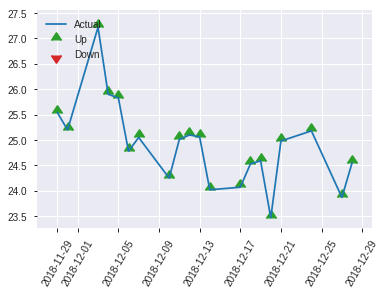


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4289435753029673
RMSE: 0.6549378407932827
LogLoss: 4.569371151966573
Mean Per-Class Error: 0.4156799083269671
AUC: 0.5572638146167558
pr_auc: 0.5565255750159114
Gini: 0.11452762923351156
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.674487361248825e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    119  0        (0.0/119.0)
Total  0    251  0.5259   (132.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       4.67449e-51  0.643243  213
max f2                       4.67449e-51  0.818432  213
max f0point5                 0.977488     0.543175  59
max accuracy                 0.977488     0.59761   59
max precision                0.999992     1         0
max recall                   4.67449e-51  1         213
max specificity              0.999992     1         0
max absolute_mcc             0.977488     0.197437  59
max min_per_class_accuracy   0.853852     0.537879  125
max mean_per_class_accuracy  0.977488     0.58432   59

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 65.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.999894           1.40616   1.40616            0.666667         0.99995      0.666667                    0.99995             0.0168067       0.0168067                  40.6162   40.6162
    2        0.0239044                   0.999794           1.40616   1.40616            0.666667         0.999857     0.666667                    0.999904            0.0168067       0.0336134                  40.6162   40.6162
    3        0.0318725                   0.999667           2.10924   1.58193            1                0.999729     0.75                        0.99986             0.0168067       0.0504202                  110.924   58.1933
    4        0.0438247                   0.999346           2.10924   1.72574            1                0.999521     0.818182                    0.999768            0.0252101       0.0756303                  110.924   72.5745
    5        0.0517928                   0.998202           1.05462   1.6225             0.5              0.998728     0.769231                    0.999608            0.00840336      0.0840336                  5.46218   62.2495
    6        0.103586                    0.995648           1.298     1.46025            0.615385         0.996959     0.692308                    0.998283            0.0672269       0.151261                   29.7996   46.0246
    7        0.151394                    0.991036           1.23039   1.38766            0.583333         0.992871     0.657895                    0.996574            0.0588235       0.210084                   23.0392   38.766
    8        0.203187                    0.984535           1.298     1.3648             0.615385         0.987659     0.647059                    0.994302            0.0672269       0.277311                   29.7996   36.4805
    9        0.302789                    0.960717           0.843697  1.19339            0.4              0.973379     0.565789                    0.987419            0.0840336       0.361345                   -15.6303  19.3388
    10       0.40239                     0.917205           0.928067  1.12771            0.44             0.938771     0.534653                    0.975377            0.092437        0.453782                   -7.19328  12.7714
    11       0.501992                    0.853852           0.928067  1.0881             0.44             0.893659     0.515873                    0.959164            0.092437        0.546218                   -7.19328  8.81019
    12       0.601594                    0.767553           0.759328  1.03367            0.36             0.82089      0.490066                    0.936271            0.0756303       0.621849                   -24.0672  3.36691
    13       0.701195                    0.552558           0.674958  0.982716           0.32             0.679121     0.465909                    0.899744            0.0672269       0.689076                   -32.5042  -1.72842
    14       0.800797                    3.08092e-10        1.09681   0.996906           0.52             0.203143     0.472637                    0.813102            0.109244        0.798319                   9.68067   -0.309377
    15       1                           0                  1.01244   1                  0.48             4.18168e-13  0.474104                    0.651129            0.201681        1                          1.2437    0

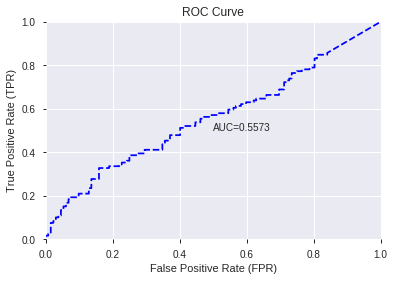

This function is available for GLM models only


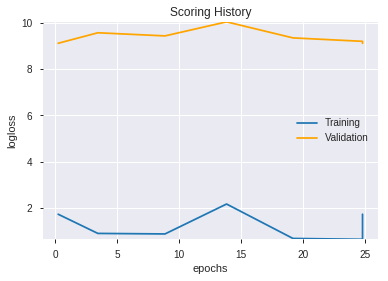

--2019-08-27 19:54:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_192357_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_192357_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190827_195422  0.581423  0.874693              0.467564  0.571405  0.326504
1  DeepLearning_grid_1_AutoML_20190827_195422_model_2  0.564107  0.987151              0.478100  0.570617  0.325604
2  DeepLearning_grid_1_AutoML_20190827_195422_model_3  0.559142  0.909447              0.485676  0.572012  0.327198
3  DeepLearning_grid_1_AutoML_20190827_195422_model_7  0.557869  0.735758              0.485262  0.519967  0.270366
4  DeepLearning_grid_1_AutoML_20190827_195422_model_5  0.547237  0.737360              0.482302  0.521029  0.271471
5  DeepLearning_grid_1_AutoML_20190827_195422_model_6  0.544945  0.729481              0.496212  0.517467  0.267772
6  DeepLearning_grid_1_AutoML_20190827_195422_model_9  0.526420  0.704419              0.500000  0.505578  0.255609
7  DeepLearning_grid_1_AutoML_20190827_195422_model_4  0.526356  0.721868              0.477273  0.513592  0.263776
8  DeepLearning_grid_1_AutoML_20190827_195422_model_8  0.500000  0.699872              0.500000  0.503344  0.253355
9  DeepLearning_grid_1_AutoML_20190827_195422_model_1  0.459766  0.891273              0.500000  0.564341  0.318481

variable  relative_importance  scaled_importance  percentage
0                  ROCR100_8             1.000000           1.000000    0.028743
1   BBANDS_middleband_14_1_4             0.955869           0.955869    0.027475
2                         AD             0.936407           0.936407    0.026915
3                        OBV             0.898702           0.898702    0.025832
4    BBANDS_middleband_8_5_4             0.846751           0.846751    0.024338
5    BBANDS_lowerband_24_5_4             0.827762           0.827762    0.023793
6                MINUS_DM_24             0.826960           0.826960    0.023770
7          LINEARREG_SLOPE_8             0.826570           0.826570    0.023758
8                    MA_12_1             0.819648           0.819648    0.023559
9                 MIDPRICE_8             0.816269           0.816269    0.023462
10   BBANDS_upperband_14_7_5             0.797173           0.797173    0.022913
11   BBANDS_upperband_30_6_3             0.781343           0.781343    0.022458
12                 MAVP_30_6             0.765245           0.765245    0.021996
13   BBANDS_lowerband_14_5_5             0.764416           0.764416    0.021972
14                 CORREL_30             0.758972           0.758972    0.021815
15   BBANDS_middleband_8_5_3             0.743196           0.743196    0.021362
16   BBANDS_lowerband_30_6_5             0.743066           0.743066    0.021358
17  BBANDS_middleband_12_1_5             0.741341           0.741341    0.021309
18   BBANDS_lowerband_12_6_5             0.741309           0.741309    0.021308
19   BBANDS_upperband_20_0_2             0.738840           0.738840    0.021237
20    BBANDS_upperband_8_0_3             0.719228           0.719228    0.020673
21   BBANDS_lowerband_14_1_2             0.718549           0.718549    0.020653
22                MIDPOINT_8             0.716888           0.716888    0.020606
23        LINEARREG_SLOPE_20             0.713014           0.713014    0.020494
24                    ADX_24             0.710010           0.710010    0.020408
25   BBANDS_middleband_8_3_3             0.699310           0.699310    0.020100
26                    T3_8_0             0.685732           0.685732    0.019710
27  BBANDS_middleband_14_3_5             0.681208           0.681208    0.019580
28         CDL3WHITESOLDIERS             0.667765           0.667765    0.019194
29   BBANDS_upperband_14_2_3             0.666779           0.666779    0.019165
30                   KAMA_24             0.665306           0.665306    0.019123
31   BBANDS_lowerband_24_3_2             0.658715           0.658715    0.018934
32    BBANDS_lowerband_8_8_4             0.654629           0.654629    0.018816
33   BBANDS_upperband_14_3_3             0.648586           0.648586    0.018642
34   BBANDS_upperband_14_1_2             0.623871           0.623871    0.017932
35                   MA_30_1             0.621033           0.621033    0.017851
36                   DEMA_12             0.614596           0.614596    0.017666
37                    T3_8_1             0.608026           0.608026    0.017477
38                PLUS_DM_12             0.594893           0.594893    0.017099
39                     ADOSC             0.581114           0.581114    0.016703
40  BBANDS_middleband_30_2_2             0.572491           0.572491    0.016455
41   BBANDS_upperband_14_5_4             0.567549           0.567549    0.016313
42                   MA_30_7             0.562947           0.562947    0.016181
43   BBANDS_lowerband_30_1_5             0.561804           0.561804    0.016148
44    BBANDS_lowerband_8_5_4             0.548772           0.548772    0.015774
45  BBANDS_middleband_24_7_2             0.543593           0.543593    0.015625
46  BBANDS_middleband_12_3_2             0.499851           0.499851    0.014367
47                    CMO_20             0.498567           0.498567    0.014330
48                    ROC_30             0.491041  

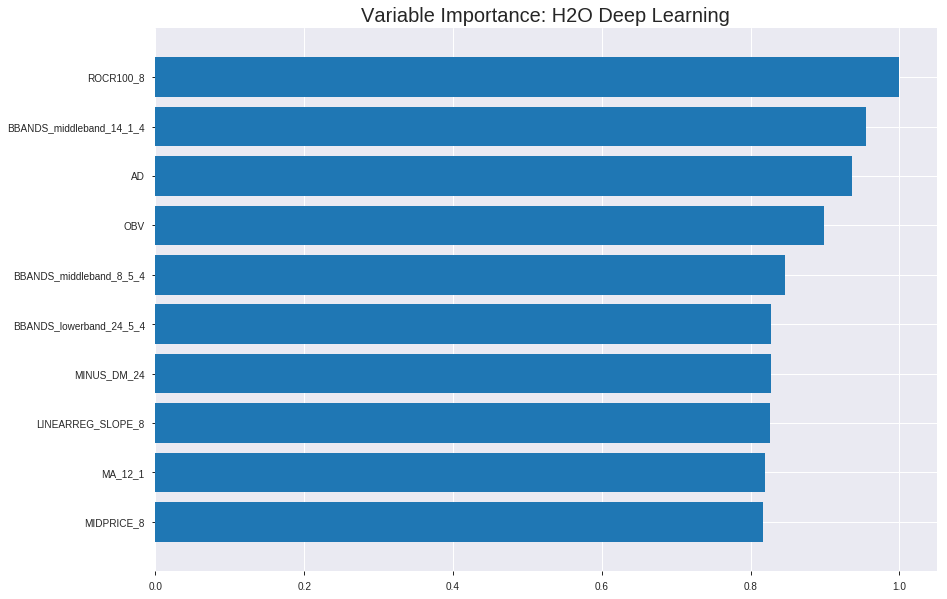

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_195422


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2881027945503878
RMSE: 0.5367520792231621
LogLoss: 0.7886857754218376
Mean Per-Class Error: 0.4450269994639331
AUC: 0.565387079481715
pr_auc: 0.6030486307819577
Gini: 0.13077415896342992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48725763661118243: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   800   0.978    (800.0/818.0)
1      5    930   0.0053   (5.0/935.0)
Total  23   1730  0.4592   (805.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487258     0.697936  378
max f2                       0.438292     0.852014  393
max f0point5                 0.563473     0.593341  355
max accuracy                 0.71217      0.55733   222
max precision                0.93376      1         0
max recall                   0.438292     1         393
max specificity              0.93376      1         0
max absolute_mcc             0.828628     0.122347  69
max min_per_class_accuracy   0.74392      0.549733  176
max mean_per_class_accuracy  0.753128     0.554973  164

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 73.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.904563           1.56239   1.56239            0.833333         0.914133  0.833333                    0.914133            0.0160428       0.0160428                  56.2389   56.2389
    2        0.0205362                   0.895968           1.04159   1.30199            0.555556         0.900562  0.694444                    0.907348            0.0106952       0.026738                   4.15924   30.199
    3        0.0302339                   0.888325           1.43372   1.34424            0.764706         0.891007  0.716981                    0.902106            0.0139037       0.0406417                  43.3721   34.4244
    4        0.040502                    0.877309           1.04159   1.26752            0.555556         0.883042  0.676056                    0.897273            0.0106952       0.0513369                  4.15924   26.7515
    5        0.0501997                   0.866914           1.54401   1.32093            0.823529         0.872857  0.704545                    0.892556            0.0149733       0.0663102                  54.4008   32.0929
    6        0.100399                    0.840031           1.27832   1.29962            0.681818         0.851699  0.693182                    0.872128            0.0641711       0.130481                   27.8318   29.9623
    7        0.150029                    0.823268           1.12061   1.24041            0.597701         0.831096  0.661597                    0.858554            0.055615        0.186096                   12.061    24.0406
    8        0.200228                    0.808971           0.937433  1.16445            0.5              0.816489  0.621083                    0.848008            0.0470588       0.233155                   -6.25668  16.4447
    9        0.300057                    0.783384           1.00707   1.11209            0.537143         0.796516  0.593156                    0.830877            0.100535        0.33369                    0.707105  11.2088
    10       0.399886                    0.763938           1.13563   1.11797            0.605714         0.773981  0.596291                    0.816673            0.113369        0.447059                   13.5633   11.7966
    11       0.500285                    0.743981           0.990696  1.09242            0.528409         0.754653  0.582668                    0.804227            0.0994652       0.546524                   -0.93036  9.2425
    12       0.600114                    0.724176           0.97493   1.07288            0.52             0.734068  0.572243                    0.792556            0.0973262       0.64385                    -2.50695  7.28798
    13       0.699943                    0.703434           0.910649  1.04974            0.485714         0.714721  0.559902                    0.781455            0.0909091       0.734759                   -8.93506  4.97418
    14       0.799772                    0.676511           0.846368  1.02436            0.451429         0.6909    0.546362                    0.770151            0.084492        0.819251                   -15.3632  2.43563
    15       0.899601                    0.625675           0.932076  1.01412            0.497143         0.655162  0.5409                      0.757391            0.0930481       0.912299                   -6.79236  1.4116
    16       1                           0.405113           0.873517  1                  0.465909         0.56829   0.533371                    0.738405            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2965636811887834
RMSE: 0.5445766072728275
LogLoss: 0.8228147651332991
Mean Per-Class Error: 0.43762017690039734
AUC: 0.5730835790283296
pr_auc: 0.5866621427482301
Gini: 0.14616715805665925
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6830367681586405: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   212  0.9138   (212.0/232.0)
1      8    261  0.0297   (8.0/269.0)
Total  28   473  0.4391   (220.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.683037     0.703504  372
max f2                       0.659927     0.854047  391
max f0point5                 0.713753     0.608649  316
max accuracy                 0.732918     0.572854  279
max precision                0.998658     1         0
max recall                   0.633618     1         397
max specificity              0.998658     1         0
max absolute_mcc             0.732918     0.127238  279
max min_per_class_accuracy   0.754773     0.556034  210
max mean_per_class_accuracy  0.766485     0.56238   172

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 76.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.953004           1.24164   1.24164            0.666667         0.989606  0.666667                    0.989606            0.0148699       0.0148699                  24.1636   24.1636
    2        0.0219561                   0.92494            1.11747   1.1852             0.6              0.938237  0.636364                    0.966256            0.0111524       0.0260223                  11.7472   18.5198
    3        0.0319361                   0.905252           1.11747   1.16403            0.6              0.919885  0.625                       0.951765            0.0111524       0.0371747                  11.7472   16.4033
    4        0.0419162                   0.878427           1.48996   1.24164            0.8              0.89192   0.666667                    0.937516            0.0148699       0.0520446                  48.9963   24.1636
    5        0.0518962                   0.867737           1.48996   1.28939            0.8              0.870872  0.692308                    0.9247              0.0148699       0.0669145                  48.9963   28.9391
    6        0.101796                    0.838292           0.893978  1.09556            0.48             0.851227  0.588235                    0.888684            0.0446097       0.111524                   -10.6022  9.55609
    7        0.151697                    0.816993           1.11747   1.10277            0.6              0.826959  0.592105                    0.86838             0.0557621       0.167286                   11.7472   10.2769
    8        0.201597                    0.803706           1.19197   1.12485            0.64             0.810815  0.60396                     0.854131            0.0594796       0.226766                   19.197    12.4848
    9        0.301397                    0.786634           1.11747   1.12241            0.6              0.795071  0.602649                    0.834575            0.111524        0.33829                    11.7472   12.2406
    10       0.401198                    0.76669            1.19197   1.13971            0.64             0.776232  0.61194                     0.820062            0.118959        0.457249                   19.197    13.971
    11       0.500998                    0.75571            0.931227  1.09818            0.5              0.7607    0.589641                    0.808237            0.0929368       0.550186                   -6.87732  9.81798
    12       0.600798                    0.743906           1.04297   1.08901            0.56             0.749098  0.584718                    0.798413            0.104089        0.654275                   4.2974    8.90094
    13       0.700599                    0.732323           1.00572   1.07715            0.54             0.738179  0.578348                    0.789833            0.100372        0.754647                   0.572491  7.71455
    14       0.800399                    0.713753           0.931227  1.05895            0.5              0.724661  0.568579                    0.781706            0.0929368       0.847584                   -6.87732  5.89511
    15       0.9002                      0.696177           0.744981  1.02414            0.4              0.705213  0.549889                    0.773226            0.0743494       0.921933                   -25.5019  2.4143
    16       1                           0.631254           0.78223   1                  0.42             0.675023  0.536926                    0.763425           


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:54:23  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 19:54:23  0.072 sec   58433 obs/sec     1         1             1753       0.612148         1.38068             -0.505606      0.508063        0.551821           1.35407          0.466629                         0.658058           1.97752               -0.741658        0.504543          0.551541             1.55204            0.459082
    2019-08-27 19:54:23  0.303 sec   73041 obs/sec     10        10            17530      0.536752         0.788686            -0.157568      0.565387        0.603049           1.56239          0.459213                         0.544577           0.822815              -0.19276         0.573084          0.586662             1.24164            0.439122

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
ROCR100_8                 1.0                    1.0                  0.028743262850187634
BBANDS_middleband_14_1_4  0.9558685421943665     0.9558685421943665   0.027474780758518346
AD                        0.9364074468612671     0.9364074468612671   0.02691540538000651
OBV                       0.8987018465995789     0.8987018465995789   0.0258316234007607
BBANDS_middleband_8_5_4   0.8467512130737305     0.8467512130737305   0.02433839268609347
---                       ---                    ---                  ---
BBANDS_middleband_24_7_2  0.5435934066772461     0.5435934066772461   0.015624648171753026
BBANDS_middleband_12_3_2  0.4998513162136078     0.4998513162136078   0.014367357767939985
CMO_20                    0.4985671937465668     0.4985671937465668   0.014330447898337994
ROC_30                    0.49104076623916626    0.49104076623916626  0.014114113814169897
BBANDS_lowerband_20_7_5   0.36505502462387085    0.36505502462387085  0.01049287252754564


See the whole table with table.as_data_frame()


('accuracy', 0.5896414342629482)

('F1', 0.6515580736543909)

('auc', 0.5814234784823019)

('logloss', 0.8746928980116788)

('mean_per_class_error', 0.4108416093710211)

('rmse', 0.5714051834757584)

('mse', 0.3265038837029652)

deeplearning prediction progress: |███████████████████████████████████████| 100%


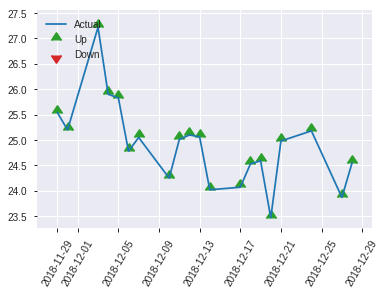


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3265038837029652
RMSE: 0.5714051834757584
LogLoss: 0.8746928980116788
Mean Per-Class Error: 0.4108416093710211
AUC: 0.5814234784823019
pr_auc: 0.5278716745342298
Gini: 0.16284695696460383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.686582820699758: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   119  0.9015   (119.0/132.0)
1      4    115  0.0336   (4.0/119.0)
Total  17   234  0.49     (123.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.686583     0.651558  233
max f2                       0.635281     0.819559  249
max f0point5                 0.762672     0.568369  121
max accuracy                 0.762672     0.589641  121
max precision                0.891569     1         0
max recall                   0.635281     1         249
max specificity              0.891569     1         0
max absolute_mcc             0.762672     0.178147  121
max min_per_class_accuracy   0.762672     0.579832  121
max mean_per_class_accuracy  0.762672     0.589158  121

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 75.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.873429           1.40616   1.40616            0.666667         0.88007   0.666667                    0.88007             0.0168067       0.0168067                  40.6162   40.6162
    2        0.0239044                   0.862888           0.703081  1.05462            0.333333         0.868077  0.5                         0.874073            0.00840336      0.0252101                  -29.6919  5.46218
    3        0.0318725                   0.857815           1.05462   1.05462            0.5              0.860836  0.5                         0.870764            0.00840336      0.0336134                  5.46218   5.46218
    4        0.0438247                   0.850428           1.40616   1.1505             0.666667         0.853263  0.545455                    0.865991            0.0168067       0.0504202                  40.6162   15.0497
    5        0.0517928                   0.847566           0         0.973497           0                0.848332  0.461538                    0.863274            0               0.0504202                  -100      -2.65029
    6        0.103586                    0.828216           1.298     1.13575            0.615385         0.836552  0.538462                    0.849913            0.0672269       0.117647                   29.7996   13.5747
    7        0.151394                    0.815674           0.878852  1.05462            0.416667         0.821674  0.5                         0.840996            0.0420168       0.159664                   -12.1148  5.46218
    8        0.203187                    0.799345           1.46025   1.15802            0.692308         0.804548  0.54902                     0.831705            0.0756303       0.235294                   46.0246   15.8016
    9        0.302789                    0.782603           1.09681   1.13788            0.52             0.788308  0.539474                    0.81743             0.109244        0.344538                   9.68067   13.7881
    10       0.40239                     0.76951            1.26555   1.16948            0.6              0.775848  0.554455                    0.807137            0.12605         0.470588                   26.5546   16.9482
    11       0.501992                    0.761765           1.18118   1.1718             0.56             0.765336  0.555556                    0.798843            0.117647        0.588235                   18.1176   17.1802
    12       0.601594                    0.745076           0.506218  1.06161            0.24             0.753182  0.503311                    0.791283            0.0504202       0.638655                   -49.3782  6.16061
    13       0.701195                    0.734157           1.18118   1.07859            0.56             0.739393  0.511364                    0.783913            0.117647        0.756303                   18.1176   7.85905
    14       0.800797                    0.718104           1.09681   1.08086            0.52             0.724544  0.512438                    0.776528            0.109244        0.865546                   9.68067   8.08562
    15       0.900398                    0.698603           0.674958  1.03596            0.32             0.707451  0.49115                     0.768887            0.0672269       0.932773                   -32.5042  3.5956
    16       1                           0.607107           0.674958  1                  0.32             0.671773  0.474104                    0.759214         

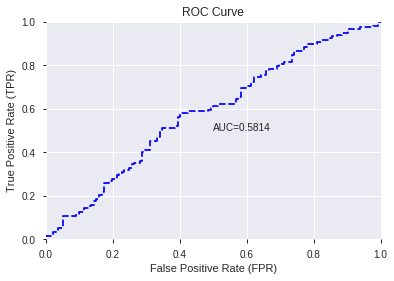

This function is available for GLM models only


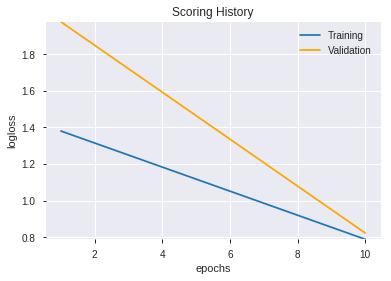

--2019-08-27 20:04:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_195422',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_195422',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_b6d1'

['ROCR100_8',
 'BBANDS_middleband_14_1_4',
 'AD',
 'OBV',
 'BBANDS_middleband_8_5_4',
 'BBANDS_lowerband_24_5_4',
 'MINUS_DM_24',
 'LINEARREG_SLOPE_8',
 'MA_12_1',
 'MIDPRICE_8',
 'BBANDS_upperband_14_7_5',
 'BBANDS_upperband_30_6_3',
 'MAVP_30_6',
 'BBANDS_lowerband_14_5_5',
 'CORREL_30',
 'BBANDS_middleband_8_5_3',
 'BBANDS_lowerband_30_6_5',
 'BBANDS_middleband_12_1_5',
 'BBANDS_lowerband_12_6_5',
 'BBANDS_upperband_20_0_2',
 'BBANDS_upperband_8_0_3',
 'BBANDS_lowerband_14_1_2',
 'MIDPOINT_8',
 'LINEARREG_SLOPE_20',
 'ADX_24',
 'BBANDS_middleband_8_3_3',
 'T3_8_0',
 'BBANDS_middleband_14_3_5',
 'CDL3WHITESOLDIERS',
 'BBANDS_upperband_14_2_3',
 'KAMA_24',
 'BBANDS_lowerband_24_3_2',
 'BBANDS_lowerband_8_8_4',
 'BBANDS_upperband_14_3_3',
 'BBANDS_upperband_14_1_2',
 'MA_30_1',
 'DEMA_12',
 'T3_8_1',
 'PLUS_DM_12',
 'ADOSC',
 'BBANDS_middleband_30_2_2',
 'BBANDS_upperband_14_5_4',
 'MA_30_7',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_middleband_24_7_2',
 'BBANDS_m

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_200500_model_1  0.529985  0.695768                   0.5  0.501308  0.251309

variable  relative_importance  scaled_importance  percentage
0                        OBV             0.007460           1.000000    0.149479
1          LINEARREG_SLOPE_8             0.004356           0.583882    0.087278
2                  CORREL_30             0.003070           0.411539    0.061516
3                     CMO_20             0.002966           0.397598    0.059432
4         LINEARREG_SLOPE_20             0.002736           0.366775    0.054825
5                      ADOSC             0.002541           0.340553    0.050906
6                     ROC_30             0.002289           0.306845    0.045867
7                  ROCR100_8             0.002001           0.268219    0.040093
8                         AD             0.001684           0.225683    0.033735
9                     ADX_24             0.001524           0.204308    0.030540
10   BBANDS_lowerband_30_6_5             0.001441           0.193154    0.028872
11   BBANDS_lowerband_30_1_5             0.001397           0.187240    0.027988
12               MINUS_DM_24             0.001293           0.173369    0.025915
13                PLUS_DM_12             0.001251           0.167660    0.025062
14   BBANDS_lowerband_20_7_5             0.001116           0.149603    0.022363
15   BBANDS_lowerband_12_6_5             0.001098           0.147224    0.022007
16   BBANDS_lowerband_24_5_4             0.001084           0.145339    0.021725
17   BBANDS_lowerband_14_5_5             0.000740           0.099164    0.014823
18    BBANDS_lowerband_8_5_4             0.000720           0.096475    0.014421
19    BBANDS_lowerband_8_8_4             0.000636           0.085264    0.012745
20         CDL3WHITESOLDIERS             0.000491           0.065828    0.009840
21   BBANDS_lowerband_14_1_2             0.000488           0.065427    0.009780
22   BBANDS_lowerband_24_3_2             0.000482           0.064637    0.009662
23                MIDPOINT_8             0.000480           0.064378    0.009623
24                   MA_30_1             0.000474           0.063476    0.009488
25                 MAVP_30_6             0.000426           0.057157    0.008544
26                MIDPRICE_8             0.000401           0.053770    0.008037
27                    T3_8_0             0.000377           0.050549    0.007556
28   BBANDS_middleband_8_3_3             0.000372           0.049926    0.007463
29  BBANDS_middleband_30_2_2             0.000362           0.048525    0.007253
30                   MA_30_7             0.000354           0.047506    0.007101
31   BBANDS_upperband_14_5_4             0.000341           0.045744    0.006838
32                   KAMA_24             0.000341           0.045699    0.006831
33                    T3_8_1             0.000320           0.042960    0.006422
34  BBANDS_middleband_24_7_2             0.000300           0.040181    0.006006
35   BBANDS_upperband_14_7_5             0.000278           0.037309    0.005577
36                   MA_12_1             0.000256           0.034371    0.005138
37  BBANDS_middleband_12_1_5             0.000247           0.033048    0.004940
38  BBANDS_middleband_14_1_4             0.000234           0.031373    0.004690
39                   DEMA_12             0.000206           0.027561    0.004120
40   BBANDS_upperband_14_3_3             0.000198           0.026524    0.003965
41   BBANDS_upperband_14_2_3             0.000186           0.024889    0.003720
42  BBANDS_middleband_12_3_2             0.000177           0.023705    0.003543
43   BBANDS_middleband_8_5_3             0.000173           0.023175    0.003464
44   BBANDS_middleband_8_5_4             0.000160           0.021503    0.003214
45  BBANDS_middleband_14_3_5             0.000142           0.019033    0.002845
46    BBANDS_upperband_8_0_3             0.000121           0.016190    0.002420
47   BBANDS_upperband_30_6_3             0.000089           0.011889    0.001777
48   BBANDS_upperband_20_0_2             0.000016  

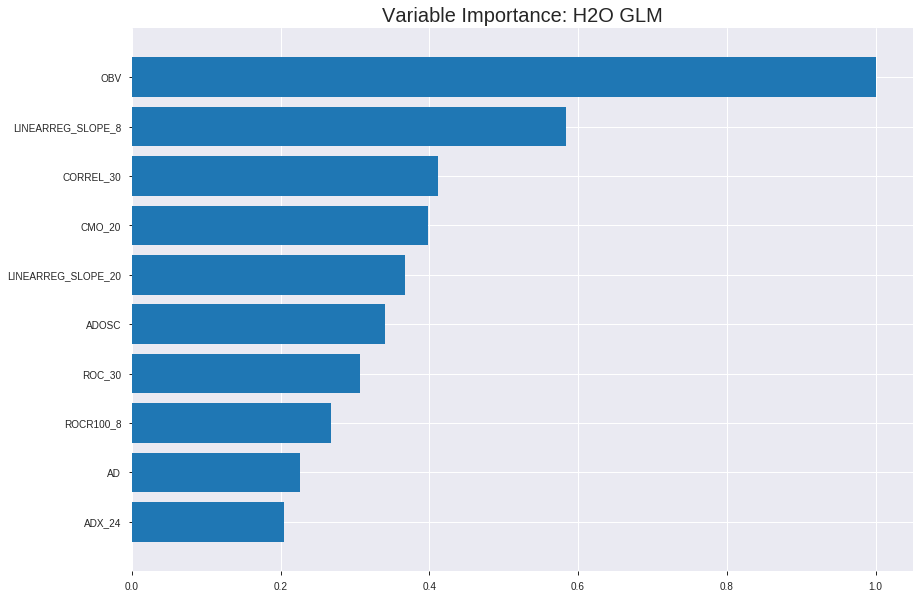

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_200500_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24869987826871678
RMSE: 0.4986981835426281
LogLoss: 0.6905434425224207
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2422.3593080819073
Residual deviance: 2421.045309483607
AIC: 2523.045309483607
AUC: 0.517192709490998
pr_auc: 0.553637797200838
Gini: 0.034385418981996096
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5184692055521294: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      13   805   0.9841   (805.0/818.0)
1      4    931   0.0043   (4.0/935.0)
Total  17   1736  0.4615   (809.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.518469     0.697117   388
max f2                       0.516492     0.851083   399
max f0point5                 0.520936     0.591426   365
max accuracy                 0.520936     0.541358   365
max precision                0.549993     1          0
max recall                   0.516492     1          399
max specificity              0.549993     1          0
max absolute_mcc             0.545657     0.0635619  24
max min_per_class_accuracy   0.534717     0.51016    176
max mean_per_class_accuracy  0.536624     0.520603   136

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.547436           1.14575   1.14575            0.611111         0.548408  0.611111                    0.548408            0.0117647       0.0117647                  14.5752    14.5752
    2        0.0205362                   0.545946           1.56239   1.35407            0.833333         0.546865  0.722222                    0.547637            0.0160428       0.0278075                  56.2389    35.407
    3        0.0302339                   0.544527           1.21315   1.30887            0.647059         0.54513   0.698113                    0.546833            0.0117647       0.0395722                  21.3149    30.8869
    4        0.040502                    0.542889           0.833274  1.1883             0.444444         0.543465  0.633803                    0.545979            0.00855615      0.0481283                  -16.6726   18.8296
    5        0.0501997                   0.542239           0.88229   1.12918            0.470588         0.542551  0.602273                    0.545317            0.00855615      0.0566845                  -11.771    12.9181
    6        0.100399                    0.540679           1.04396   1.08657            0.556818         0.54139   0.579545                    0.543353            0.0524064       0.109091                   4.39596    8.65702
    7        0.150029                    0.538921           1.05596   1.07644            0.563218         0.539782  0.574144                    0.542172            0.0524064       0.161497                   5.59592    7.64442
    8        0.200228                    0.537962           1.00135   1.05762            0.534091         0.538404  0.564103                    0.541227            0.0502674       0.211765                   0.134905   5.76169
    9        0.300057                    0.536865           1.04993   1.05506            0.56             0.537381  0.562738                    0.539947            0.104813        0.316578                   4.99251    5.50578
    10       0.399886                    0.535848           0.97493   1.03505            0.52             0.536316  0.552068                    0.539041            0.0973262       0.413904                   -2.50695   3.50546
    11       0.500285                    0.534695           0.958738  1.01974            0.511364         0.535307  0.5439                      0.538292            0.0962567       0.51016                    -4.12615   1.97391
    12       0.600114                    0.533503           0.996358  1.01585            0.531429         0.534109  0.541825                    0.537596            0.0994652       0.609626                   -0.364248  1.58496
    13       0.699943                    0.531202           0.921363  1.00237            0.491429         0.532561  0.534637                    0.536878            0.0919786       0.701604                   -7.86371   0.237351
    14       0.799772                    0.527252           1.04993   1.00831            0.56             0.528937  0.537803                    0.535887            0.104813        0.806417                   4.99251    0.830899
    15       0.899601                    0.523528           1.00707   1.00817            0.537143         0.525497  0.53773                     0.534734            0.100535        0.906952                   0.707105   0.817161
    16       1                           0.516492           0.926781  1                  0.494318         0.521165  0.533371                  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24882909320993418
RMSE: 0.49882771896711414
LogLoss: 0.6908039655098471
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 691.823895750088
Residual deviance: 692.1855734408668
AIC: 794.1855734408668
AUC: 0.5233784130239713
pr_auc: 0.5687168837318345
Gini: 0.04675682604794251
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5121851711460348: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    231  0.9957   (231.0/232.0)
1      0    269  0        (0.0/269.0)
Total  1    500  0.4611   (231.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.512185     0.69961   398
max f2                       0.512185     0.853426  398
max f0point5                 0.513154     0.592912  382
max accuracy                 0.51328      0.540918  378
max precision                0.530089     1         0
max recall                   0.512185     1         398
max specificity              0.530089     1         0
max absolute_mcc             0.522928     0.108893  47
max min_per_class_accuracy   0.518695     0.516729  197
max mean_per_class_accuracy  0.522928     0.532728  47

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 51.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.526224           0.931227  0.931227           0.5              0.527687  0.5                         0.527687            0.0111524       0.0111524                  -6.87732  -6.87732
    2        0.0219561                   0.525474           1.11747   1.01588            0.6              0.525584  0.545455                    0.526731            0.0111524       0.0223048                  11.7472   1.58837
    3        0.0319361                   0.524607           1.86245   1.28044            1                0.525116  0.6875                      0.526226            0.0185874       0.0408922                  86.2454   28.0437
    4        0.0419162                   0.52439            1.11747   1.24164            0.6              0.524433  0.666667                    0.525799            0.0111524       0.0520446                  11.7472   24.1636
    5        0.0518962                   0.523773           1.11747   1.21776            0.6              0.524142  0.653846                    0.525481            0.0111524       0.063197                   11.7472   21.7758
    6        0.101796                    0.522916           1.34097   1.27815            0.72             0.523276  0.686275                    0.5244              0.0669145       0.130112                   34.0967   27.8154
    7        0.151697                    0.522417           0.968476  1.17629            0.52             0.52265   0.631579                    0.523824            0.0483271       0.178439                   -3.15242  17.6286
    8        0.201597                    0.521821           0.81948   1.08797            0.44             0.52208   0.584158                    0.523392            0.0408922       0.219331                   -18.052   8.79679
    9        0.301397                    0.521048           1.00572   1.06074            0.54             0.521409  0.569536                    0.522736            0.100372        0.319703                   0.572491  6.07351
    10       0.401198                    0.519831           1.00572   1.04705            0.54             0.520359  0.562189                    0.522145            0.100372        0.420074                   0.572491  4.7051
    11       0.500998                    0.518681           0.968476  1.0314             0.52             0.519202  0.553785                    0.521558            0.0966543       0.516729                   -3.15242  3.13986
    12       0.600798                    0.518028           0.931227  1.01476            0.5              0.518314  0.54485                     0.52102             0.0929368       0.609665                   -6.87732  1.47587
    13       0.700599                    0.516923           0.968476  1.00817            0.52             0.517526  0.541311                    0.520522            0.0966543       0.70632                    -3.15242  0.816573
    14       0.800399                    0.516001           0.81948   0.984639           0.44             0.516477  0.528678                    0.520018            0.0817844       0.788104                   -18.052   -1.53612
    15       0.9002                      0.514542           1.11747   0.999365           0.6              0.515199  0.536585                    0.519483            0.111524        0.899628                   11.7472   -0.063469
    16       1                           0.512168           1.00572   1                  0.54             0.513424  0.536926                    0.518879     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:05:00  0.000 sec   2            2.1       51            1.38109           1.38161
    2019-08-27 20:05:00  0.008 sec   3            1.3       51            1.38081           1.38174
    2019-08-27 20:05:00  0.015 sec   4            0.82      51            1.38041           1.38176
    2019-08-27 20:05:00  0.023 sec   5            0.51      51            1.37988           1.38172
    2019-08-27 20:05:00  0.030 sec   6            0.32      51            1.3792            1.38165
    2019-08-27 20:05:00  0.043 sec   8            0.2       51            1.37839           1.38169
    2019-08-27 20:05:00  0.057 sec   10           0.12      51            1.3775            1.38202
    2019-08-27 20:05:00  0.069 sec   12           0.076     51            1.37657           1.3828
    2019-08-27 20:05:00  0.082 sec   14           0.047     51            1.37566           1.38413
    2019-08-27 20:05:00  0.095 sec   16           0.029     51            1.37478           1.38611

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.6432432432432432)

('auc', 0.5299847211611918)

('logloss', 0.6957678075860849)

('mean_per_class_error', 0.43073593073593075)

('rmse', 0.5013077829769305)

('mse', 0.2513094932732452)

glm prediction progress: |████████████████████████████████████████████████| 100%


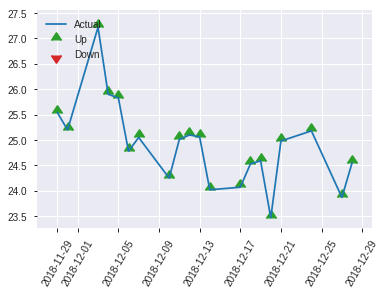


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2513094932732452
RMSE: 0.5013077829769305
LogLoss: 0.6957678075860849
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 350.81837939662717
Residual deviance: 349.27543940821465
AIC: 451.27543940821465
AUC: 0.5299847211611918
pr_auc: 0.48140846584274416
Gini: 0.05996944232238355
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5114853483037327: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    119  0        (0.0/119.0)
Total  0    251  0.5259   (132.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511485     0.643243  250
max f2                       0.511485     0.818432  250
max f0point5                 0.517664     0.557012  160
max accuracy                 0.517664     0.561753  160
max precision                0.517664     0.52795   160
max recall                   0.511485     1         250
max specificity              0.529323     0.992424  0
max absolute_mcc             0.517664     0.144233  160
max min_per_class_accuracy   0.51877      0.537815  124
max mean_per_class_accuracy  0.517664     0.569264  160

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 51.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.528718           0.703081  0.703081           0.333333         0.529017  0.333333                    0.529017            0.00840336      0.00840336                 -29.6919  -29.6919
    2        0.0239044                   0.528262           0.703081  0.703081           0.333333         0.528397  0.333333                    0.528707            0.00840336      0.0168067                  -29.6919  -29.6919
    3        0.0318725                   0.52795            0         0.527311           0                0.528134  0.25                        0.528564            0               0.0168067                  -100      -47.2689
    4        0.0438247                   0.527696           0.703081  0.575248           0.333333         0.527776  0.272727                    0.528349            0.00840336      0.0252101                  -29.6919  -42.4752
    5        0.0517928                   0.52735            2.10924   0.811248           1                0.527504  0.384615                    0.528219            0.0168067       0.0420168                  110.924   -18.8752
    6        0.103586                    0.525858           1.13575   0.973497           0.538462         0.526814  0.461538                    0.527516            0.0588235       0.10084                    13.5747   -2.65029
    7        0.151394                    0.524806           1.40616   1.11013            0.666667         0.52532   0.526316                    0.526823            0.0672269       0.168067                   40.6162   11.0128
    8        0.203187                    0.524075           0.973497  1.0753             0.461538         0.524395  0.509804                    0.526204            0.0504202       0.218487                   -2.65029  7.53007
    9        0.302789                    0.522273           0.843697  0.999115           0.4              0.523166  0.473684                    0.525205            0.0840336       0.302521                   -15.6303  -0.0884564
    10       0.40239                     0.520796           1.18118   1.04418            0.56             0.521351  0.49505                     0.524251            0.117647        0.420168                   18.1176   4.418
    11       0.501992                    0.518768           1.18118   1.07136            0.56             0.51952   0.507937                    0.523312            0.117647        0.537815                   18.1176   7.13619
    12       0.601594                    0.518032           1.18118   1.08954            0.56             0.518373  0.516556                    0.522494            0.117647        0.655462                   18.1176   8.95431
    13       0.701195                    0.517096           0.759328  1.04264            0.36             0.517557  0.494318                    0.521793            0.0756303       0.731092                   -24.0672  4.26375
    14       0.800797                    0.515962           0.759328  1.0074             0.36             0.516556  0.477612                    0.521142            0.0756303       0.806723                   -24.0672  0.739997
    15       0.900398                    0.514915           0.759328  0.979958           0.36             0.515453  0.464602                    0.520512            0.0756303       0.882353                   -24.0672  -2.00416
    16       1                           0.511485           1.18118   1                  0.56             0.513636  0.474104                    0.519828

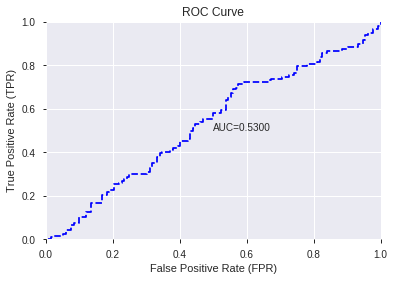

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


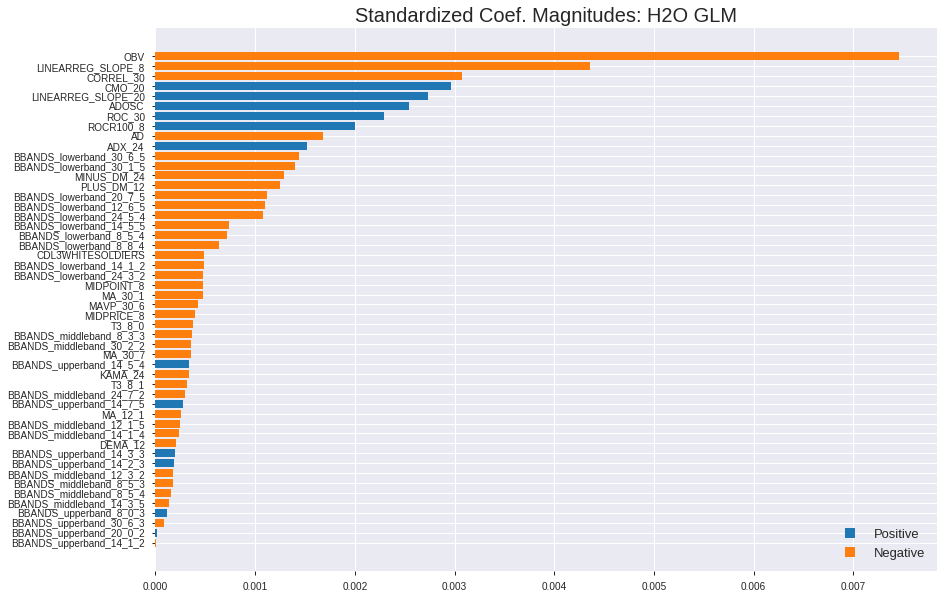

'log_likelihood'
--2019-08-27 20:05:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_200500_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_200500_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['OBV',
 'LINEARREG_SLOPE_8',
 'CORREL_30',
 'CMO_20',
 'LINEARREG_SLOPE_20',
 'ADOSC',
 'ROC_30',
 'ROCR100_8',
 'AD',
 'ADX_24',
 'BBANDS_lowerband_30_6_5',
 'BBANDS_lowerband_30_1_5',
 'MINUS_DM_24',
 'PLUS_DM_12',
 'BBANDS_lowerband_20_7_5',
 'BBANDS_lowerband_12_6_5',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_lowerband_8_8_4',
 'CDL3WHITESOLDIERS',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_lowerband_24_3_2',
 'MIDPOINT_8',
 'MA_30_1',
 'MAVP_30_6',
 'MIDPRICE_8',
 'T3_8_0',
 'BBANDS_middleband_8_3_3',
 'BBANDS_middleband_30_2_2',
 'MA_30_7',
 'BBANDS_upperband_14_5_4',
 'KAMA_24',
 'T3_8_1',
 'BBANDS_middleband_24_7_2',
 'BBANDS_upperband_14_7_5',
 'MA_12_1',
 'BBANDS_middleband_12_1_5',
 'BBANDS_middleband_14_1_4',
 'DEMA_12',
 'BBANDS_upperband_14_3_3',
 'BBANDS_upperband_14_2_3',
 'BBANDS_middleband_12_3_2',
 'BBANDS_middleband_8_5_3',
 'BBANDS_middleband_8_5_4',
 'BBANDS_middleband_14_3_5',
 'BBANDS_upperband_8_0_3',
 'BBANDS_upperb

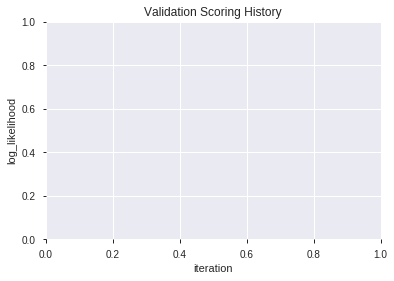

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_200511_model_7  0.570474  0.686657              0.456614  0.496861  0.246871
1               XGBoost_1_AutoML_20190827_200511  0.563280  0.683703              0.474312  0.495409  0.245430
2  XGBoost_grid_1_AutoML_20190827_200511_model_4  0.543545  0.691719              0.492424  0.499354  0.249354
3  XGBoost_grid_1_AutoML_20190827_200511_model_3  0.525337  0.715064              0.500000  0.510091  0.260193
4  XGBoost_grid_1_AutoML_20190827_200511_model_1  0.524637  0.728526              0.488636  0.516271  0.266535
5  XGBoost_grid_1_AutoML_20190827_200511_model_2  0.523873  0.693823              0.470525  0.500390  0.250390
6  XGBoost_grid_1_AutoML_20190827_200511_model_6  0.522409  0.711157              0.443118  0.508656  0.258731
7  XGBoost_grid_1_AutoML_20190827_200511_model_5  0.508340  0.729420              0.500000  0.515814  0.266065
8               XGBoost_2_AutoML_20190827_200511  0.506780  0.704559              0.496212  0.505492  0.255522
9               XGBoost_3_AutoML_20190827_200511  0.504966  0.704061              0.456614  0.505442  0.255472

variable  relative_importance  scaled_importance  percentage
0                      ADOSC           507.614136           1.000000    0.081195
1          LINEARREG_SLOPE_8           383.565338           0.755624    0.061353
2                MINUS_DM_24           379.212219           0.747048    0.060657
3                  ROCR100_8           375.750275           0.740228    0.060103
4                     ROC_30           351.925903           0.693294    0.056292
5                     CMO_20           324.020447           0.638320    0.051828
6                  CORREL_30           292.932220           0.577077    0.046856
7                     ADX_24           291.322266           0.573905    0.046598
8                 PLUS_DM_12           272.282257           0.536396    0.043553
9                        OBV           261.554810           0.515263    0.041837
10        LINEARREG_SLOPE_20           244.800613           0.482257    0.039157
11                        AD           191.024185           0.376318    0.030555
12   BBANDS_lowerband_30_6_5           159.912674           0.315028    0.025579
13    BBANDS_lowerband_8_5_4           152.571899           0.300567    0.024405
14   BBANDS_lowerband_12_6_5           138.856567           0.273547    0.022211
15    BBANDS_lowerband_8_8_4           136.389984           0.268688    0.021816
16   BBANDS_upperband_14_7_5           132.512482           0.261050    0.021196
17   BBANDS_lowerband_24_5_4           120.200005           0.236794    0.019227
18   BBANDS_upperband_14_5_4           105.159500           0.207164    0.016821
19   BBANDS_lowerband_30_1_5            96.362053           0.189833    0.015414
20   BBANDS_lowerband_14_1_2            87.883102           0.173130    0.014057
21   BBANDS_lowerband_14_5_5            81.893005           0.161329    0.013099
22    BBANDS_upperband_8_0_3            78.979080           0.155589    0.012633
23   BBANDS_lowerband_24_3_2            75.880547           0.149485    0.012137
24   BBANDS_lowerband_20_7_5            74.269966           0.146312    0.011880
25                   KAMA_24            73.956703           0.145695    0.011830
26   BBANDS_middleband_8_3_3            73.080582           0.143969    0.011690
27   BBANDS_upperband_14_1_2            71.153770           0.140173    0.011381
28   BBANDS_upperband_30_6_3            69.089333           0.136106    0.011051
29                MIDPRICE_8            66.884811           0.131763    0.010699
30                 MAVP_30_6            65.674347           0.129378    0.010505
31   BBANDS_upperband_20_0_2            60.828041           0.119831    0.009730
32                MIDPOINT_8            59.444920           0.117107    0.009508
33                    T3_8_0            58.784531           0.115806    0.009403
34  BBANDS_middleband_24_7_2            53.508369           0.105412    0.008559
35   BBANDS_upperband_14_3_3            46.856846           0.092308    0.007495
36                   DEMA_12            43.109394           0.084926    0.006896
37   BBANDS_middleband_8_5_3            30.948067           0.060968    0.004950
38   BBANDS_upperband_14_2_3            25.080868           0.049409    0.004012
39                   MA_12_1            22.263361           0.043859    0.003561
40                   MA_30_7            21.733837           0.042816    0.003476
41                    T3_8_1            21.372938           0.042105    0.003419
42                   MA_30_1            20.168463           0.039732    0.003226
43  BBANDS_middleband_30_2_2            14.461261           0.028489    0.002313
44   BBANDS_middleband_8_5_4            13.874250           0.027332    0.002219
45  BBANDS_middleband_14_3_5            13.832162           0.027249    0.002213
46  BBANDS_middleband_12_3_2             8.801775           0.017339    0.001408

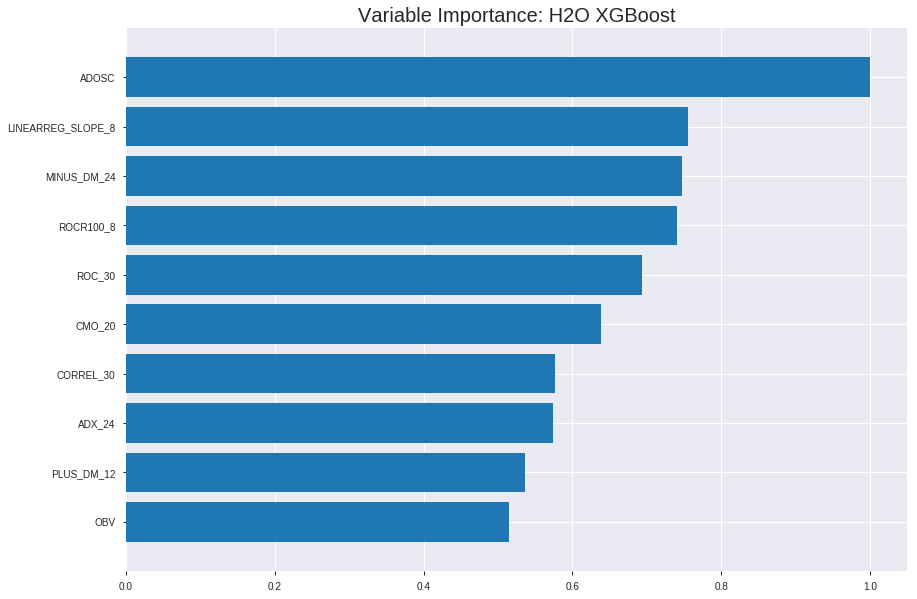

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_200511_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17541691744157
RMSE: 0.4188280284813446
LogLoss: 0.538082565104955
Mean Per-Class Error: 0.15776773923617016
AUC: 0.915359622399749
pr_auc: 0.924271071685209
Gini: 0.830719244799498
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5200821061929067: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      668  150  0.1834   (150.0/818.0)
1      124  811  0.1326   (124.0/935.0)
Total  792  961  0.1563   (274.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520082     0.855485  207
max f2                       0.423748     0.898645  284
max f0point5                 0.574433     0.873533  162
max accuracy                 0.521073     0.843697  206
max precision                0.835648     1         0
max recall                   0.323573     1         357
max specificity              0.835648     1         0
max absolute_mcc             0.521073     0.685694  206
max min_per_class_accuracy   0.530612     0.833741  198
max mean_per_class_accuracy  0.521073     0.842232  206

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.03 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.771744           1.87487    1.87487            1                0.79201   1                           0.79201             0.0192513       0.0192513                  87.4866   87.4866
    2        0.0205362                   0.755163           1.87487    1.87487            1                0.763646  1                           0.777828            0.0192513       0.0385027                  87.4866   87.4866
    3        0.0302339                   0.744611           1.87487    1.87487            1                0.749584  1                           0.768769            0.0181818       0.0566845                  87.4866   87.4866
    4        0.040502                    0.735788           1.87487    1.87487            1                0.739212  1                           0.761275            0.0192513       0.0759358                  87.4866   87.4866
    5        0.0501997                   0.725846           1.65429    1.83226            0.882353         0.730626  0.977273                    0.755354            0.0160428       0.0919786                  65.4294   83.2256
    6        0.100399                    0.694734           1.87487    1.85356            1                0.708505  0.988636                    0.73193             0.0941176       0.186096                   87.4866   85.3561
    7        0.150029                    0.669268           1.81022    1.83922            0.965517         0.682072  0.980989                    0.715437            0.0898396       0.275936                   81.0216   83.9222
    8        0.200228                    0.647016           1.81095    1.83213            0.965909         0.658745  0.977208                    0.701224            0.0909091       0.366845                   81.095    83.2134
    9        0.300057                    0.610787           1.69274    1.78576            0.902857         0.628011  0.952471                    0.676866            0.168984        0.535829                   69.2736   78.5757
    10       0.399886                    0.580236           1.5856     1.73579            0.845714         0.595796  0.92582                     0.656627            0.158289        0.694118                   58.5601   73.5789
    11       0.500285                    0.540214           1.16114    1.62047            0.619318         0.55945   0.86431                     0.637125            0.116578        0.810695                   16.1139   62.0466
    12       0.600114                    0.493666           0.889222   1.49882            0.474286         0.517936  0.79943                     0.617298            0.0887701       0.899465                   -11.0778  49.8824
    13       0.699943                    0.455306           0.439254   1.3477             0.234286         0.473509  0.718826                    0.59679             0.0438503       0.943316                   -56.0746  34.7703
    14       0.799772                    0.407683           0.417827   1.23163            0.222857         0.432522  0.656919                    0.576286            0.0417112       0.985027                   -58.2173  23.1635
    15       0.899601                    0.356254           0.128562   1.10923            0.0685714        0.38248   0.59163                     0.554779            0.0128342       0.997861                   -87.1438  10.9227
    16       1                           0.188251           0.0213053  1                  0.0113636        0.310758  0.533371                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26319428588882865
RMSE: 0.5130246445238559
LogLoss: 0.7202579250111888
Mean Per-Class Error: 0.48660428150237145
AUC: 0.49089860274323804
pr_auc: 0.5199895817144097
Gini: -0.018202794513523912
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2881508469581604: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    230  0.9914   (230.0/232.0)
1      0    269  0        (0.0/269.0)
Total  2    499  0.4591   (230.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.288151     0.700521   397
max f2                       0.288151     0.853968   397
max f0point5                 0.288151     0.593819   397
max accuracy                 0.288151     0.540918   397
max precision                0.49976      0.561224   83
max recall                   0.288151     1          397
max specificity              0.637557     0.99569    0
max absolute_mcc             0.606258     0.0835753  2
max min_per_class_accuracy   0.435944     0.482759   202
max mean_per_class_accuracy  0.399749     0.513396   292

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 44.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.58               0.620818  0.620818           0.333333         0.604836  0.333333                    0.604836            0.00743494      0.00743494                 -37.9182  -37.9182
    2        0.0219561                   0.56654            0.744981  0.677256           0.4              0.57221   0.363636                    0.590006            0.00743494      0.0148699                  -25.5019  -32.2744
    3        0.0319361                   0.560602           1.11747   0.814823           0.6              0.562866  0.4375                      0.581525            0.0111524       0.0260223                  11.7472   -18.5177
    4        0.0419162                   0.551598           0.744981  0.798194           0.4              0.55485   0.428571                    0.575174            0.00743494      0.0334572                  -25.5019  -20.1806
    5        0.0518962                   0.547973           1.11747   0.859594           0.6              0.549342  0.461538                    0.570206            0.0111524       0.0446097                  11.7472   -14.0406
    6        0.101796                    0.522524           1.04297   0.949486           0.56             0.535096  0.509804                    0.552995            0.0520446       0.0966543                  4.2974    -5.05139
    7        0.151697                    0.506997           1.04297   0.980239           0.56             0.515127  0.526316                    0.540539            0.0520446       0.148699                   4.2974    -1.97613
    8        0.201597                    0.499395           1.11747   1.01421            0.6              0.502635  0.544554                    0.531157            0.0557621       0.204461                   11.7472   1.42074
    9        0.301397                    0.479237           0.968476  0.999064           0.52             0.487748  0.536424                    0.516783            0.0966543       0.301115                   -3.15242  -0.0935523
    10       0.401198                    0.456762           0.968476  0.991455           0.52             0.466303  0.532338                    0.504226            0.0966543       0.39777                    -3.15242  -0.854464
    11       0.500998                    0.435638           0.856729  0.964617           0.46             0.443665  0.517928                    0.492162            0.0855019       0.483271                   -14.3271  -3.53826
    12       0.600798                    0.419883           1.00572   0.971446           0.54             0.428376  0.521595                    0.481566            0.100372        0.583643                   0.572491  -2.85541
    13       0.700599                    0.406008           1.15472   0.997553           0.62             0.41252   0.535613                    0.471731            0.115242        0.698885                   15.4721   -0.244654
    14       0.800399                    0.383927           1.08022   1.00786            0.58             0.395212  0.541147                    0.46219             0.107807        0.806691                   8.0223    0.786139
    15       0.9002                      0.363892           0.931227  0.999365           0.5              0.372767  0.536585                    0.452276            0.0929368       0.899628                   -6.87732  -0.063469
    16       1                           0.226762           1.00572   1                  0.54             0.334053  0.536926                  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:05:23  7.381 sec   0                  0.5              0.693147            0.5             0                  1                0.466629                         0.5                0.693147              0.5               0                    1                  0.463074
    2019-08-27 20:05:23  7.527 sec   5                  0.486883         0.667184            0.764221        0.768107           1.66655          0.3166                           0.500824           0.694797              0.502612          0.528871             1.24164            0.459082
    2019-08-27 20:05:23  7.622 sec   10                 0.474917         0.643882            0.813411        0.817549           1.87487          0.272675                         0.5026             0.698384              0.505913          0.546853             1.55204            0.449102
    2019-08-27 20:05:23  7.714 sec   15                 0.464817         0.624457            0.838916        0.844109           1.87487          0.243012                         0.50667            0.706743              0.497989          0.530986             0.931227           0.463074
    2019-08-27 20:05:23  7.812 sec   20                 0.454946         0.605641            0.864743        0.875193           1.87487          0.216201                         0.509764           0.713289              0.498245          0.533316             0.310409           0.461078
    2019-08-27 20:05:23  7.892 sec   25                 0.447889         0.59229             0.87686         0.88492            1.87487          0.198517                         0.516938           0.728744              0.504078          0.529121             0.310409           0.461078
    2019-08-27 20:05:23  7.974 sec   30                 0.441207         0.579604            0.882212        0.890499           1.87487          0.184256                         0.51681            0.728445              0.506345          0.527758             0.620818           0.459082
    2019-08-27 20:05:24  8.059 sec   35                 0.435183         0.568274            0.891507        0.900442           1.87487          0.180262                         0.516797           0.728482              0.507411          0.528231             0.620818           0.45509
    2019-08-27 20:05:24  8.152 sec   40                 0.429495         0.557654            0.899552        0.910218           1.87487          0.179122                         0.515387           0.725312              0.498494          0.521396             0.310409           0.453094
    2019-08-27 20:05:24  8.254 sec   45                 0.422855         0.54536             0.909135        0.918447           1.87487          0.159156                         0.513655           0.721664              0.503798          0.528065             0.620818           0.459082
    2019-08-27 20:05:24  8.328 sec   50                 0.418828         0.538083            0.91536         0.924271           1.87487          0.156303                         0.513025           0.720258              0.490899          0.51999              0.620818           0.459082

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
ADOSC                     507.6141357421875      1.0                   0.08119508328282807
LINEARREG_SLOPE_8         383.5653381347656      0.7556238314245348    0.06135293992300474
MINUS_DM_24               379.21221923828125     0.747048185889921     0.06065663966961775
ROCR100_8                 375.7502746582031      0.7402281540265128    0.06010288661447678
ROC_30                    351.9259033203125      0.6932941353293053    0.05629207505755921
---                       ---                    ---                   ---
MA_30_1                   20.1684627532959       0.03973187768659633   0.0032260331177463267
BBANDS_middleband_30_2_2  14.461260795593262     0.02848868811434755   0.0023131414040629635
BBANDS_middleband_8_5_4   13.874250411987305     0.027332277482189558  0.0022192465464757473
BBANDS_middleband_14_3_5  13.832161903381348     0.027249363107584093  0.002212514306924313
BBANDS_middleband_12_3_2  8.801774978637695      0.01733949935371389   0.0014078820941073426


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5657370517928287)

('F1', 0.6551724137931034)

('auc', 0.5704736440030558)

('logloss', 0.6866566632138098)

('mean_per_class_error', 0.4319136745607334)

('rmse', 0.49686081801973747)

('mse', 0.24687067248324268)

xgboost prediction progress: |████████████████████████████████████████████| 100%


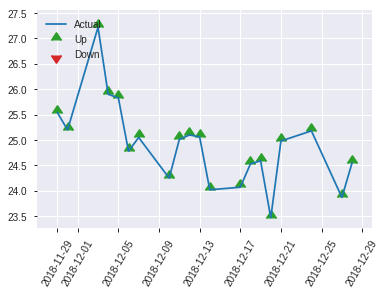


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24687067248324268
RMSE: 0.49686081801973747
LogLoss: 0.6866566632138098
Mean Per-Class Error: 0.4319136745607334
AUC: 0.5704736440030558
pr_auc: 0.5486144863000738
Gini: 0.14094728800611156
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4094403386116028: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   115  0.8712   (115.0/132.0)
1      5    114  0.042    (5.0/119.0)
Total  22   229  0.4781   (120.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40944      0.655172  225
max f2                       0.344633     0.821823  244
max f0point5                 0.40944      0.550725  225
max accuracy                 0.509119     0.565737  128
max precision                0.743768     1         0
max recall                   0.344633     1         244
max specificity              0.743768     1         0
max absolute_mcc             0.40944      0.153217  225
max min_per_class_accuracy   0.515255     0.554622  122
max mean_per_class_accuracy  0.50611      0.568086  134

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 51.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0159363                   0.720688           1.58193   1.58193            0.75             0.732028  0.75                        0.732028            0.0252101       0.0252101                  58.1933   58.1933
    2        0.0239044                   0.716972           2.10924   1.7577             1                0.717009  0.833333                    0.727021            0.0168067       0.0420168                  110.924   75.7703
    3        0.0318725                   0.707012           2.10924   1.84559            1                0.712777  0.875                       0.72346             0.0168067       0.0588235                  110.924   84.5588
    4        0.0438247                   0.698716           0.703081  1.534              0.333333         0.700482  0.727273                    0.717194            0.00840336      0.0672269                  -29.6919  53.3995
    5        0.0517928                   0.693371           2.10924   1.6225             1                0.69729   0.769231                    0.714132            0.0168067       0.0840336                  110.924   62.2495
    6        0.103586                    0.642109           0.973497  1.298              0.461538         0.664016  0.615385                    0.689074            0.0504202       0.134454                   -2.65029  29.7996
    7        0.151394                    0.611185           1.05462   1.22114            0.5              0.623909  0.578947                    0.668495            0.0504202       0.184874                   5.46218   22.1141
    8        0.203187                    0.588877           0.973497  1.15802            0.461538         0.599153  0.54902                     0.65082             0.0504202       0.235294                   -2.65029  15.8016
    9        0.302789                    0.561051           0.843697  1.05462            0.4              0.572655  0.5                         0.625108            0.0840336       0.319328                   -15.6303  5.46218
    10       0.40239                     0.535219           1.26555   1.10683            0.6              0.546421  0.524752                    0.605631            0.12605         0.445378                   26.5546   10.6831
    11       0.501992                    0.513571           1.18118   1.12158            0.56             0.52644   0.531746                    0.589918            0.117647        0.563025                   18.1176   12.1582
    12       0.601594                    0.488522           0.843697  1.07557            0.4              0.500883  0.509934                    0.575177            0.0840336       0.647059                   -15.6303  7.55746
    13       0.701195                    0.460023           0.843697  1.04264            0.4              0.473963  0.494318                    0.5608              0.0840336       0.731092                   -15.6303  4.26375
    14       0.800797                    0.438638           1.09681   1.04937            0.52             0.446998  0.497512                    0.546646            0.109244        0.840336                   9.68067   4.9375
    15       0.900398                    0.412958           0.928067  1.03596            0.44             0.424911  0.49115                     0.533179            0.092437        0.932773                   -7.19328  3.5956
    16       1                           0.32898            0.674958  1                  0.32             0.378296  0.474104                    0.517753           

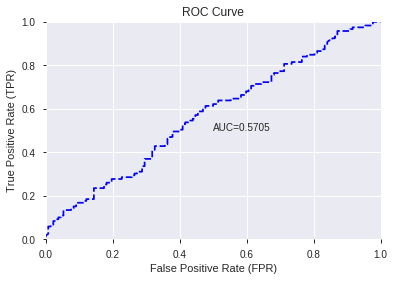

This function is available for GLM models only


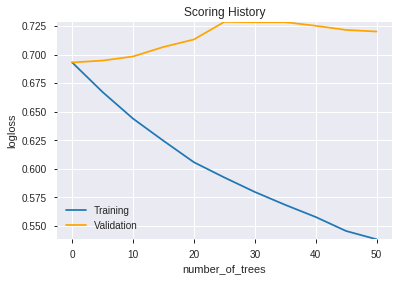

--2019-08-27 20:05:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_200511_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_200511_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['ADOSC',
 'LINEARREG_SLOPE_8',
 'MINUS_DM_24',
 'ROCR100_8',
 'ROC_30',
 'CMO_20',
 'CORREL_30',
 'ADX_24',
 'PLUS_DM_12',
 'OBV',
 'LINEARREG_SLOPE_20',
 'AD',
 'BBANDS_lowerband_30_6_5',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_lowerband_12_6_5',
 'BBANDS_lowerband_8_8_4',
 'BBANDS_upperband_14_7_5',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_upperband_14_5_4',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_upperband_8_0_3',
 'BBANDS_lowerband_24_3_2',
 'BBANDS_lowerband_20_7_5',
 'KAMA_24',
 'BBANDS_middleband_8_3_3',
 'BBANDS_upperband_14_1_2',
 'BBANDS_upperband_30_6_3',
 'MIDPRICE_8',
 'MAVP_30_6',
 'BBANDS_upperband_20_0_2',
 'MIDPOINT_8',
 'T3_8_0',
 'BBANDS_middleband_24_7_2',
 'BBANDS_upperband_14_3_3',
 'DEMA_12',
 'BBANDS_middleband_8_5_3',
 'BBANDS_upperband_14_2_3',
 'MA_12_1',
 'MA_30_7',
 'T3_8_1',
 'MA_30_1',
 'BBANDS_middleband_30_2_2',
 'BBANDS_middleband_8_5_4',
 'BBANDS_middleband_14_3_5',
 'BBANDS_middleband_12_3_2']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_200534_model_1  0.502101  4.306582                   0.5  0.587318  0.344942

variable  relative_importance  scaled_importance  percentage
0               CDLEVENINGSTAR             0.009051           1.000000    0.017184
1                         TANH             0.007094           0.783746    0.013468
2           CDLMORNINGDOJISTAR             0.006210           0.686079    0.011790
3                 CDLENGULFING             0.005577           0.616160    0.010588
4              CDLHOMINGPIGEON             0.005251           0.580199    0.009970
...                        ...                  ...                ...         ...
1035  BBANDS_middleband_20_1_4             0.000000           0.000000    0.000000
1036  BBANDS_middleband_20_1_5             0.000000           0.000000    0.000000
1037  BBANDS_middleband_24_1_4             0.000000           0.000000    0.000000
1038  BBANDS_middleband_24_1_5             0.000000           0.000000    0.000000
1039  BBANDS_middleband_30_5_5             0.000000           0.000000    0.000000

[1040 rows x 4 columns]

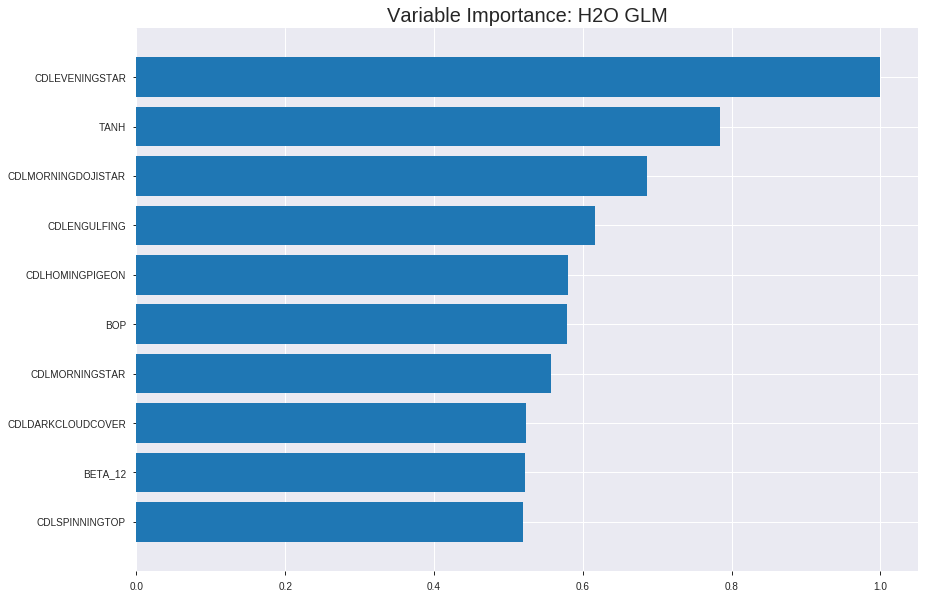

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_200534_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24631685459966146
RMSE: 0.4963031881820441
LogLoss: 0.6857499291598534
Null degrees of freedom: 1752
Residual degrees of freedom: 725
Null deviance: 2422.3593080819073
Residual deviance: 2404.239251634446
AIC: 4460.239251634446
AUC: 0.5886353830262934
pr_auc: 0.610888940384825
Gini: 0.17727076605258674
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4964505357691774: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      31   787   0.9621   (787.0/818.0)
1      11   924   0.0118   (11.0/935.0)
Total  42   1711  0.4552   (798.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496451     0.698413  371
max f2                       0.482276     0.852169  392
max f0point5                 0.525233     0.617949  253
max accuracy                 0.525533     0.590416  251
max precision                0.598508     1         0
max recall                   0.482276     1         392
max specificity              0.598508     1         0
max absolute_mcc             0.525233     0.168844  253
max min_per_class_accuracy   0.53411      0.561125  195
max mean_per_class_accuracy  0.525533     0.576881  251

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.576806           1.56239   1.56239            0.833333         0.584062  0.833333                    0.584062            0.0160428       0.0160428                  56.2389    56.2389
    2        0.0205362                   0.571193           1.45823   1.51031            0.777778         0.573951  0.805556                    0.579007            0.0149733       0.031016                   45.8229    51.0309
    3        0.0302339                   0.565704           0.992576  1.34424            0.529412         0.568168  0.716981                    0.57553             0.00962567      0.0406417                  -0.742372  34.4244
    4        0.040502                    0.562513           1.56239   1.39955            0.833333         0.563911  0.746479                    0.572584            0.0160428       0.0566845                  56.2389    39.9548
    5        0.0501997                   0.560218           1.10286   1.34223            0.588235         0.561435  0.715909                    0.57043             0.0106952       0.0673797                  10.2863    34.2234
    6        0.100399                    0.553826           1.2144    1.27832            0.647727         0.556613  0.681818                    0.563522            0.0609626       0.128342                   21.4402    27.8318
    7        0.150029                    0.550122           0.948208  1.16912            0.505747         0.551773  0.623574                    0.559635            0.0470588       0.175401                   -5.17918   16.9118
    8        0.200228                    0.546785           1.06526   1.14308            0.568182         0.548349  0.609687                    0.556806            0.0534759       0.228877                   6.52649    14.3081
    9        0.300057                    0.541475           1.07135   1.11922            0.571429         0.543917  0.596958                    0.552518            0.106952        0.335829                   7.13522    11.9217
    10       0.399886                    0.537471           1.10349   1.11529            0.588571         0.539506  0.594864                    0.549269            0.11016         0.445989                   10.3493    11.5291
    11       0.500285                    0.534199           1.10788   1.1138             0.590909         0.535762  0.594071                    0.546559            0.11123         0.557219                   10.7876    11.3803
    12       0.600114                    0.530034           1.06064   1.10496            0.565714         0.532112  0.589354                    0.544156            0.105882        0.663102                   6.06387    10.4959
    13       0.699943                    0.525798           1.06064   1.09864            0.565714         0.528047  0.585982                    0.541858            0.105882        0.768984                   6.06387    9.8638
    14       0.799772                    0.519806           0.824941  1.06447            0.44             0.522948  0.56776                     0.539498            0.0823529       0.851337                   -17.5059   6.44747
    15       0.899601                    0.512288           0.782087  1.03314            0.417143         0.516628  0.551046                    0.53696             0.0780749       0.929412                   -21.7913   3.31381
    16       1                           0.451982           0.703075  1                  0.375            0.501218  0.533371                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.39751520996469697
RMSE: 0.6304880728171605
LogLoss: 8.976309399899163
Null degrees of freedom: 500
Residual degrees of freedom: -527
Null deviance: 691.823895750088
Residual deviance: 119536.66075749641
AIC: 121592.66075749641
AUC: 0.5337616972183054
pr_auc: 0.5662364130349946
Gini: 0.0675233944366107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.1740971745689115e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    269  0        (0.0/269.0)
Total  0    501  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.1741e-50   0.698701   294
max f2                       2.1741e-50   0.852885   294
max f0point5                 2.1741e-50   0.591729   294
max accuracy                 7.09239e-24  0.538922   279
max precision                0.577099     1          0
max recall                   2.1741e-50   1          294
max specificity              0.577099     1          0
max absolute_mcc             0.552635     0.0863676  7
max min_per_class_accuracy   0.000259725  0.531599   250
max mean_per_class_accuracy  0.515893     0.536253   120

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 22.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.556066           1.55204   1.55204            0.833333         0.561271      0.833333                    0.561271            0.0185874       0.0185874                  55.2045   55.2045
    2        0.0219561                   0.54797            0.744981  1.1852             0.4              0.550666      0.636364                    0.556451            0.00743494      0.0260223                  -25.5019  18.5198
    3        0.0319361                   0.544449           0.372491  0.931227           0.2              0.546161      0.5                         0.553235            0.00371747      0.0297398                  -62.7509  -6.87732
    4        0.0419162                   0.542292           1.48996   1.06426            0.8              0.543263      0.571429                    0.550861            0.0148699       0.0446097                  48.9963   6.42592
    5        0.0518962                   0.539721           1.11747   1.07449            0.6              0.540748      0.576923                    0.548916            0.0111524       0.0557621                  11.7472   7.44924
    6        0.101796                    0.530548           0.968476  1.02252            0.52             0.535294      0.54902                     0.542238            0.0483271       0.104089                   -3.15242  2.25235
    7        0.151697                    0.524699           1.26647   1.10277            0.68             0.527738      0.592105                    0.537468            0.063197        0.167286                   26.6468   10.2769
    8        0.201597                    0.519707           1.11747   1.10641            0.6              0.522123      0.594059                    0.53367             0.0557621       0.223048                   11.7472   10.6408
    9        0.301397                    0.50836            1.00572   1.07307            0.54             0.514577      0.576159                    0.527348            0.100372        0.32342                    0.572491  7.30693
    10       0.401198                    0.425695           1.04297   1.06558            0.56             0.487642      0.572139                    0.517471            0.104089        0.427509                   4.2974    6.55829
    11       0.500998                    0.000259725        1.04297   1.06108            0.56             0.174261      0.569721                    0.449102            0.104089        0.531599                   4.2974    6.10791
    12       0.600798                    6.64103e-60        0.931227  1.03951            0.5              1.24041e-05   0.55814                     0.374503            0.0929368       0.624535                   -6.87732  3.95089
    13       0.700599                    1.16683e-233       1.19197   1.06123            0.64             3.29168e-62   0.569801                    0.321155            0.118959        0.743494                   19.197    6.12271
    14       1                           0                  0.856729  1                  0.46             7.66204e-236  0.536926                    0.225001            0.256506        1                          -14.3271  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:05:38  0.000 sec   2            3.9       1028          1.3715            238.596
    2019-08-27 20:05:40  2.180 sec   4            2.8       1032          1.36875           255.41
    2019-08-27 20:05:42  4.406 sec   6            2.1       1033          1.36549           269.755
    2019-08-27 20:05:44  6.681 sec   8            1.5       1034          1.3617            281.263
    2019-08-27 20:05:47  8.910 sec   10           1.1       1036          1.35741           291.169

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6432432432432432)

('auc', 0.5021008403361344)

('logloss', 4.306582238343773)

('mean_per_class_error', 0.4678826075884899)

('rmse', 0.5873177999094504)

('mse', 0.34494219809047727)

glm prediction progress: |████████████████████████████████████████████████| 100%


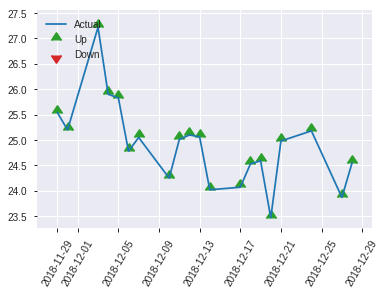


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.34494219809047727
RMSE: 0.5873177999094504
LogLoss: 4.306582238343773
Null degrees of freedom: 250
Residual degrees of freedom: -777
Null deviance: 350.81837939662717
Residual deviance: 21339.765459254122
AIC: 23395.765459254122
AUC: 0.5021008403361344
pr_auc: 0.48866122874920637
Gini: 0.004201680672268893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.3184700463284635e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    119  0        (0.0/119.0)
Total  0    251  0.5259   (132.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.31847e-51  0.643243  212
max f2                       3.31847e-51  0.818432  212
max f0point5                 3.32875e-29  0.53102   207
max accuracy                 0.562835     0.541833  7
max precision                0.562835     0.75      7
max recall                   3.31847e-51  1         212
max specificity              0.582687     0.992424  0
max absolute_mcc             0.562835     0.100254  7
max min_per_class_accuracy   0.491396     0.478992  123
max mean_per_class_accuracy  0.511858     0.532117  77

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 30.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.577512           1.40616   1.40616            0.666667         0.580302     0.666667                    0.580302            0.0168067       0.0168067                  40.6162   40.6162
    2        0.0239044                   0.57057            1.40616   1.40616            0.666667         0.574263     0.666667                    0.577282            0.0168067       0.0336134                  40.6162   40.6162
    3        0.0318725                   0.561876           2.10924   1.58193            1                0.565325     0.75                        0.574293            0.0168067       0.0504202                  110.924   58.1933
    4        0.0438247                   0.559157           0.703081  1.34225            0.333333         0.560141     0.636364                    0.570433            0.00840336      0.0588235                  -29.6919  34.2246
    5        0.0517928                   0.554778           1.05462   1.298              0.5              0.55589      0.615385                    0.568196            0.00840336      0.0672269                  5.46218   29.7996
    6        0.103586                    0.536162           0.811248  1.05462            0.384615         0.546716     0.5                         0.557456            0.0420168       0.109244                   -18.8752  5.46218
    7        0.151394                    0.529347           0.878852  0.999115           0.416667         0.532034     0.473684                    0.549428            0.0420168       0.151261                   -12.1148  -0.0884564
    8        0.203187                    0.519547           0.973497  0.992585           0.461538         0.523822     0.470588                    0.542901            0.0504202       0.201681                   -2.65029  -0.741473
    9        0.302789                    0.513359           1.26555   1.08238            0.6              0.515978     0.513158                    0.534045            0.12605         0.327731                   26.5546   8.23751
    10       0.40239                     0.505431           0.843697  1.0233             0.4              0.509287     0.485149                    0.527917            0.0840336       0.411765                   -15.6303  2.32964
    11       0.501992                    0.49013            0.674958  0.954182           0.32             0.498751     0.452381                    0.52213             0.0672269       0.478992                   -32.5042  -4.58183
    12       0.601594                    0.208132           1.09681   0.977795           0.52             0.369805     0.463576                    0.496911            0.109244        0.588235                   9.68067   -2.22049
    13       0.701195                    0.0116652          1.18118   1.00668            0.56             0.0665312    0.477273                    0.435777            0.117647        0.705882                   18.1176   0.668449
    14       0.800797                    5.02388e-13        0.928067  0.996906           0.44             0.00248799   0.472637                    0.381885            0.092437        0.798319                   -7.19328  -0.309377
    15       1                           0                  1.01244   1                  0.48             5.97836e-16  0.474104                    0.305813            0.201681        1                          1.2437    0

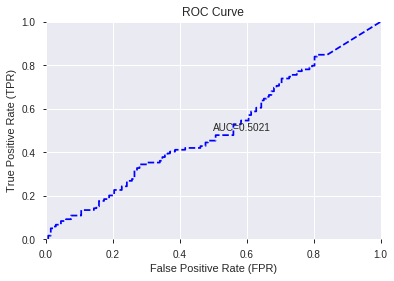

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


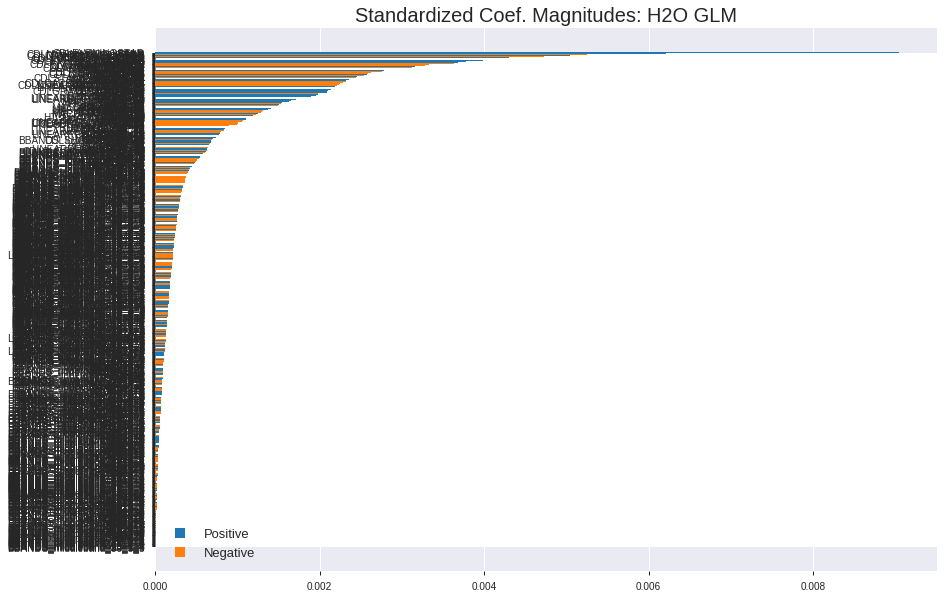

'log_likelihood'
--2019-08-27 20:06:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_200534_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_200534_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

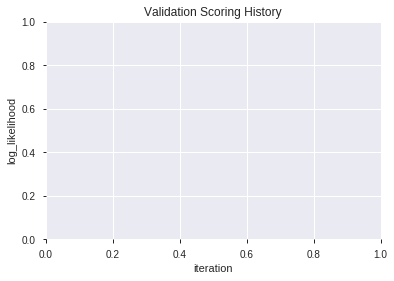

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_200619_model_5  0.508658  0.718926              0.496212  0.512085  0.262231
1  XGBoost_grid_1_AutoML_20190827_200619_model_4  0.502801  0.708553              0.500000  0.507323  0.257376
2  XGBoost_grid_1_AutoML_20190827_200619_model_7  0.501846  0.710448              0.496212  0.508054  0.258119
3  XGBoost_grid_1_AutoML_20190827_200619_model_3  0.494461  0.707766              0.500000  0.506926  0.256974
4  XGBoost_grid_1_AutoML_20190827_200619_model_2  0.481029  0.703159              0.500000  0.504907  0.254931
5  XGBoost_grid_1_AutoML_20190827_200619_model_6  0.472052  0.719912              0.500000  0.512481  0.262637
6               XGBoost_2_AutoML_20190827_200619  0.471225  0.713001              0.477687  0.509690  0.259784
7               XGBoost_1_AutoML_20190827_200619  0.468487  0.720927              0.500000  0.513303  0.263480
8               XGBoost_3_AutoML_20190827_200619  0.452636  0.715522              0.496212  0.510898  0.261017
9  XGBoost_grid_1_AutoML_20190827_200619_model_1  0.445442  0.732066              0.500000  0.518243  0.268575

variable  relative_importance  scaled_importance  percentage
0                    Volume           454.160034           1.000000    0.019461
1                       day           386.371216           0.850738    0.016556
2                      Open           331.687317           0.730331    0.014213
3                 dayofyear           328.388947           0.723069    0.014072
4                       BOP           279.845337           0.616182    0.011991
..                      ...                  ...                ...         ...
553            LINEARREG_24             0.955021           0.002103    0.000041
554                MAVP_8_6             0.950331           0.002093    0.000041
555               MAVP_20_3             0.792225           0.001744    0.000034
556                  MA_8_5             0.454556           0.001001    0.000019
557  BBANDS_lowerband_8_3_3             0.270433           0.000595    0.000012

[558 rows x 4 columns]

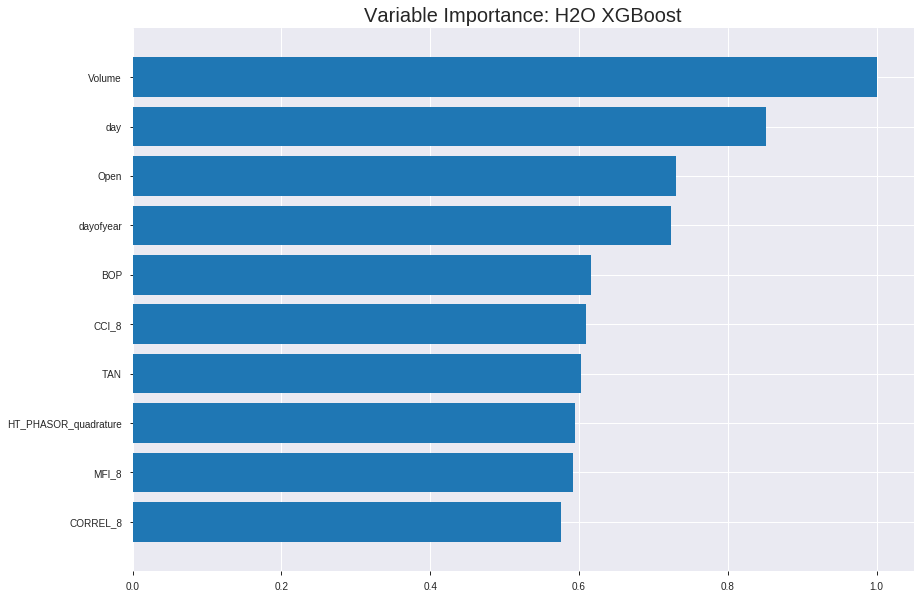

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_200619_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.044206005640824005
RMSE: 0.21025224289130426
LogLoss: 0.22588321666506714
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9946524064171123
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5658988952636719: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      818  0    0        (0.0/818.0)
1      0    935  0        (0.0/935.0)
Total  818  935  0        (0.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.565899     1        207
max f2                       0.565899     1        207
max f0point5                 0.565899     1        207
max accuracy                 0.565899     1        207
max precision                0.931613     1        0
max recall                   0.565899     1        207
max specificity              0.931613     1        0
max absolute_mcc             0.565899     1        207
max min_per_class_accuracy   0.565899     1        207
max mean_per_class_accuracy  0.565899     1        207

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.916746           1.87487   1.87487            1                0.925077  1                           0.925077            0.0192513       0.0192513                  87.4866   87.4866
    2        0.0205362                   0.908603           1.87487   1.87487            1                0.912576  1                           0.918827            0.0192513       0.0385027                  87.4866   87.4866
    3        0.0302339                   0.90029            1.87487   1.87487            1                0.90381   1                           0.91401             0.0181818       0.0566845                  87.4866   87.4866
    4        0.040502                    0.894047           1.87487   1.87487            1                0.897712  1                           0.909878            0.0192513       0.0759358                  87.4866   87.4866
    5        0.0501997                   0.888732           1.87487   1.87487            1                0.891323  1                           0.906294            0.0181818       0.0941176                  87.4866   87.4866
    6        0.100399                    0.868942           1.87487   1.87487            1                0.877646  1                           0.89197             0.0941176       0.188235                   87.4866   87.4866
    7        0.150029                    0.852915           1.87487   1.87487            1                0.861208  1                           0.881794            0.0930481       0.281283                   87.4866   87.4866
    8        0.200228                    0.838059           1.87487   1.87487            1                0.845023  1                           0.872575            0.0941176       0.375401                   87.4866   87.4866
    9        0.300057                    0.810967           1.87487   1.87487            1                0.824936  1                           0.856726            0.187166        0.562567                   87.4866   87.4866
    10       0.399886                    0.775059           1.87487   1.87487            1                0.792285  1                           0.840638            0.187166        0.749733                   87.4866   87.4866
    11       0.500285                    0.696623           1.87487   1.87487            1                0.744272  1                           0.821299            0.188235        0.937968                   87.4866   87.4866
    12       0.600114                    0.281274           0.621384  1.66635            0.331429         0.437121  0.888783                    0.757391            0.0620321       1                          -37.8616  66.635
    13       0.699943                    0.230912           0         1.42869            0                0.252574  0.762021                    0.685392            0               1                          -100      42.8688
    14       0.799772                    0.189816           0         1.25036            0                0.210207  0.666904                    0.626079            0               1                          -100      25.0357
    15       0.899601                    0.154208           0         1.1116             0                0.171878  0.592898                    0.575676            0               1                          -100      11.1604
    16       1                           0.0810934          0         1                  0                0.13001   0.533371                    0.530931          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2686488580411277
RMSE: 0.518313474686051
LogLoss: 0.7342625320474525
Mean Per-Class Error: 0.4757883604666069
AUC: 0.5028521984360979
pr_auc: 0.5500253734520001
Gini: 0.005704396872195705
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10475760698318481: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    269  0        (0.0/269.0)
Total  0    501  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.104758     0.698701   399
max f2                       0.104758     0.852885   399
max f0point5                 0.283405     0.593299   373
max accuracy                 0.283405     0.542914   373
max precision                0.821481     1          0
max recall                   0.104758     1          399
max specificity              0.821481     1          0
max absolute_mcc             0.656669     0.0723966  31
max min_per_class_accuracy   0.446005     0.486989   201
max mean_per_class_accuracy  0.543806     0.524212   106

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 45.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.729452           1.24164   1.24164            0.666667         0.767772  0.666667                    0.767772            0.0148699       0.0148699                  24.1636   24.1636
    2        0.0219561                   0.709264           1.11747   1.1852             0.6              0.716437  0.636364                    0.744438            0.0111524       0.0260223                  11.7472   18.5198
    3        0.0319361                   0.696762           1.11747   1.16403            0.6              0.698728  0.625                       0.730153            0.0111524       0.0371747                  11.7472   16.4033
    4        0.0419162                   0.68939            1.11747   1.15295            0.6              0.690814  0.619048                    0.720787            0.0111524       0.0483271                  11.7472   15.2947
    5        0.0518962                   0.675794           1.48996   1.21776            0.8              0.678335  0.653846                    0.712623            0.0148699       0.063197                   48.9963   21.7758
    6        0.101796                    0.62622            0.893978  1.05904            0.48             0.650184  0.568627                    0.682016            0.0446097       0.107807                   -10.6022  5.90422
    7        0.151697                    0.584753           0.968476  1.02925            0.52             0.606651  0.552632                    0.657225            0.0483271       0.156134                   -3.15242  2.92506
    8        0.201597                    0.563096           1.19197   1.06953            0.64             0.574346  0.574257                    0.63671             0.0594796       0.215613                   19.197    6.95278
    9        0.301397                    0.515091           0.893978  1.0114             0.48             0.538376  0.543046                    0.604149            0.0892193       0.304833                   -10.6022  1.13986
    10       0.401198                    0.47299            1.00572   1.00999            0.54             0.494719  0.542289                    0.576928            0.100372        0.405204                   0.572491  0.998724
    11       0.500998                    0.445815           0.81948   0.972038           0.44             0.459054  0.521912                    0.553447            0.0817844       0.486989                   -18.052   -2.79625
    12       0.600798                    0.416059           1.15472   1.00238            0.62             0.431151  0.538206                    0.533132            0.115242        0.60223                    15.4721   0.238363
    13       0.700599                    0.382106           0.968476  0.997553           0.52             0.398289  0.535613                    0.513923            0.0966543       0.698885                   -3.15242  -0.244654
    14       0.800399                    0.342298           0.968476  0.993928           0.52             0.363887  0.533666                    0.495216            0.0966543       0.795539                   -3.15242  -0.607218
    15       0.9002                      0.311674           1.08022   1.00349            0.58             0.325598  0.538803                    0.476411            0.107807        0.903346                   8.0223    0.349492
    16       1                           0.104758           0.968476  1                  0.52             0.266653  0.536926                    0.455477 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:06:56  19.271 sec  0                  0.5              0.693147            0.5             0                  1                0.466629                         0.5                0.693147              0.5               0                    1                  0.463074
    2019-08-27 20:06:58  21.002 sec  5                  0.454978         0.606558            0.957544        0.963295           1.87487          0.111238                         0.501066           0.695292              0.523683          0.55074              0.931227           0.461078
    2019-08-27 20:06:59  21.734 sec  10                 0.414626         0.534027            0.987087        0.988282           1.87487          0.0496292                        0.506091           0.705635              0.498422          0.535822             0.931227           0.463074
    2019-08-27 20:07:00  22.573 sec  15                 0.374769         0.466549            0.996444        0.995977           1.87487          0.0245294                        0.506289           0.706237              0.504927          0.541917             0.931227           0.463074
    2019-08-27 20:07:01  23.396 sec  20                 0.338099         0.407839            0.998901        0.997852           1.87487          0.0125499                        0.50817            0.710311              0.497588          0.547899             0.931227           0.463074
    2019-08-27 20:07:01  24.221 sec  25                 0.307214         0.360832            0.99978         0.998732           1.87487          0.00399315                       0.508355           0.710879              0.499455          0.55218              0.931227           0.463074
    2019-08-27 20:07:02  25.020 sec  30                 0.285475         0.329003            0.99995         0.998887           1.87487          0.00285225                       0.511579           0.717918              0.499047          0.550048             0.931227           0.463074
    2019-08-27 20:07:03  25.743 sec  35                 0.263944         0.298193            0.999988        0.997851           1.87487          0.00171135                       0.513375           0.722066              0.495289          0.552571             1.24164            0.463074
    2019-08-27 20:07:04  26.619 sec  40                 0.241625         0.267303            1               0.99893            1.87487          0                                0.516686           0.729772              0.498734          0.548673             1.24164            0.463074
    2019-08-27 20:07:05  27.425 sec  45                 0.224235         0.244096            1               0.99893            1.87487          0                                0.516995           0.730898              0.505047          0.554677             1.24164            0.463074
    2019-08-27 20:07:05  28.236 sec  50                 0.210252         0.225883            1               0.994652           1.87487          0                                0.518313           0.734263              0.502852          0.550025             1.24164            0.463074

Variable Importances: 


variable                relative_importance    scaled_importance      percentage
----------------------  ---------------------  ---------------------  ----------------------
Volume                  454.1600341796875      1.0                    0.019460891553519967
day                     386.3712158203125      0.8507380366882866     0.016556120672445235
Open                    331.68731689453125     0.7303313632465067     0.014212899458274664
dayofyear               328.3889465332031      0.723068790335868      0.014071563314461194
BOP                     279.8453369140625      0.616182217397276      0.011991455309975852
---                     ---                    ---                    ---
LINEARREG_24            0.95502108335495       0.0021028294246100434  4.092293538788684e-05
MAVP_8_6                0.950331449508667      0.002092503474519007   4.072198319297812e-05
MAVP_20_3               0.7922245860099792     0.0017443731865154325  3.394705741164489e-05
MA_8_5                  0.45455577969551086    0.0010008713789986788  1.9477849365715266e-05
BBANDS_lowerband_8_3_3  0.27043312788009644    0.0005954577847620562  1.158813937395361e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6449864498644986)

('auc', 0.5086580086580086)

('logloss', 0.7189259372101849)

('mean_per_class_error', 0.4589381207028266)

('rmse', 0.5120852188912035)

('mse', 0.2622312714068518)

xgboost prediction progress: |████████████████████████████████████████████| 100%


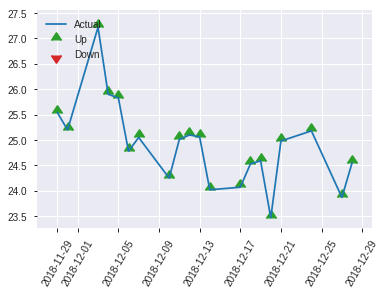


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2622312714068518
RMSE: 0.5120852188912035
LogLoss: 0.7189259372101849
Mean Per-Class Error: 0.4589381207028266
AUC: 0.5086580086580086
pr_auc: 0.5081648105258553
Gini: 0.017316017316017174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3030230402946472: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    131  0.9924   (131.0/132.0)
1      0    119  0        (0.0/119.0)
Total  1    250  0.5219   (131.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303023     0.644986  249
max f2                       0.303023     0.819559  249
max f0point5                 0.303023     0.531725  249
max accuracy                 0.676179     0.557769  29
max precision                0.803331     1         0
max recall                   0.303023     1         249
max specificity              0.803331     1         0
max absolute_mcc             0.386871     0.125395  226
max min_per_class_accuracy   0.516365     0.515152  125
max mean_per_class_accuracy  0.654049     0.541062  43

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 52.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.769536           1.40616   1.40616            0.666667         0.787437  0.666667                    0.787437            0.0168067       0.0168067                  40.6162   40.6162
    2        0.0239044                   0.756241           2.10924   1.7577             1                0.760494  0.833333                    0.773965            0.0252101       0.0420168                  110.924   75.7703
    3        0.0318725                   0.748077           1.05462   1.58193            0.5              0.749343  0.75                        0.76781             0.00840336      0.0504202                  5.46218   58.1933
    4        0.0438247                   0.732072           0.703081  1.34225            0.333333         0.74177   0.636364                    0.760708            0.00840336      0.0588235                  -29.6919  34.2246
    5        0.0517928                   0.718228           0         1.13575            0                0.722603  0.538462                    0.754846            0               0.0588235                  -100      13.5747
    6        0.103586                    0.680704           1.298     1.21687            0.615385         0.70161   0.576923                    0.728228            0.0672269       0.12605                    29.7996   21.6871
    7        0.151394                    0.657924           1.23039   1.22114            0.583333         0.66966   0.578947                    0.709733            0.0588235       0.184874                   23.0392   22.1141
    8        0.203187                    0.639657           0.973497  1.15802            0.461538         0.648716  0.54902                     0.694179            0.0504202       0.235294                   -2.65029  15.8016
    9        0.302789                    0.595811           0.928067  1.08238            0.44             0.61729   0.513158                    0.668887            0.092437        0.327731                   -7.19328  8.23751
    10       0.40239                     0.548532           0.843697  1.0233             0.4              0.571339  0.485149                    0.644741            0.0840336       0.411765                   -15.6303  2.32964
    11       0.501992                    0.516365           1.09681   1.03788            0.52             0.530479  0.492063                    0.62207             0.109244        0.521008                   9.68067   3.78818
    12       0.601594                    0.485451           0.759328  0.991764           0.36             0.499451  0.470199                    0.601769            0.0756303       0.596639                   -24.0672  -0.823641
    13       0.701195                    0.45551            0.928067  0.982716           0.44             0.472166  0.465909                    0.583359            0.092437        0.689076                   -7.19328  -1.72842
    14       0.800797                    0.428288           0.928067  0.975919           0.44             0.442181  0.462687                    0.5658              0.092437        0.781513                   -7.19328  -2.40813
    15       0.900398                    0.390633           0.843697  0.961292           0.4              0.40737   0.455752                    0.548274            0.0840336       0.865546                   -15.6303  -3.87075
    16       1                           0.247376           1.34992   1                  0.64             0.350291  0.474104                    0.528555    

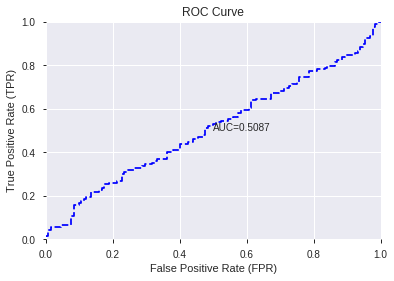

This function is available for GLM models only


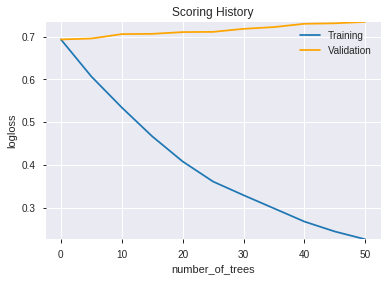

--2019-08-27 20:07:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_200619_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_200619_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_200730_model_4  0.544850  0.704017              0.492424  0.504606  0.254627
1  DeepLearning_grid_1_AutoML_20190827_200730_model_6  0.529348  0.708562              0.470111  0.507561  0.257618
2  DeepLearning_grid_1_AutoML_20190827_200730_model_1  0.528584  1.150608              0.492424  0.608728  0.370550
3               DeepLearning_1_AutoML_20190827_200730  0.526356  0.886794              0.496212  0.572770  0.328065
4  DeepLearning_grid_1_AutoML_20190827_200730_model_7  0.512573  0.689713              0.446492  0.498342  0.248345
5  DeepLearning_grid_1_AutoML_20190827_200730_model_2  0.500255  0.849338              0.492424  0.556142  0.309294
6  DeepLearning_grid_1_AutoML_20190827_200730_model_5  0.500127  0.693026              0.492424  0.499939  0.249939
7  DeepLearning_grid_1_AutoML_20190827_200730_model_8  0.500000  0.697107              0.500000  0.501974  0.251978
8  DeepLearning_grid_1_AutoML_20190827_200730_model_3  0.496753  0.739925              0.500000  0.520112  0.270517
9  DeepLearning_grid_1_AutoML_20190827_200730_model_9  0.479756  0.697874              0.500000  0.502355  0.252360

variable  relative_importance  scaled_importance  percentage
0          CDL3WHITESOLDIERS             1.000000           1.000000    0.082075
1                        OBV             0.351832           0.351832    0.028877
2          LINEARREG_SLOPE_8             0.312465           0.312465    0.025646
3                 PLUS_DM_12             0.256371           0.256371    0.021042
4                     ADX_24             0.248795           0.248795    0.020420
5                MINUS_DM_24             0.246458           0.246458    0.020228
6         LINEARREG_SLOPE_20             0.236272           0.236272    0.019392
7                  CORREL_30             0.235035           0.235035    0.019291
8                     ROC_30             0.234284           0.234284    0.019229
9                         AD             0.233920           0.233920    0.019199
10    BBANDS_upperband_8_0_3             0.230311           0.230311    0.018903
11                   MA_30_7             0.229796           0.229796    0.018860
12                    T3_8_0             0.229479           0.229479    0.018834
13                 ROCR100_8             0.229195           0.229195    0.018811
14   BBANDS_middleband_8_3_3             0.227603           0.227603    0.018681
15    BBANDS_lowerband_8_5_4             0.227463           0.227463    0.018669
16   BBANDS_upperband_30_6_3             0.226684           0.226684    0.018605
17   BBANDS_upperband_20_0_2             0.226316           0.226316    0.018575
18    BBANDS_lowerband_8_8_4             0.225848           0.225848    0.018536
19                     ADOSC             0.225454           0.225454    0.018504
20   BBANDS_lowerband_12_6_5             0.225209           0.225209    0.018484
21                MIDPOINT_8             0.225159           0.225159    0.018480
22   BBANDS_lowerband_30_1_5             0.225057           0.225057    0.018472
23                   KAMA_24             0.224943           0.224943    0.018462
24  BBANDS_middleband_14_3_5             0.224939           0.224939    0.018462
25  BBANDS_middleband_24_7_2             0.224761           0.224761    0.018447
26  BBANDS_middleband_12_3_2             0.223523           0.223523    0.018346
27   BBANDS_upperband_14_5_4             0.223492           0.223492    0.018343
28  BBANDS_middleband_30_2_2             0.222662           0.222662    0.018275
29   BBANDS_upperband_14_7_5             0.222273           0.222273    0.018243
30                    T3_8_1             0.222072           0.222072    0.018227
31   BBANDS_upperband_14_1_2             0.221907           0.221907    0.018213
32                   DEMA_12             0.221432           0.221432    0.018174
33                   MA_12_1             0.221345           0.221345    0.018167
34   BBANDS_lowerband_20_7_5             0.220506           0.220506    0.018098
35  BBANDS_middleband_14_1_4             0.220072           0.220072    0.018062
36   BBANDS_lowerband_14_5_5             0.218989           0.218989    0.017973
37                 MAVP_30_6             0.218988           0.218988    0.017973
38  BBANDS_middleband_12_1_5             0.218924           0.218924    0.017968
39   BBANDS_lowerband_30_6_5             0.218510           0.218510    0.017934
40   BBANDS_upperband_14_3_3             0.217468           0.217468    0.017849
41   BBANDS_upperband_14_2_3             0.217220           0.217220    0.017828
42   BBANDS_lowerband_14_1_2             0.217079           0.217079    0.017817
43                MIDPRICE_8             0.217045           0.217045    0.017814
44   BBANDS_middleband_8_5_4             0.212977           0.212977    0.017480
45                   MA_30_1             0.212341           0.212341    0.017428
46   BBANDS_middleband_8_5_3             0.209593           0.209593    0.017202
47   BBANDS_lowerband_24_3_2             0.207154           0.207154    0.017002
48   BBANDS_lowerband_24_5_4             0.201850  

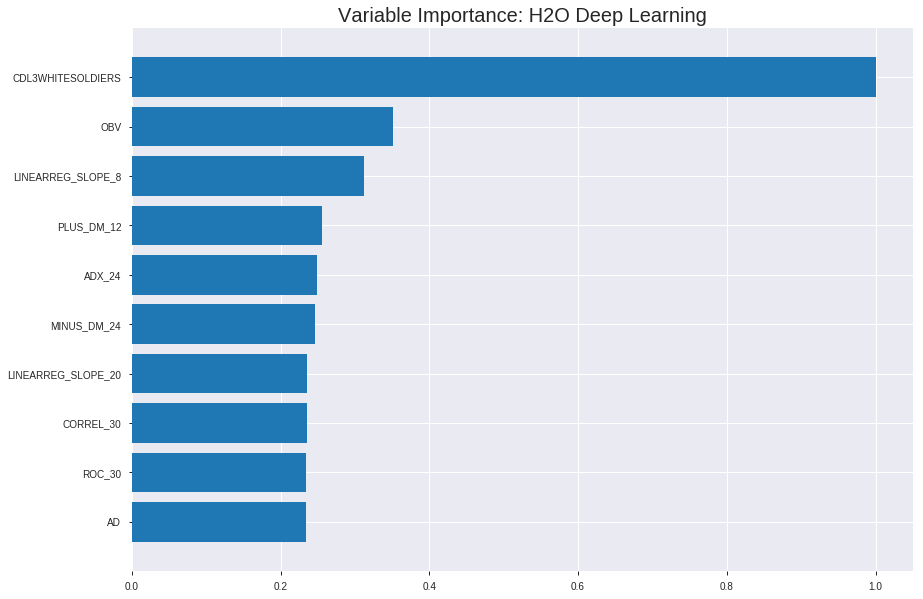

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_200730_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24401027870191772
RMSE: 0.4939739656114659
LogLoss: 0.683461077819146
Mean Per-Class Error: 0.4217257429755632
AUC: 0.6013297072552071
pr_auc: 0.6262762757257699
Gini: 0.20265941451041414
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47685269442781597: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      65   753   0.9205   (753.0/818.0)
1      22   913   0.0235   (22.0/935.0)
Total  87   1666  0.4421   (775.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476853     0.702038  352
max f2                       0.40228      0.853725  384
max f0point5                 0.533472     0.608566  296
max accuracy                 0.562827     0.577867  251
max precision                0.939302     0.9375    10
max recall                   0.40228      1         384
max specificity              0.99519      0.998778  0
max absolute_mcc             0.572986     0.15642   238
max min_per_class_accuracy   0.566779     0.576471  247
max mean_per_class_accuracy  0.572986     0.578274  238

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 59.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.924996           1.66655   1.66655            0.888889         0.954129  0.888889                    0.954129            0.0171123       0.0171123                  66.6548   66.6548
    2        0.0205362                   0.889407           1.35407   1.51031            0.722222         0.903673  0.805556                    0.928901            0.0139037       0.031016                   35.407    51.0309
    3        0.0302339                   0.85595            1.32344   1.45037            0.705882         0.87232   0.773585                    0.910752            0.0128342       0.0438503                  32.3435   45.0368
    4        0.040502                    0.833875           1.56239   1.47877            0.833333         0.844935  0.788732                    0.894066            0.0160428       0.059893                   56.2389   47.8768
    5        0.0501997                   0.812138           1.21315   1.42746            0.647059         0.823063  0.761364                    0.88035             0.0117647       0.0716578                  21.3149   42.7455
    6        0.100399                    0.72349            1.1931    1.31028            0.636364         0.760243  0.698864                    0.820296            0.059893        0.131551                   19.3097   31.0276
    7        0.150029                    0.677065           1.07751   1.23328            0.574713         0.697857  0.657795                    0.779794            0.0534759       0.185027                   7.75094   23.3277
    8        0.200228                    0.653732           1.25701   1.23923            0.670455         0.66393   0.660969                    0.750745            0.0631016       0.248128                   25.7013   23.9228
    9        0.300057                    0.618421           1.11421   1.19763            0.594286         0.635389  0.638783                    0.712366            0.11123         0.359358                   11.4206   19.7633
    10       0.399886                    0.591789           1.0285    1.15541            0.548571         0.604709  0.616262                    0.68549             0.102674        0.462032                   2.84981   15.541
    11       0.500285                    0.567442           1.08657   1.14159            0.579545         0.578911  0.608894                    0.664102            0.109091        0.571123                   8.65702   14.1595
    12       0.600114                    0.549027           0.921363  1.10496            0.491429         0.557201  0.589354                    0.646319            0.0919786       0.663102                   -7.86371  10.4959
    13       0.699943                    0.536493           0.932076  1.0803             0.497143         0.542869  0.576202                    0.631564            0.0930481       0.75615                    -6.79236  8.03019
    14       0.845408                    0.530726           0.896995  1.04876            0.478431         0.531726  0.559379                    0.614386            0.130481        0.886631                   -10.3005  4.87612
    15       0.899601                    0.505027           0.90783   1.04027            0.484211         0.519084  0.554851                    0.608645            0.0491979       0.935829                   -9.217    4.02714
    16       1                           0.0941563          0.639159  1                  0.340909         0.455825  0.533371                    0.593302          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24941980323299875
RMSE: 0.4994194662135215
LogLoss: 0.6921641820197866
Mean Per-Class Error: 0.4861315856941417
AUC: 0.5127387514421228
pr_auc: 0.5531484550896267
Gini: 0.02547750288424555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.530726390864801: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    269  0        (0.0/269.0)
Total  0    501  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.530726     0.698701   137
max f2                       0.530726     0.852885   137
max f0point5                 0.530726     0.591729   137
max accuracy                 0.530726     0.536926   137
max precision                0.94343      1          0
max recall                   0.530726     1          137
max specificity              0.94343      1          0
max absolute_mcc             0.855602     0.0720798  2
max min_per_class_accuracy   0.530843     0.286245   136
max mean_per_class_accuracy  0.53797      0.513868   95

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 54.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.747867           0.931227  0.931227           0.5              0.849489  0.5                         0.849489            0.0111524       0.0111524                  -6.87732  -6.87732
    2        0.0219561                   0.659661           1.11747   1.01588            0.6              0.683235  0.545455                    0.773919            0.0111524       0.0223048                  11.7472   1.58837
    3        0.0319361                   0.627949           1.11747   1.04763            0.6              0.631539  0.5625                      0.729425            0.0111524       0.0334572                  11.7472   4.76301
    4        0.0419162                   0.615955           1.11747   1.06426            0.6              0.619947  0.571429                    0.703359            0.0111524       0.0446097                  11.7472   6.42592
    5        0.0518962                   0.601554           1.11747   1.07449            0.6              0.606566  0.576923                    0.684745            0.0111524       0.0557621                  11.7472   7.44924
    6        0.101796                    0.557937           0.893978  0.986005           0.48             0.573277  0.529412                    0.630104            0.0446097       0.100372                   -10.6022  -1.39952
    7        0.151697                    0.545783           1.04297   1.00474            0.56             0.550689  0.539474                    0.603981            0.0520446       0.152416                   4.2974    0.474467
    8        0.201597                    0.536777           1.19197   1.05109            0.64             0.54037   0.564356                    0.588235            0.0594796       0.211896                   19.197    5.10876
    9        1                           0.530726           0.9871    1                  0.53             0.531008  0.536926                    0.542545            0.788104        1                          -1.28996  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:10:25  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:10:31  6.764 sec         279 obs/sec       0.970337  1             1701       0.645954         1.55542             -0.676495      0.515552        0.544065           1.14575          0.466629                         0.610031           1.32489               -0.496713        0.473305          0.519282             1.55204            0.461078
    2019-08-27 20:10:40  16.601 sec        336 obs/sec       2.92356   3             5125       0.595769         1.13639             -0.426117      0.500528        0.527342           0.833274         0.464917                         0.67564            2.6029                -0.835973        0.476493          0.522098             1.24164            0.459082
    2019-08-27 20:10:49  24.610 sec        377 obs/sec       4.8688    5             8535       0.613275         1.75347             -0.511155      0.50404         0.490976           0.833274         0.463206                         0.680444           4.7276                -0.862172        0.481741          0.533089             1.24164            0.461078
    2019-08-27 20:10:58  33.575 sec        441 obs/sec       7.79863   8             13671      0.593447         1.07944             -0.415018      0.540754        0.560217           0.729115         0.461495                         0.649134           1.53689               -0.694743        0.453219          0.512137             1.24164            0.461078
    2019-08-27 20:11:05  41.106 sec        496 obs/sec       10.7325   11            18814      0.533495         0.794664            -0.143562      0.537127        0.577584           1.35407          0.466629                         0.532885           0.784538              -0.142094        0.491852          0.529488             0.931227           0.461078
    2019-08-27 20:11:11  47.481 sec        549 obs/sec       13.668    14            23960      0.534098         0.821727            -0.146148      0.522447        0.537049           0.729115         0.459213                         0.639276           1.34977               -0.643659        0.462248          0.514283             0.931227           0.459082
    2019-08-27 20:11:19  54.901 sec        613 obs/sec       17.5699   18            30800      0.502069         0.698721            -0.0128055     0.544222        0.563663           0.937433         0.462065                         0.513506           0.724321              -0.0605396       0.488655          0.553376             1.55204            0.463074
    2019-08-27 20:11:27  1 min  3.366 sec  707 obs/sec       23.4284   24            41070      0.507214         0.710138            -0.0336679     0.553834        0.587853           1.45823          0.458072                         0.501333           0.696059              -0.0108518       0.491323          0.529891             0.931227           0.461078
    2019-08-27 20:11:34

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
CDL3WHITESOLDIERS        1.0                    1.0                  0.08207499078530278
OBV                      0.35183244943618774    0.35183244943618774  0.028876645045445615
LINEARREG_SLOPE_8        0.31246548891067505    0.31246548891067505  0.025645602123068784
PLUS_DM_12               0.25637078285217285    0.25637078285217285  0.021041629640212948
ADX_24                   0.24879498779773712    0.24879498779773712  0.020419846330928793
---                      ---                    ---                  ---
MA_30_1                  0.21234077215194702    0.21234077215194702  0.01742786691771513
BBANDS_middleband_8_5_3  0.2095932811498642     0.2095932811498642   0.01720236661903648
BBANDS_lowerband_24_3_2  0.20715436339378357    0.20715436339378357  0.01700219246668005
BBANDS_lowerband_24_5_4  0.20185022056102753    0.20185022056102753  0.016566854992557667
CMO_20                   0.1929069608449936     0.1929069608449936   0.015832837033773615


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6467391304347826)

('auc', 0.5448497580850522)

('logloss', 0.7040166408122853)

('mean_per_class_error', 0.4515533486121721)

('rmse', 0.5046060260676601)

('mse', 0.2546272415437961)

deeplearning prediction progress: |███████████████████████████████████████| 100%


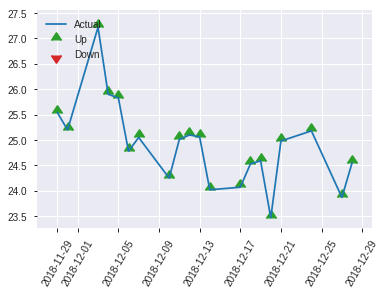


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2546272415437961
RMSE: 0.5046060260676601
LogLoss: 0.7040166408122853
Mean Per-Class Error: 0.4515533486121721
AUC: 0.5448497580850522
pr_auc: 0.5248627370796974
Gini: 0.08969951617010441
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.530726390864801: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    130  0.9848   (130.0/132.0)
1      0    119  0        (0.0/119.0)
Total  2    249  0.5179   (130.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.530726     0.646739  105
max f2                       0.530726     0.82069   105
max f0point5                 0.530726     0.533632  105
max accuracy                 0.661525     0.557769  13
max precision                0.661525     0.785714  13
max recall                   0.530726     1         105
max specificity              0.878728     0.992424  0
max absolute_mcc             0.661525     0.151676  13
max min_per_class_accuracy   0.530766     0.453782  104
max mean_per_class_accuracy  0.532479     0.548447  98

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 55.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.818273           0.703081  0.703081           0.333333         0.855312  0.333333                    0.855312            0.00840336      0.00840336                 -29.6919  -29.6919
    2        0.0239044                   0.709518           2.10924   1.40616            1                0.748917  0.666667                    0.802114            0.0252101       0.0336134                  110.924   40.6162
    3        0.0318725                   0.689828           1.05462   1.31828            0.5              0.694476  0.625                       0.775205            0.00840336      0.0420168                  5.46218   31.8277
    4        0.0438247                   0.671742           2.10924   1.534              1                0.678169  0.727273                    0.74874             0.0252101       0.0672269                  110.924   53.3995
    5        0.0517928                   0.66154            2.10924   1.6225             1                0.665089  0.769231                    0.735871            0.0168067       0.0840336                  110.924   62.2495
    6        0.103586                    0.609208           0.811248  1.21687            0.384615         0.637645  0.576923                    0.686758            0.0420168       0.12605                    -18.8752  21.6871
    7        0.151394                    0.584848           1.23039   1.22114            0.583333         0.594265  0.578947                    0.65755             0.0588235       0.184874                   23.0392   22.1141
    8        0.203187                    0.572518           0.973497  1.15802            0.461538         0.578765  0.54902                     0.637467            0.0504202       0.235294                   -2.65029  15.8016
    9        0.302789                    0.544554           0.843697  1.05462            0.4              0.562247  0.5                         0.612724            0.0840336       0.319328                   -15.6303  5.46218
    10       0.40239                     0.53137            1.26555   1.10683            0.6              0.535356  0.524752                    0.593573            0.12605         0.445378                   26.5546   10.6831
    11       0.992032                    0.530726           0.940609  1.00803            0.445946         0.530737  0.477912                    0.556225            0.554622        1                          -5.93913  0.803213
    12       1                           0.48586            0         1                  0                0.493586  0.474104                    0.555726            0               1                          -100      0

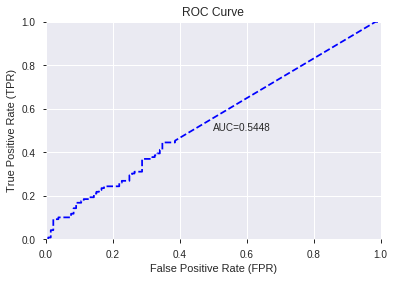

This function is available for GLM models only


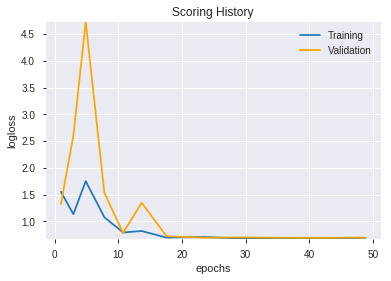

--2019-08-27 20:17:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_200730_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_200730_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDL3WHITESOLDIERS',
 'OBV',
 'LINEARREG_SLOPE_8',
 'PLUS_DM_12',
 'ADX_24',
 'MINUS_DM_24',
 'LINEARREG_SLOPE_20',
 'CORREL_30',
 'ROC_30',
 'AD',
 'BBANDS_upperband_8_0_3',
 'MA_30_7',
 'T3_8_0',
 'ROCR100_8',
 'BBANDS_middleband_8_3_3',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_upperband_30_6_3',
 'BBANDS_upperband_20_0_2',
 'BBANDS_lowerband_8_8_4',
 'ADOSC',
 'BBANDS_lowerband_12_6_5',
 'MIDPOINT_8',
 'BBANDS_lowerband_30_1_5',
 'KAMA_24',
 'BBANDS_middleband_14_3_5',
 'BBANDS_middleband_24_7_2',
 'BBANDS_middleband_12_3_2',
 'BBANDS_upperband_14_5_4',
 'BBANDS_middleband_30_2_2',
 'BBANDS_upperband_14_7_5',
 'T3_8_1',
 'BBANDS_upperband_14_1_2',
 'DEMA_12',
 'MA_12_1',
 'BBANDS_lowerband_20_7_5',
 'BBANDS_middleband_14_1_4',
 'BBANDS_lowerband_14_5_5',
 'MAVP_30_6',
 'BBANDS_middleband_12_1_5',
 'BBANDS_lowerband_30_6_5',
 'BBANDS_upperband_14_3_3',
 'BBANDS_upperband_14_2_3',
 'BBANDS_lowerband_14_1_2',
 'MIDPRICE_8',
 'BBANDS_middleband_8_5_4',
 'MA_30_1',
 'BBANDS_middleband_8_5_3'

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_201720_model_1  0.529985  0.695768                   0.5  0.501308  0.251309

variable  relative_importance  scaled_importance  percentage
0                        OBV             0.007460           1.000000    0.149479
1          LINEARREG_SLOPE_8             0.004356           0.583882    0.087278
2                  CORREL_30             0.003070           0.411539    0.061516
3                     CMO_20             0.002966           0.397598    0.059432
4         LINEARREG_SLOPE_20             0.002736           0.366775    0.054825
5                      ADOSC             0.002541           0.340553    0.050906
6                     ROC_30             0.002289           0.306845    0.045867
7                  ROCR100_8             0.002001           0.268219    0.040093
8                         AD             0.001684           0.225683    0.033735
9                     ADX_24             0.001524           0.204308    0.030540
10   BBANDS_lowerband_30_6_5             0.001441           0.193154    0.028872
11   BBANDS_lowerband_30_1_5             0.001397           0.187240    0.027988
12               MINUS_DM_24             0.001293           0.173369    0.025915
13                PLUS_DM_12             0.001251           0.167660    0.025062
14   BBANDS_lowerband_20_7_5             0.001116           0.149603    0.022363
15   BBANDS_lowerband_12_6_5             0.001098           0.147224    0.022007
16   BBANDS_lowerband_24_5_4             0.001084           0.145339    0.021725
17   BBANDS_lowerband_14_5_5             0.000740           0.099164    0.014823
18    BBANDS_lowerband_8_5_4             0.000720           0.096475    0.014421
19    BBANDS_lowerband_8_8_4             0.000636           0.085264    0.012745
20         CDL3WHITESOLDIERS             0.000491           0.065828    0.009840
21   BBANDS_lowerband_14_1_2             0.000488           0.065427    0.009780
22   BBANDS_lowerband_24_3_2             0.000482           0.064637    0.009662
23                MIDPOINT_8             0.000480           0.064378    0.009623
24                   MA_30_1             0.000474           0.063476    0.009488
25                 MAVP_30_6             0.000426           0.057157    0.008544
26                MIDPRICE_8             0.000401           0.053770    0.008037
27                    T3_8_0             0.000377           0.050549    0.007556
28   BBANDS_middleband_8_3_3             0.000372           0.049926    0.007463
29  BBANDS_middleband_30_2_2             0.000362           0.048525    0.007253
30                   MA_30_7             0.000354           0.047506    0.007101
31   BBANDS_upperband_14_5_4             0.000341           0.045744    0.006838
32                   KAMA_24             0.000341           0.045699    0.006831
33                    T3_8_1             0.000320           0.042960    0.006422
34  BBANDS_middleband_24_7_2             0.000300           0.040181    0.006006
35   BBANDS_upperband_14_7_5             0.000278           0.037309    0.005577
36                   MA_12_1             0.000256           0.034371    0.005138
37  BBANDS_middleband_12_1_5             0.000247           0.033048    0.004940
38  BBANDS_middleband_14_1_4             0.000234           0.031373    0.004690
39                   DEMA_12             0.000206           0.027561    0.004120
40   BBANDS_upperband_14_3_3             0.000198           0.026524    0.003965
41   BBANDS_upperband_14_2_3             0.000186           0.024889    0.003720
42  BBANDS_middleband_12_3_2             0.000177           0.023705    0.003543
43   BBANDS_middleband_8_5_3             0.000173           0.023175    0.003464
44   BBANDS_middleband_8_5_4             0.000160           0.021503    0.003214
45  BBANDS_middleband_14_3_5             0.000142           0.019033    0.002845
46    BBANDS_upperband_8_0_3             0.000121           0.016190    0.002420
47   BBANDS_upperband_30_6_3             0.000089           0.011889    0.001777
48   BBANDS_upperband_20_0_2             0.000016  

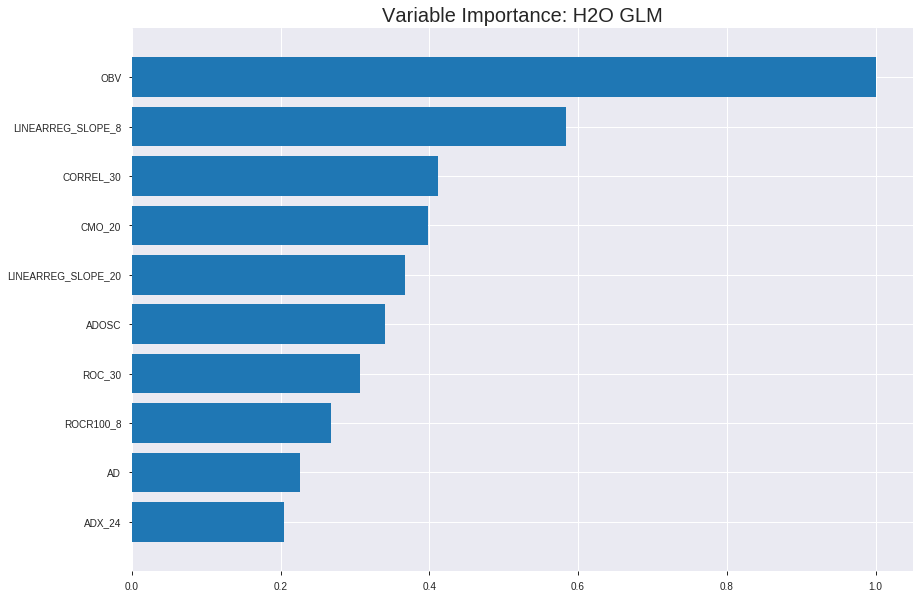

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_201720_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24869987826871678
RMSE: 0.4986981835426281
LogLoss: 0.6905434425224207
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2422.3593080819073
Residual deviance: 2421.045309483607
AIC: 2523.045309483607
AUC: 0.517192709490998
pr_auc: 0.553637797200838
Gini: 0.034385418981996096
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5184692055521294: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      13   805   0.9841   (805.0/818.0)
1      4    931   0.0043   (4.0/935.0)
Total  17   1736  0.4615   (809.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.518469     0.697117   388
max f2                       0.516492     0.851083   399
max f0point5                 0.520936     0.591426   365
max accuracy                 0.520936     0.541358   365
max precision                0.549993     1          0
max recall                   0.516492     1          399
max specificity              0.549993     1          0
max absolute_mcc             0.545657     0.0635619  24
max min_per_class_accuracy   0.534717     0.51016    176
max mean_per_class_accuracy  0.536624     0.520603   136

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.547436           1.14575   1.14575            0.611111         0.548408  0.611111                    0.548408            0.0117647       0.0117647                  14.5752    14.5752
    2        0.0205362                   0.545946           1.56239   1.35407            0.833333         0.546865  0.722222                    0.547637            0.0160428       0.0278075                  56.2389    35.407
    3        0.0302339                   0.544527           1.21315   1.30887            0.647059         0.54513   0.698113                    0.546833            0.0117647       0.0395722                  21.3149    30.8869
    4        0.040502                    0.542889           0.833274  1.1883             0.444444         0.543465  0.633803                    0.545979            0.00855615      0.0481283                  -16.6726   18.8296
    5        0.0501997                   0.542239           0.88229   1.12918            0.470588         0.542551  0.602273                    0.545317            0.00855615      0.0566845                  -11.771    12.9181
    6        0.100399                    0.540679           1.04396   1.08657            0.556818         0.54139   0.579545                    0.543353            0.0524064       0.109091                   4.39596    8.65702
    7        0.150029                    0.538921           1.05596   1.07644            0.563218         0.539782  0.574144                    0.542172            0.0524064       0.161497                   5.59592    7.64442
    8        0.200228                    0.537962           1.00135   1.05762            0.534091         0.538404  0.564103                    0.541227            0.0502674       0.211765                   0.134905   5.76169
    9        0.300057                    0.536865           1.04993   1.05506            0.56             0.537381  0.562738                    0.539947            0.104813        0.316578                   4.99251    5.50578
    10       0.399886                    0.535848           0.97493   1.03505            0.52             0.536316  0.552068                    0.539041            0.0973262       0.413904                   -2.50695   3.50546
    11       0.500285                    0.534695           0.958738  1.01974            0.511364         0.535307  0.5439                      0.538292            0.0962567       0.51016                    -4.12615   1.97391
    12       0.600114                    0.533503           0.996358  1.01585            0.531429         0.534109  0.541825                    0.537596            0.0994652       0.609626                   -0.364248  1.58496
    13       0.699943                    0.531202           0.921363  1.00237            0.491429         0.532561  0.534637                    0.536878            0.0919786       0.701604                   -7.86371   0.237351
    14       0.799772                    0.527252           1.04993   1.00831            0.56             0.528937  0.537803                    0.535887            0.104813        0.806417                   4.99251    0.830899
    15       0.899601                    0.523528           1.00707   1.00817            0.537143         0.525497  0.53773                     0.534734            0.100535        0.906952                   0.707105   0.817161
    16       1                           0.516492           0.926781  1                  0.494318         0.521165  0.533371                  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24882909320993418
RMSE: 0.49882771896711414
LogLoss: 0.6908039655098471
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 691.823895750088
Residual deviance: 692.1855734408668
AIC: 794.1855734408668
AUC: 0.5233784130239713
pr_auc: 0.5687168837318345
Gini: 0.04675682604794251
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5121851711460348: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    231  0.9957   (231.0/232.0)
1      0    269  0        (0.0/269.0)
Total  1    500  0.4611   (231.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.512185     0.69961   398
max f2                       0.512185     0.853426  398
max f0point5                 0.513154     0.592912  382
max accuracy                 0.51328      0.540918  378
max precision                0.530089     1         0
max recall                   0.512185     1         398
max specificity              0.530089     1         0
max absolute_mcc             0.522928     0.108893  47
max min_per_class_accuracy   0.518695     0.516729  197
max mean_per_class_accuracy  0.522928     0.532728  47

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 51.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.526224           0.931227  0.931227           0.5              0.527687  0.5                         0.527687            0.0111524       0.0111524                  -6.87732  -6.87732
    2        0.0219561                   0.525474           1.11747   1.01588            0.6              0.525584  0.545455                    0.526731            0.0111524       0.0223048                  11.7472   1.58837
    3        0.0319361                   0.524607           1.86245   1.28044            1                0.525116  0.6875                      0.526226            0.0185874       0.0408922                  86.2454   28.0437
    4        0.0419162                   0.52439            1.11747   1.24164            0.6              0.524433  0.666667                    0.525799            0.0111524       0.0520446                  11.7472   24.1636
    5        0.0518962                   0.523773           1.11747   1.21776            0.6              0.524142  0.653846                    0.525481            0.0111524       0.063197                   11.7472   21.7758
    6        0.101796                    0.522916           1.34097   1.27815            0.72             0.523276  0.686275                    0.5244              0.0669145       0.130112                   34.0967   27.8154
    7        0.151697                    0.522417           0.968476  1.17629            0.52             0.52265   0.631579                    0.523824            0.0483271       0.178439                   -3.15242  17.6286
    8        0.201597                    0.521821           0.81948   1.08797            0.44             0.52208   0.584158                    0.523392            0.0408922       0.219331                   -18.052   8.79679
    9        0.301397                    0.521048           1.00572   1.06074            0.54             0.521409  0.569536                    0.522736            0.100372        0.319703                   0.572491  6.07351
    10       0.401198                    0.519831           1.00572   1.04705            0.54             0.520359  0.562189                    0.522145            0.100372        0.420074                   0.572491  4.7051
    11       0.500998                    0.518681           0.968476  1.0314             0.52             0.519202  0.553785                    0.521558            0.0966543       0.516729                   -3.15242  3.13986
    12       0.600798                    0.518028           0.931227  1.01476            0.5              0.518314  0.54485                     0.52102             0.0929368       0.609665                   -6.87732  1.47587
    13       0.700599                    0.516923           0.968476  1.00817            0.52             0.517526  0.541311                    0.520522            0.0966543       0.70632                    -3.15242  0.816573
    14       0.800399                    0.516001           0.81948   0.984639           0.44             0.516477  0.528678                    0.520018            0.0817844       0.788104                   -18.052   -1.53612
    15       0.9002                      0.514542           1.11747   0.999365           0.6              0.515199  0.536585                    0.519483            0.111524        0.899628                   11.7472   -0.063469
    16       1                           0.512168           1.00572   1                  0.54             0.513424  0.536926                    0.518879     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:17:21  0.000 sec   2            2.1       51            1.38109           1.38161
    2019-08-27 20:17:21  0.013 sec   3            1.3       51            1.38081           1.38174
    2019-08-27 20:17:21  0.024 sec   4            0.82      51            1.38041           1.38176
    2019-08-27 20:17:21  0.032 sec   5            0.51      51            1.37988           1.38172
    2019-08-27 20:17:21  0.039 sec   6            0.32      51            1.3792            1.38165
    2019-08-27 20:17:21  0.052 sec   8            0.2       51            1.37839           1.38169
    2019-08-27 20:17:21  0.066 sec   10           0.12      51            1.3775            1.38202
    2019-08-27 20:17:21  0.079 sec   12           0.076     51            1.37657           1.3828
    2019-08-27 20:17:21  0.092 sec   14           0.047     51            1.37566           1.38413
    2019-08-27 20:17:21  0.105 sec   16           0.029     51            1.37478           1.38611

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.6432432432432432)

('auc', 0.5299847211611918)

('logloss', 0.6957678075860849)

('mean_per_class_error', 0.43073593073593075)

('rmse', 0.5013077829769305)

('mse', 0.2513094932732452)

glm prediction progress: |████████████████████████████████████████████████| 100%


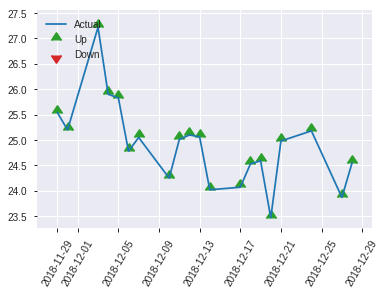


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2513094932732452
RMSE: 0.5013077829769305
LogLoss: 0.6957678075860849
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 350.81837939662717
Residual deviance: 349.27543940821465
AIC: 451.27543940821465
AUC: 0.5299847211611918
pr_auc: 0.48140846584274416
Gini: 0.05996944232238355
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5114853483037327: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    119  0        (0.0/119.0)
Total  0    251  0.5259   (132.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511485     0.643243  250
max f2                       0.511485     0.818432  250
max f0point5                 0.517664     0.557012  160
max accuracy                 0.517664     0.561753  160
max precision                0.517664     0.52795   160
max recall                   0.511485     1         250
max specificity              0.529323     0.992424  0
max absolute_mcc             0.517664     0.144233  160
max min_per_class_accuracy   0.51877      0.537815  124
max mean_per_class_accuracy  0.517664     0.569264  160

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 51.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.528718           0.703081  0.703081           0.333333         0.529017  0.333333                    0.529017            0.00840336      0.00840336                 -29.6919  -29.6919
    2        0.0239044                   0.528262           0.703081  0.703081           0.333333         0.528397  0.333333                    0.528707            0.00840336      0.0168067                  -29.6919  -29.6919
    3        0.0318725                   0.52795            0         0.527311           0                0.528134  0.25                        0.528564            0               0.0168067                  -100      -47.2689
    4        0.0438247                   0.527696           0.703081  0.575248           0.333333         0.527776  0.272727                    0.528349            0.00840336      0.0252101                  -29.6919  -42.4752
    5        0.0517928                   0.52735            2.10924   0.811248           1                0.527504  0.384615                    0.528219            0.0168067       0.0420168                  110.924   -18.8752
    6        0.103586                    0.525858           1.13575   0.973497           0.538462         0.526814  0.461538                    0.527516            0.0588235       0.10084                    13.5747   -2.65029
    7        0.151394                    0.524806           1.40616   1.11013            0.666667         0.52532   0.526316                    0.526823            0.0672269       0.168067                   40.6162   11.0128
    8        0.203187                    0.524075           0.973497  1.0753             0.461538         0.524395  0.509804                    0.526204            0.0504202       0.218487                   -2.65029  7.53007
    9        0.302789                    0.522273           0.843697  0.999115           0.4              0.523166  0.473684                    0.525205            0.0840336       0.302521                   -15.6303  -0.0884564
    10       0.40239                     0.520796           1.18118   1.04418            0.56             0.521351  0.49505                     0.524251            0.117647        0.420168                   18.1176   4.418
    11       0.501992                    0.518768           1.18118   1.07136            0.56             0.51952   0.507937                    0.523312            0.117647        0.537815                   18.1176   7.13619
    12       0.601594                    0.518032           1.18118   1.08954            0.56             0.518373  0.516556                    0.522494            0.117647        0.655462                   18.1176   8.95431
    13       0.701195                    0.517096           0.759328  1.04264            0.36             0.517557  0.494318                    0.521793            0.0756303       0.731092                   -24.0672  4.26375
    14       0.800797                    0.515962           0.759328  1.0074             0.36             0.516556  0.477612                    0.521142            0.0756303       0.806723                   -24.0672  0.739997
    15       0.900398                    0.514915           0.759328  0.979958           0.36             0.515453  0.464602                    0.520512            0.0756303       0.882353                   -24.0672  -2.00416
    16       1                           0.511485           1.18118   1                  0.56             0.513636  0.474104                    0.519828

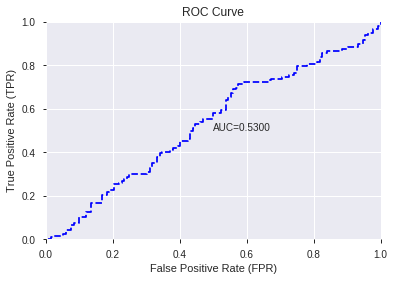

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


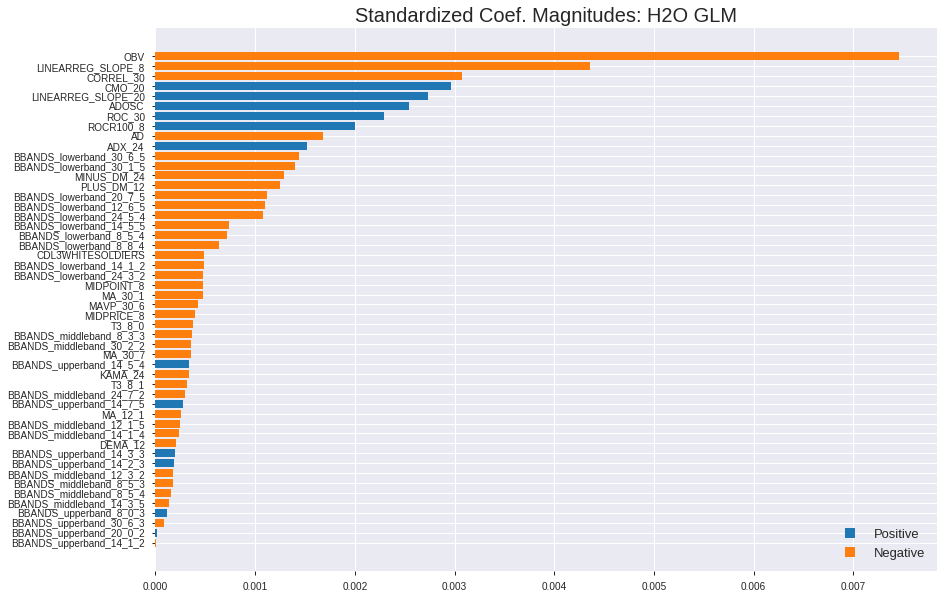

'log_likelihood'
--2019-08-27 20:17:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_201720_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_201720_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['OBV',
 'LINEARREG_SLOPE_8',
 'CORREL_30',
 'CMO_20',
 'LINEARREG_SLOPE_20',
 'ADOSC',
 'ROC_30',
 'ROCR100_8',
 'AD',
 'ADX_24',
 'BBANDS_lowerband_30_6_5',
 'BBANDS_lowerband_30_1_5',
 'MINUS_DM_24',
 'PLUS_DM_12',
 'BBANDS_lowerband_20_7_5',
 'BBANDS_lowerband_12_6_5',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_lowerband_8_8_4',
 'CDL3WHITESOLDIERS',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_lowerband_24_3_2',
 'MIDPOINT_8',
 'MA_30_1',
 'MAVP_30_6',
 'MIDPRICE_8',
 'T3_8_0',
 'BBANDS_middleband_8_3_3',
 'BBANDS_middleband_30_2_2',
 'MA_30_7',
 'BBANDS_upperband_14_5_4',
 'KAMA_24',
 'T3_8_1',
 'BBANDS_middleband_24_7_2',
 'BBANDS_upperband_14_7_5',
 'MA_12_1',
 'BBANDS_middleband_12_1_5',
 'BBANDS_middleband_14_1_4',
 'DEMA_12',
 'BBANDS_upperband_14_3_3',
 'BBANDS_upperband_14_2_3',
 'BBANDS_middleband_12_3_2',
 'BBANDS_middleband_8_5_3',
 'BBANDS_middleband_8_5_4',
 'BBANDS_middleband_14_3_5',
 'BBANDS_upperband_8_0_3',
 'BBANDS_upperb

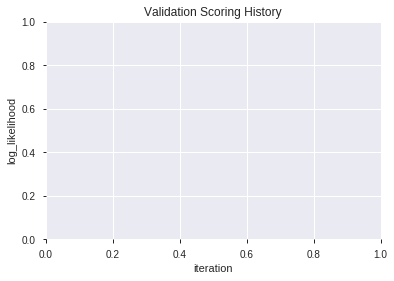

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_201731_model_7  0.570474  0.686657              0.456614  0.496861  0.246871
1               XGBoost_1_AutoML_20190827_201731  0.563280  0.683703              0.474312  0.495409  0.245430
2  XGBoost_grid_1_AutoML_20190827_201731_model_4  0.543545  0.691719              0.492424  0.499354  0.249354
3  XGBoost_grid_1_AutoML_20190827_201731_model_3  0.525337  0.715064              0.500000  0.510091  0.260193
4  XGBoost_grid_1_AutoML_20190827_201731_model_1  0.524637  0.728526              0.488636  0.516271  0.266535
5  XGBoost_grid_1_AutoML_20190827_201731_model_2  0.523873  0.693823              0.470525  0.500390  0.250390
6  XGBoost_grid_1_AutoML_20190827_201731_model_6  0.522409  0.711157              0.443118  0.508656  0.258731
7  XGBoost_grid_1_AutoML_20190827_201731_model_5  0.508340  0.729420              0.500000  0.515814  0.266065
8               XGBoost_2_AutoML_20190827_201731  0.506780  0.704559              0.496212  0.505492  0.255522
9               XGBoost_3_AutoML_20190827_201731  0.504966  0.704061              0.456614  0.505442  0.255472

variable  relative_importance  scaled_importance  percentage
0                      ADOSC           507.614136           1.000000    0.081195
1          LINEARREG_SLOPE_8           383.565338           0.755624    0.061353
2                MINUS_DM_24           379.212219           0.747048    0.060657
3                  ROCR100_8           375.750275           0.740228    0.060103
4                     ROC_30           351.925903           0.693294    0.056292
5                     CMO_20           324.020447           0.638320    0.051828
6                  CORREL_30           292.932220           0.577077    0.046856
7                     ADX_24           291.322266           0.573905    0.046598
8                 PLUS_DM_12           272.282257           0.536396    0.043553
9                        OBV           261.554810           0.515263    0.041837
10        LINEARREG_SLOPE_20           244.800613           0.482257    0.039157
11                        AD           191.024185           0.376318    0.030555
12   BBANDS_lowerband_30_6_5           159.912674           0.315028    0.025579
13    BBANDS_lowerband_8_5_4           152.571899           0.300567    0.024405
14   BBANDS_lowerband_12_6_5           138.856567           0.273547    0.022211
15    BBANDS_lowerband_8_8_4           136.389984           0.268688    0.021816
16   BBANDS_upperband_14_7_5           132.512482           0.261050    0.021196
17   BBANDS_lowerband_24_5_4           120.200005           0.236794    0.019227
18   BBANDS_upperband_14_5_4           105.159500           0.207164    0.016821
19   BBANDS_lowerband_30_1_5            96.362053           0.189833    0.015414
20   BBANDS_lowerband_14_1_2            87.883102           0.173130    0.014057
21   BBANDS_lowerband_14_5_5            81.893005           0.161329    0.013099
22    BBANDS_upperband_8_0_3            78.979080           0.155589    0.012633
23   BBANDS_lowerband_24_3_2            75.880547           0.149485    0.012137
24   BBANDS_lowerband_20_7_5            74.269966           0.146312    0.011880
25                   KAMA_24            73.956703           0.145695    0.011830
26   BBANDS_middleband_8_3_3            73.080582           0.143969    0.011690
27   BBANDS_upperband_14_1_2            71.153770           0.140173    0.011381
28   BBANDS_upperband_30_6_3            69.089333           0.136106    0.011051
29                MIDPRICE_8            66.884811           0.131763    0.010699
30                 MAVP_30_6            65.674347           0.129378    0.010505
31   BBANDS_upperband_20_0_2            60.828041           0.119831    0.009730
32                MIDPOINT_8            59.444920           0.117107    0.009508
33                    T3_8_0            58.784531           0.115806    0.009403
34  BBANDS_middleband_24_7_2            53.508369           0.105412    0.008559
35   BBANDS_upperband_14_3_3            46.856846           0.092308    0.007495
36                   DEMA_12            43.109394           0.084926    0.006896
37   BBANDS_middleband_8_5_3            30.948067           0.060968    0.004950
38   BBANDS_upperband_14_2_3            25.080868           0.049409    0.004012
39                   MA_12_1            22.263361           0.043859    0.003561
40                   MA_30_7            21.733837           0.042816    0.003476
41                    T3_8_1            21.372938           0.042105    0.003419
42                   MA_30_1            20.168463           0.039732    0.003226
43  BBANDS_middleband_30_2_2            14.461261           0.028489    0.002313
44   BBANDS_middleband_8_5_4            13.874250           0.027332    0.002219
45  BBANDS_middleband_14_3_5            13.832162           0.027249    0.002213
46  BBANDS_middleband_12_3_2             8.801775           0.017339    0.001408

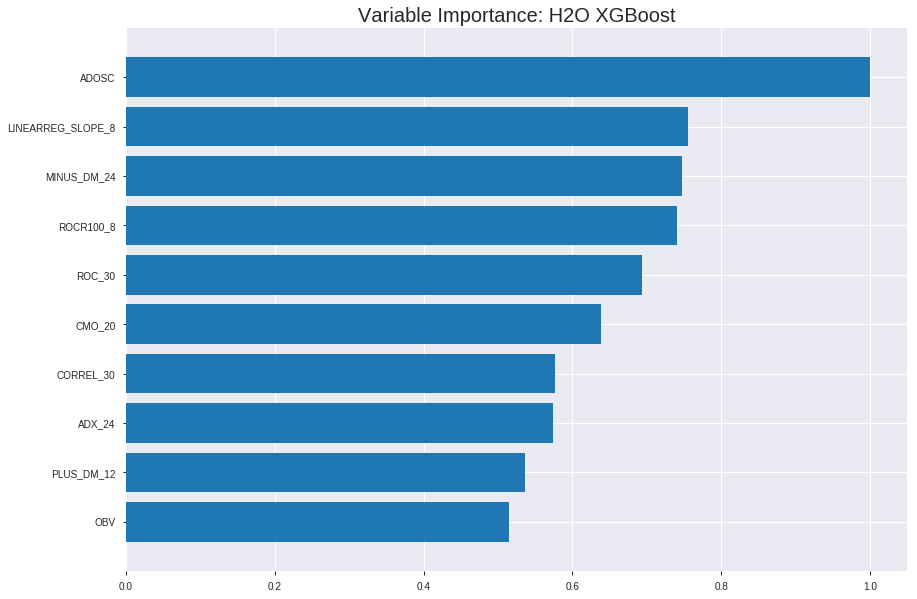

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_201731_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17541691744157
RMSE: 0.4188280284813446
LogLoss: 0.538082565104955
Mean Per-Class Error: 0.15776773923617016
AUC: 0.915359622399749
pr_auc: 0.924271071685209
Gini: 0.830719244799498
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5200821061929067: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      668  150  0.1834   (150.0/818.0)
1      124  811  0.1326   (124.0/935.0)
Total  792  961  0.1563   (274.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520082     0.855485  207
max f2                       0.423748     0.898645  284
max f0point5                 0.574433     0.873533  162
max accuracy                 0.521073     0.843697  206
max precision                0.835648     1         0
max recall                   0.323573     1         357
max specificity              0.835648     1         0
max absolute_mcc             0.521073     0.685694  206
max min_per_class_accuracy   0.530612     0.833741  198
max mean_per_class_accuracy  0.521073     0.842232  206

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.03 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.771744           1.87487    1.87487            1                0.79201   1                           0.79201             0.0192513       0.0192513                  87.4866   87.4866
    2        0.0205362                   0.755163           1.87487    1.87487            1                0.763646  1                           0.777828            0.0192513       0.0385027                  87.4866   87.4866
    3        0.0302339                   0.744611           1.87487    1.87487            1                0.749584  1                           0.768769            0.0181818       0.0566845                  87.4866   87.4866
    4        0.040502                    0.735788           1.87487    1.87487            1                0.739212  1                           0.761275            0.0192513       0.0759358                  87.4866   87.4866
    5        0.0501997                   0.725846           1.65429    1.83226            0.882353         0.730626  0.977273                    0.755354            0.0160428       0.0919786                  65.4294   83.2256
    6        0.100399                    0.694734           1.87487    1.85356            1                0.708505  0.988636                    0.73193             0.0941176       0.186096                   87.4866   85.3561
    7        0.150029                    0.669268           1.81022    1.83922            0.965517         0.682072  0.980989                    0.715437            0.0898396       0.275936                   81.0216   83.9222
    8        0.200228                    0.647016           1.81095    1.83213            0.965909         0.658745  0.977208                    0.701224            0.0909091       0.366845                   81.095    83.2134
    9        0.300057                    0.610787           1.69274    1.78576            0.902857         0.628011  0.952471                    0.676866            0.168984        0.535829                   69.2736   78.5757
    10       0.399886                    0.580236           1.5856     1.73579            0.845714         0.595796  0.92582                     0.656627            0.158289        0.694118                   58.5601   73.5789
    11       0.500285                    0.540214           1.16114    1.62047            0.619318         0.55945   0.86431                     0.637125            0.116578        0.810695                   16.1139   62.0466
    12       0.600114                    0.493666           0.889222   1.49882            0.474286         0.517936  0.79943                     0.617298            0.0887701       0.899465                   -11.0778  49.8824
    13       0.699943                    0.455306           0.439254   1.3477             0.234286         0.473509  0.718826                    0.59679             0.0438503       0.943316                   -56.0746  34.7703
    14       0.799772                    0.407683           0.417827   1.23163            0.222857         0.432522  0.656919                    0.576286            0.0417112       0.985027                   -58.2173  23.1635
    15       0.899601                    0.356254           0.128562   1.10923            0.0685714        0.38248   0.59163                     0.554779            0.0128342       0.997861                   -87.1438  10.9227
    16       1                           0.188251           0.0213053  1                  0.0113636        0.310758  0.533371                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26319428588882865
RMSE: 0.5130246445238559
LogLoss: 0.7202579250111888
Mean Per-Class Error: 0.48660428150237145
AUC: 0.49089860274323804
pr_auc: 0.5199895817144097
Gini: -0.018202794513523912
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2881508469581604: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    230  0.9914   (230.0/232.0)
1      0    269  0        (0.0/269.0)
Total  2    499  0.4591   (230.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.288151     0.700521   397
max f2                       0.288151     0.853968   397
max f0point5                 0.288151     0.593819   397
max accuracy                 0.288151     0.540918   397
max precision                0.49976      0.561224   83
max recall                   0.288151     1          397
max specificity              0.637557     0.99569    0
max absolute_mcc             0.606258     0.0835753  2
max min_per_class_accuracy   0.435944     0.482759   202
max mean_per_class_accuracy  0.399749     0.513396   292

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 44.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.58               0.620818  0.620818           0.333333         0.604836  0.333333                    0.604836            0.00743494      0.00743494                 -37.9182  -37.9182
    2        0.0219561                   0.56654            0.744981  0.677256           0.4              0.57221   0.363636                    0.590006            0.00743494      0.0148699                  -25.5019  -32.2744
    3        0.0319361                   0.560602           1.11747   0.814823           0.6              0.562866  0.4375                      0.581525            0.0111524       0.0260223                  11.7472   -18.5177
    4        0.0419162                   0.551598           0.744981  0.798194           0.4              0.55485   0.428571                    0.575174            0.00743494      0.0334572                  -25.5019  -20.1806
    5        0.0518962                   0.547973           1.11747   0.859594           0.6              0.549342  0.461538                    0.570206            0.0111524       0.0446097                  11.7472   -14.0406
    6        0.101796                    0.522524           1.04297   0.949486           0.56             0.535096  0.509804                    0.552995            0.0520446       0.0966543                  4.2974    -5.05139
    7        0.151697                    0.506997           1.04297   0.980239           0.56             0.515127  0.526316                    0.540539            0.0520446       0.148699                   4.2974    -1.97613
    8        0.201597                    0.499395           1.11747   1.01421            0.6              0.502635  0.544554                    0.531157            0.0557621       0.204461                   11.7472   1.42074
    9        0.301397                    0.479237           0.968476  0.999064           0.52             0.487748  0.536424                    0.516783            0.0966543       0.301115                   -3.15242  -0.0935523
    10       0.401198                    0.456762           0.968476  0.991455           0.52             0.466303  0.532338                    0.504226            0.0966543       0.39777                    -3.15242  -0.854464
    11       0.500998                    0.435638           0.856729  0.964617           0.46             0.443665  0.517928                    0.492162            0.0855019       0.483271                   -14.3271  -3.53826
    12       0.600798                    0.419883           1.00572   0.971446           0.54             0.428376  0.521595                    0.481566            0.100372        0.583643                   0.572491  -2.85541
    13       0.700599                    0.406008           1.15472   0.997553           0.62             0.41252   0.535613                    0.471731            0.115242        0.698885                   15.4721   -0.244654
    14       0.800399                    0.383927           1.08022   1.00786            0.58             0.395212  0.541147                    0.46219             0.107807        0.806691                   8.0223    0.786139
    15       0.9002                      0.363892           0.931227  0.999365           0.5              0.372767  0.536585                    0.452276            0.0929368       0.899628                   -6.87732  -0.063469
    16       1                           0.226762           1.00572   1                  0.54             0.334053  0.536926                  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:17:43  7.466 sec   0                  0.5              0.693147            0.5             0                  1                0.466629                         0.5                0.693147              0.5               0                    1                  0.463074
    2019-08-27 20:17:44  7.602 sec   5                  0.486883         0.667184            0.764221        0.768107           1.66655          0.3166                           0.500824           0.694797              0.502612          0.528871             1.24164            0.459082
    2019-08-27 20:17:44  7.691 sec   10                 0.474917         0.643882            0.813411        0.817549           1.87487          0.272675                         0.5026             0.698384              0.505913          0.546853             1.55204            0.449102
    2019-08-27 20:17:44  7.786 sec   15                 0.464817         0.624457            0.838916        0.844109           1.87487          0.243012                         0.50667            0.706743              0.497989          0.530986             0.931227           0.463074
    2019-08-27 20:17:44  7.882 sec   20                 0.454946         0.605641            0.864743        0.875193           1.87487          0.216201                         0.509764           0.713289              0.498245          0.533316             0.310409           0.461078
    2019-08-27 20:17:44  7.969 sec   25                 0.447889         0.59229             0.87686         0.88492            1.87487          0.198517                         0.516938           0.728744              0.504078          0.529121             0.310409           0.461078
    2019-08-27 20:17:44  8.076 sec   30                 0.441207         0.579604            0.882212        0.890499           1.87487          0.184256                         0.51681            0.728445              0.506345          0.527758             0.620818           0.459082
    2019-08-27 20:17:44  8.162 sec   35                 0.435183         0.568274            0.891507        0.900442           1.87487          0.180262                         0.516797           0.728482              0.507411          0.528231             0.620818           0.45509
    2019-08-27 20:17:44  8.249 sec   40                 0.429495         0.557654            0.899552        0.910218           1.87487          0.179122                         0.515387           0.725312              0.498494          0.521396             0.310409           0.453094
    2019-08-27 20:17:44  8.352 sec   45                 0.422855         0.54536             0.909135        0.918447           1.87487          0.159156                         0.513655           0.721664              0.503798          0.528065             0.620818           0.459082
    2019-08-27 20:17:44  8.435 sec   50                 0.418828         0.538083            0.91536         0.924271           1.87487          0.156303                         0.513025           0.720258              0.490899          0.51999              0.620818           0.459082

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
ADOSC                     507.6141357421875      1.0                   0.08119508328282807
LINEARREG_SLOPE_8         383.5653381347656      0.7556238314245348    0.06135293992300474
MINUS_DM_24               379.21221923828125     0.747048185889921     0.06065663966961775
ROCR100_8                 375.7502746582031      0.7402281540265128    0.06010288661447678
ROC_30                    351.9259033203125      0.6932941353293053    0.05629207505755921
---                       ---                    ---                   ---
MA_30_1                   20.1684627532959       0.03973187768659633   0.0032260331177463267
BBANDS_middleband_30_2_2  14.461260795593262     0.02848868811434755   0.0023131414040629635
BBANDS_middleband_8_5_4   13.874250411987305     0.027332277482189558  0.0022192465464757473
BBANDS_middleband_14_3_5  13.832161903381348     0.027249363107584093  0.002212514306924313
BBANDS_middleband_12_3_2  8.801774978637695      0.01733949935371389   0.0014078820941073426


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5657370517928287)

('F1', 0.6551724137931034)

('auc', 0.5704736440030558)

('logloss', 0.6866566632138098)

('mean_per_class_error', 0.4319136745607334)

('rmse', 0.49686081801973747)

('mse', 0.24687067248324268)

xgboost prediction progress: |████████████████████████████████████████████| 100%


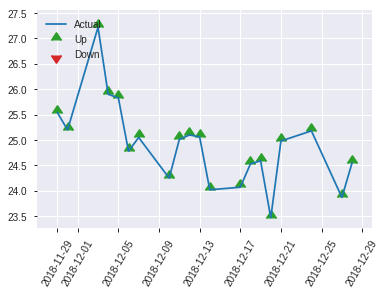


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24687067248324268
RMSE: 0.49686081801973747
LogLoss: 0.6866566632138098
Mean Per-Class Error: 0.4319136745607334
AUC: 0.5704736440030558
pr_auc: 0.5486144863000738
Gini: 0.14094728800611156
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4094403386116028: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   115  0.8712   (115.0/132.0)
1      5    114  0.042    (5.0/119.0)
Total  22   229  0.4781   (120.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40944      0.655172  225
max f2                       0.344633     0.821823  244
max f0point5                 0.40944      0.550725  225
max accuracy                 0.509119     0.565737  128
max precision                0.743768     1         0
max recall                   0.344633     1         244
max specificity              0.743768     1         0
max absolute_mcc             0.40944      0.153217  225
max min_per_class_accuracy   0.515255     0.554622  122
max mean_per_class_accuracy  0.50611      0.568086  134

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 51.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0159363                   0.720688           1.58193   1.58193            0.75             0.732028  0.75                        0.732028            0.0252101       0.0252101                  58.1933   58.1933
    2        0.0239044                   0.716972           2.10924   1.7577             1                0.717009  0.833333                    0.727021            0.0168067       0.0420168                  110.924   75.7703
    3        0.0318725                   0.707012           2.10924   1.84559            1                0.712777  0.875                       0.72346             0.0168067       0.0588235                  110.924   84.5588
    4        0.0438247                   0.698716           0.703081  1.534              0.333333         0.700482  0.727273                    0.717194            0.00840336      0.0672269                  -29.6919  53.3995
    5        0.0517928                   0.693371           2.10924   1.6225             1                0.69729   0.769231                    0.714132            0.0168067       0.0840336                  110.924   62.2495
    6        0.103586                    0.642109           0.973497  1.298              0.461538         0.664016  0.615385                    0.689074            0.0504202       0.134454                   -2.65029  29.7996
    7        0.151394                    0.611185           1.05462   1.22114            0.5              0.623909  0.578947                    0.668495            0.0504202       0.184874                   5.46218   22.1141
    8        0.203187                    0.588877           0.973497  1.15802            0.461538         0.599153  0.54902                     0.65082             0.0504202       0.235294                   -2.65029  15.8016
    9        0.302789                    0.561051           0.843697  1.05462            0.4              0.572655  0.5                         0.625108            0.0840336       0.319328                   -15.6303  5.46218
    10       0.40239                     0.535219           1.26555   1.10683            0.6              0.546421  0.524752                    0.605631            0.12605         0.445378                   26.5546   10.6831
    11       0.501992                    0.513571           1.18118   1.12158            0.56             0.52644   0.531746                    0.589918            0.117647        0.563025                   18.1176   12.1582
    12       0.601594                    0.488522           0.843697  1.07557            0.4              0.500883  0.509934                    0.575177            0.0840336       0.647059                   -15.6303  7.55746
    13       0.701195                    0.460023           0.843697  1.04264            0.4              0.473963  0.494318                    0.5608              0.0840336       0.731092                   -15.6303  4.26375
    14       0.800797                    0.438638           1.09681   1.04937            0.52             0.446998  0.497512                    0.546646            0.109244        0.840336                   9.68067   4.9375
    15       0.900398                    0.412958           0.928067  1.03596            0.44             0.424911  0.49115                     0.533179            0.092437        0.932773                   -7.19328  3.5956
    16       1                           0.32898            0.674958  1                  0.32             0.378296  0.474104                    0.517753           

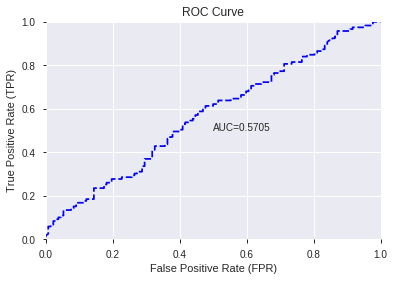

This function is available for GLM models only


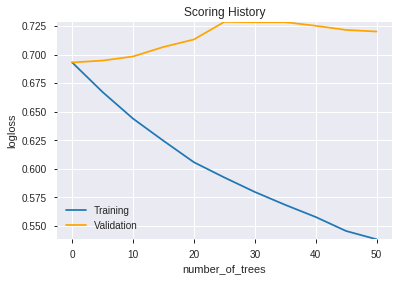

--2019-08-27 20:17:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_201731_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_201731_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['ADOSC',
 'LINEARREG_SLOPE_8',
 'MINUS_DM_24',
 'ROCR100_8',
 'ROC_30',
 'CMO_20',
 'CORREL_30',
 'ADX_24',
 'PLUS_DM_12',
 'OBV',
 'LINEARREG_SLOPE_20',
 'AD',
 'BBANDS_lowerband_30_6_5',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_lowerband_12_6_5',
 'BBANDS_lowerband_8_8_4',
 'BBANDS_upperband_14_7_5',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_upperband_14_5_4',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_upperband_8_0_3',
 'BBANDS_lowerband_24_3_2',
 'BBANDS_lowerband_20_7_5',
 'KAMA_24',
 'BBANDS_middleband_8_3_3',
 'BBANDS_upperband_14_1_2',
 'BBANDS_upperband_30_6_3',
 'MIDPRICE_8',
 'MAVP_30_6',
 'BBANDS_upperband_20_0_2',
 'MIDPOINT_8',
 'T3_8_0',
 'BBANDS_middleband_24_7_2',
 'BBANDS_upperband_14_3_3',
 'DEMA_12',
 'BBANDS_middleband_8_5_3',
 'BBANDS_upperband_14_2_3',
 'MA_12_1',
 'MA_30_7',
 'T3_8_1',
 'MA_30_1',
 'BBANDS_middleband_30_2_2',
 'BBANDS_middleband_8_5_4',
 'BBANDS_middleband_14_3_5',
 'BBANDS_middleband_12_3_2']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [900 916] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190827_201757  0.559778   7.970592              0.500000  0.628511  0.395027
1  DeepLearning_grid_1_AutoML_20190827_201757_model_7  0.525624   4.634269              0.496212  0.635279  0.403579
2  DeepLearning_grid_1_AutoML_20190827_201757_model_3  0.501369   6.115075              0.500000  0.680284  0.462786
3  DeepLearning_grid_1_AutoML_20190827_201757_model_6  0.500000   0.700176              0.500000  0.503494  0.253506
4  DeepLearning_grid_1_AutoML_20190827_201757_model_9  0.500000   0.701620              0.500000  0.504205  0.254223
5  DeepLearning_grid_1_AutoML_20190827_201757_model_5  0.500000   0.702907              0.500000  0.504837  0.254861
6  DeepLearning_grid_1_AutoML_20190827_201757_model_8  0.500000   0.697786              0.500000  0.502311  0.252316
7  DeepLearning_grid_1_AutoML_20190827_201757_model_4  0.490896   4.704194              0.500000  0.664473  0.441525
8  DeepLearning_grid_1_AutoML_20190827_201757_model_2  0.490387   3.804014              0.500000  0.658296  0.433354
9  DeepLearning_grid_1_AutoML_20190827_201757_model_1  0.469824  13.394677              0.500000  0.730672  0.533881

variable  relative_importance  scaled_importance  percentage
0                       MFI_24             1.000000           1.000000    0.001683
1                    CDLINNECK             0.979844           0.979844    0.001649
2      BBANDS_upperband_24_2_3             0.959613           0.959613    0.001615
3                         week             0.952374           0.952374    0.001603
4                 HT_TRENDMODE             0.944368           0.944368    0.001590
...                        ...                  ...                ...         ...
1035                    MOM_30             0.293562           0.293562    0.000494
1036  BBANDS_middleband_20_2_3             0.285876           0.285876    0.000481
1037                    MIN_12             0.268710           0.268710    0.000452
1038   BBANDS_upperband_30_0_5             0.257167           0.257167    0.000433
1039                    TSF_24             0.256222           0.256222    0.000431

[1040 rows x 4 columns]

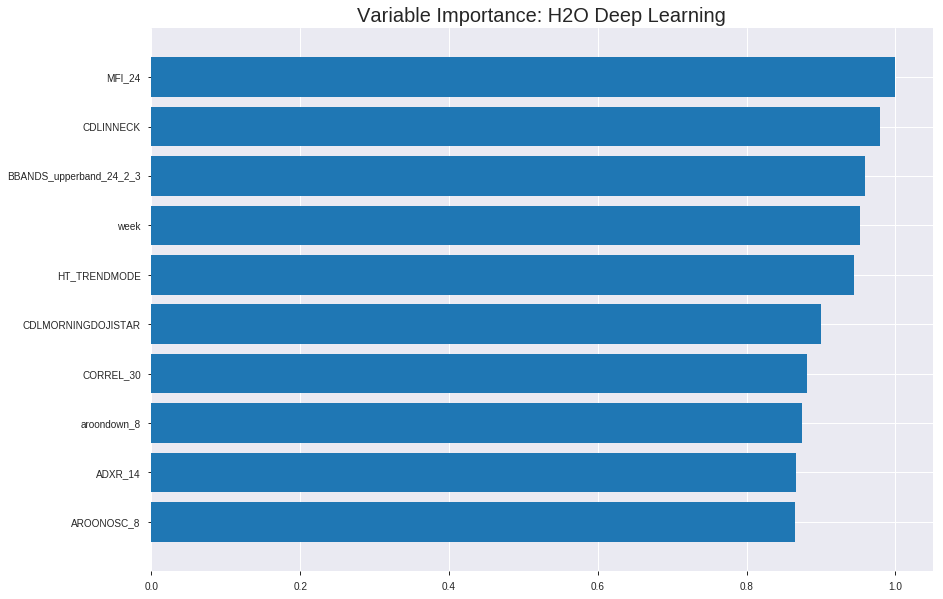

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_201757


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24652251440869685
RMSE: 0.49651033665845956
LogLoss: 0.6849664546796287
Mean Per-Class Error: 0.4651746139665024
AUC: 0.5542545402246251
pr_auc: 0.6099109526519737
Gini: 0.10850908044925012
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1459542855805991: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    813   0.9939   (813.0/818.0)
1      1    934   0.0011   (1.0/935.0)
Total  6    1747  0.4643   (814.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.145954     0.696495  394
max f2                       0.0828819    0.851393  397
max f0point5                 0.50924      0.598149  266
max accuracy                 0.52814      0.555619  249
max precision                0.999947     1         0
max recall                   0.0828819    1         397
max specificity              0.999947     1         0
max absolute_mcc             0.884629     0.13159   37
max min_per_class_accuracy   0.580968     0.235294  191
max mean_per_class_accuracy  0.598594     0.534825  170

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 58.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.961904           1.87487   1.87487            1                0.986619  1                           0.986619            0.0192513       0.0192513                  87.4866    87.4866
    2        0.0205362                   0.911098           1.66655   1.77071            0.888889         0.93551   0.944444                    0.961064            0.0171123       0.0363636                  66.6548    77.0707
    3        0.0302339                   0.819326           1.43372   1.66262            0.764706         0.872842  0.886792                    0.932766            0.0139037       0.0502674                  43.3721    66.2617
    4        0.040502                    0.713774           1.14575   1.53158            0.611111         0.759972  0.816901                    0.888959            0.0117647       0.0620321                  14.5752    53.1581
    5        0.0501997                   0.691604           1.21315   1.47007            0.647059         0.699758  0.784091                    0.852409            0.0117647       0.0737968                  21.3149    47.0066
    6        0.100399                    0.631736           1.02265   1.24636            0.545455         0.657685  0.664773                    0.755047            0.0513369       0.125134                   2.26544    24.636
    7        0.150029                    0.607083           1.05596   1.18338            0.563218         0.61928   0.631179                    0.710136            0.0524064       0.17754                    5.59592    18.3376
    8        0.200228                    0.581995           1.00135   1.13774            0.534091         0.595609  0.606838                    0.681422            0.0502674       0.227807                   0.134905   13.7739
    9        0.81061                     0.580312           0.995256  1.03045            0.530841         0.58032   0.549613                    0.605293            0.607487        0.835294                   -0.474387  3.04508
    10       0.899601                    0.507447           1.02156   1.02957            0.544872         0.55152   0.549144                    0.599974            0.0909091       0.926203                   2.15618    2.95715
    11       1                           0.0453684          0.735033  1                  0.392045         0.40113   0.533371                    0.58001             0.0737968       1                          -26.4967   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.38194393423228185
RMSE: 0.6180161278092036
LogLoss: 9.61037198762776
Mean Per-Class Error: 0.49784482758620685
AUC: 0.4692507370849891
pr_auc: 0.23960686096662964
Gini: -0.0614985258300218
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.580311838443912: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    231  0.9957   (231.0/232.0)
1      0    269  0        (0.0/269.0)
Total  1    500  0.4611   (231.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.580312     0.69961    31
max f2                       0.580312     0.853426   31
max f0point5                 0.580312     0.592772   31
max accuracy                 0.580312     0.538922   31
max precision                0.580312     0.538      31
max recall                   0.580312     1          31
max specificity              1            0.418103   0
max absolute_mcc             0.585406     0.0898296  29
max min_per_class_accuracy   1            0.418103   0
max mean_per_class_accuracy  0.580312     0.502155   31

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 82.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.55489                     1                  0.964724  0.964724           0.517986         1         0.517986                    1                   0.535316        0.535316                   -3.52759  -3.52759
    2        0.600798                    0.607008           0.64781   0.940508           0.347826         0.75609   0.504983                    0.981362            0.0297398       0.565056                   -35.219   -5.94919
    3        0.998004                    0.580312           1.09501   1.002              0.58794          0.580992  0.538                       0.822015            0.434944        1                          9.50104   0.2
    4        1                           0.509407           0         1                  0                0.509407  0.536926                    0.821391            0               1                          -100      0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:17:57  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:17:57  0.423 sec   7097 obs/sec      1         1             1753       0.575262         1.07344             -0.32963       0.528389        0.554886           1.24991          0.462065                         0.691331           10.2742               -0.922241        0.473801          0.238778             0.967942           0.457086
    2019-08-27 20:17:59  2.343 sec   8584 obs/sec      10        10            17530      0.49651          0.684966            0.00949766     0.554255        0.609911           1.87487          0.464347                         0.618016           9.61037               -0.536154        0.469251          0.239607             0.964724           0.461078

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
MFI_24                    1.0                    1.0                  0.0016834012696286319
CDLINNECK                 0.9798436164855957     0.9798436164855957   0.0016494699880293619
BBANDS_upperband_24_2_3   0.9596131443977356     0.9596131443977356   0.0016154139856314716
week                      0.9523742198944092     0.9523742198944092   0.001603227970931826
HT_TRENDMODE              0.9443676471710205     0.9443676471710205   0.0015897496962438997
---                       ---                    ---                  ---
MOM_30                    0.29356175661087036    0.29356175661087036  0.0004941822337931505
BBANDS_middleband_20_2_3  0.28587570786476135    0.28587570786476135  0.0004812435295755231
MIN_12                    0.26870962977409363    0.26870962977409363  0.0004523461319231488
BBANDS_upperband_30_0_5   0.2571667432785034     0.2571667432785034   0.00043291482214129304
TSF_24                    0.2562218904495239     0.2562218904495239   0.00043132425568937675


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5816733067729084)

('F1', 0.6432432432432432)

('auc', 0.5597784568372804)

('logloss', 7.970591878598336)

('mean_per_class_error', 0.41303794244970715)

('rmse', 0.6285113924097165)

('mse', 0.3950265703888007)

deeplearning prediction progress: |███████████████████████████████████████| 100%


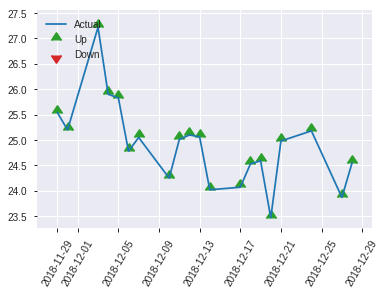


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3950265703888007
RMSE: 0.6285113924097165
LogLoss: 7.970591878598336
Mean Per-Class Error: 0.41303794244970715
AUC: 0.5597784568372804
pr_auc: 0.2803082933367983
Gini: 0.1195569136745609
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.511360647857633: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    119  0        (0.0/119.0)
Total  0    251  0.5259   (132.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511361     0.643243  95
max f2                       0.511361     0.818432  95
max f0point5                 0.928884     0.570236  41
max accuracy                 0.956563     0.581673  39
max precision                0.956563     0.547297  39
max recall                   0.511361     1         95
max specificity              1            0.583333  0
max absolute_mcc             0.928884     0.177098  41
max min_per_class_accuracy   0.985653     0.546218  15
max mean_per_class_accuracy  0.928884     0.586962  41

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 84.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.40239                     1                  1.04418   1.04418            0.49505          1         0.49505                     1                   0.420168        0.420168                   4.418     4.418
    2        0.501992                    0.985458           1.34992   1.10484            0.64             0.994457  0.52381                     0.9989              0.134454        0.554622                   34.9916   10.4842
    3        0.601594                    0.905434           1.34992   1.14542            0.64             0.970227  0.543046                    0.994153            0.134454        0.689076                   34.9916   14.5417
    4        0.701195                    0.637279           0.759328  1.09057            0.36             0.743903  0.517045                    0.958606            0.0756303       0.764706                   -24.0672  9.05749
    5        0.988048                    0.580312           0.761671  0.995087           0.361111         0.587968  0.471774                    0.851001            0.218487        0.983193                   -23.8329  -0.491326
    6        1                           0.511361           1.40616   1                  0.666667         0.54989   0.474104                    0.847403            0.0168067       1                          40.6162   0

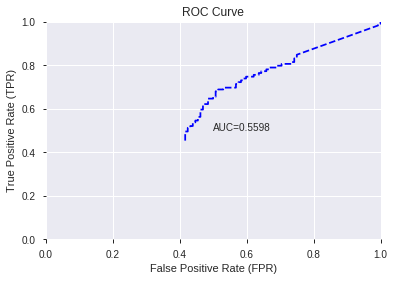

This function is available for GLM models only


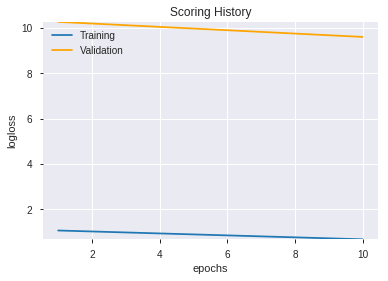

--2019-08-27 20:51:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.2.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.2.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_201757',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_201757',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_b6d1'

['MFI_24',
 'CDLINNECK',
 'BBANDS_upperband_24_2_3',
 'week',
 'HT_TRENDMODE',
 'CDLMORNINGDOJISTAR',
 'CORREL_30',
 'aroondown_8',
 'ADXR_14',
 'AROONOSC_8',
 'MA_12_0',
 'COSH',
 'BBANDS_middleband_24_5_2',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_middleband_30_7_2',
 'BBANDS_lowerband_24_1_4',
 'TRIX_14',
 'CCI_20',
 'BBANDS_lowerband_20_1_5',
 'NATR_14',
 'CDLLONGLINE',
 'ROC_24',
 'BBANDS_middleband_12_4_3',
 'MIDPRICE_20',
 'BBANDS_lowerband_8_6_4',
 'STOCHF_fastd',
 'BBANDS_upperband_8_8_5',
 'BBANDS_lowerband_20_7_5',
 'BBANDS_middleband_14_3_5',
 'BBANDS_middleband_14_0_3',
 'CDLSEPARATINGLINES',
 'BBANDS_lowerband_24_2_3',
 'CDLINVERTEDHAMMER',
 'MAVP_8_4',
 'AD',
 'BBANDS_middleband_20_1_2',
 'BBANDS_middleband_30_0_3',
 'PLUS_DI_30',
 'BBANDS_upperband_24_6_5',
 'MOM_24',
 'MAVP_8_6',
 'MA_14_2',
 'BBANDS_middleband_12_3_5',
 'BBANDS_lowerband_30_1_5',
 'HT_PHASOR_inphase',
 'BBANDS_lowerband_12_4_5',
 'WILLR_24',
 'BBANDS_upperband_14_2_5',
 'STOCHRSI_fastd',
 'BBANDS_lowerban

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_205220_model_1  0.502101  4.306582                   0.5  0.587318  0.344942

variable  relative_importance  scaled_importance  percentage
0               CDLEVENINGSTAR             0.009051           1.000000    0.017184
1                         TANH             0.007094           0.783746    0.013468
2           CDLMORNINGDOJISTAR             0.006210           0.686079    0.011790
3                 CDLENGULFING             0.005577           0.616160    0.010588
4              CDLHOMINGPIGEON             0.005251           0.580199    0.009970
...                        ...                  ...                ...         ...
1035  BBANDS_middleband_20_1_4             0.000000           0.000000    0.000000
1036  BBANDS_middleband_20_1_5             0.000000           0.000000    0.000000
1037  BBANDS_middleband_24_1_4             0.000000           0.000000    0.000000
1038  BBANDS_middleband_24_1_5             0.000000           0.000000    0.000000
1039  BBANDS_middleband_30_5_5             0.000000           0.000000    0.000000

[1040 rows x 4 columns]

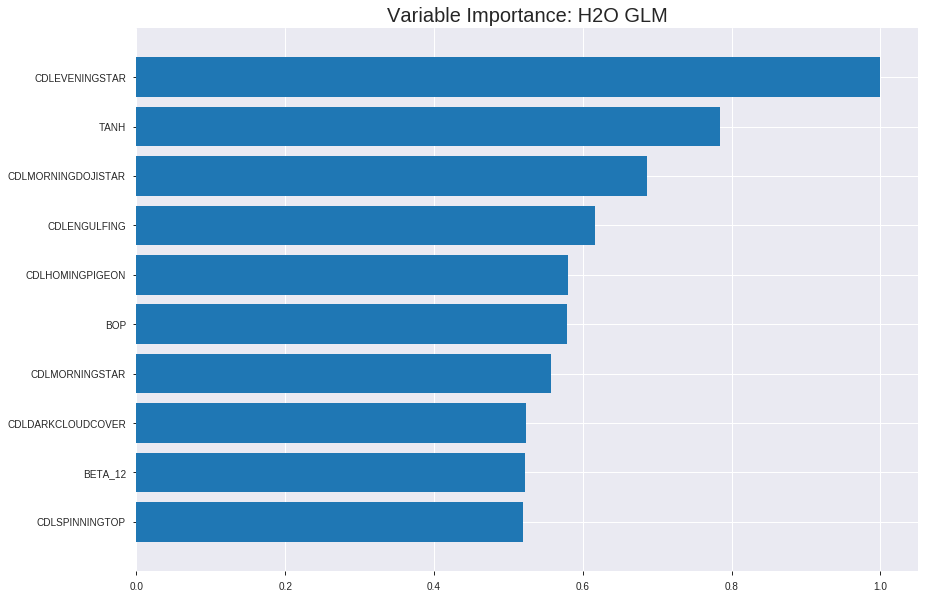

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_205220_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24631685459966146
RMSE: 0.4963031881820441
LogLoss: 0.6857499291598534
Null degrees of freedom: 1752
Residual degrees of freedom: 725
Null deviance: 2422.3593080819073
Residual deviance: 2404.239251634446
AIC: 4460.239251634446
AUC: 0.5886353830262934
pr_auc: 0.610888940384825
Gini: 0.17727076605258674
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4964505357691774: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      31   787   0.9621   (787.0/818.0)
1      11   924   0.0118   (11.0/935.0)
Total  42   1711  0.4552   (798.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496451     0.698413  371
max f2                       0.482276     0.852169  392
max f0point5                 0.525233     0.617949  253
max accuracy                 0.525533     0.590416  251
max precision                0.598508     1         0
max recall                   0.482276     1         392
max specificity              0.598508     1         0
max absolute_mcc             0.525233     0.168844  253
max min_per_class_accuracy   0.53411      0.561125  195
max mean_per_class_accuracy  0.525533     0.576881  251

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.576806           1.56239   1.56239            0.833333         0.584062  0.833333                    0.584062            0.0160428       0.0160428                  56.2389    56.2389
    2        0.0205362                   0.571193           1.45823   1.51031            0.777778         0.573951  0.805556                    0.579007            0.0149733       0.031016                   45.8229    51.0309
    3        0.0302339                   0.565704           0.992576  1.34424            0.529412         0.568168  0.716981                    0.57553             0.00962567      0.0406417                  -0.742372  34.4244
    4        0.040502                    0.562513           1.56239   1.39955            0.833333         0.563911  0.746479                    0.572584            0.0160428       0.0566845                  56.2389    39.9548
    5        0.0501997                   0.560218           1.10286   1.34223            0.588235         0.561435  0.715909                    0.57043             0.0106952       0.0673797                  10.2863    34.2234
    6        0.100399                    0.553826           1.2144    1.27832            0.647727         0.556613  0.681818                    0.563522            0.0609626       0.128342                   21.4402    27.8318
    7        0.150029                    0.550122           0.948208  1.16912            0.505747         0.551773  0.623574                    0.559635            0.0470588       0.175401                   -5.17918   16.9118
    8        0.200228                    0.546785           1.06526   1.14308            0.568182         0.548349  0.609687                    0.556806            0.0534759       0.228877                   6.52649    14.3081
    9        0.300057                    0.541475           1.07135   1.11922            0.571429         0.543917  0.596958                    0.552518            0.106952        0.335829                   7.13522    11.9217
    10       0.399886                    0.537471           1.10349   1.11529            0.588571         0.539506  0.594864                    0.549269            0.11016         0.445989                   10.3493    11.5291
    11       0.500285                    0.534199           1.10788   1.1138             0.590909         0.535762  0.594071                    0.546559            0.11123         0.557219                   10.7876    11.3803
    12       0.600114                    0.530034           1.06064   1.10496            0.565714         0.532112  0.589354                    0.544156            0.105882        0.663102                   6.06387    10.4959
    13       0.699943                    0.525798           1.06064   1.09864            0.565714         0.528047  0.585982                    0.541858            0.105882        0.768984                   6.06387    9.8638
    14       0.799772                    0.519806           0.824941  1.06447            0.44             0.522948  0.56776                     0.539498            0.0823529       0.851337                   -17.5059   6.44747
    15       0.899601                    0.512288           0.782087  1.03314            0.417143         0.516628  0.551046                    0.53696             0.0780749       0.929412                   -21.7913   3.31381
    16       1                           0.451982           0.703075  1                  0.375            0.501218  0.533371                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.39751520996469697
RMSE: 0.6304880728171605
LogLoss: 8.976309399899163
Null degrees of freedom: 500
Residual degrees of freedom: -527
Null deviance: 691.823895750088
Residual deviance: 119536.66075749641
AIC: 121592.66075749641
AUC: 0.5337616972183054
pr_auc: 0.5662364130349946
Gini: 0.0675233944366107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.1740971745689115e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    269  0        (0.0/269.0)
Total  0    501  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.1741e-50   0.698701   294
max f2                       2.1741e-50   0.852885   294
max f0point5                 2.1741e-50   0.591729   294
max accuracy                 7.09239e-24  0.538922   279
max precision                0.577099     1          0
max recall                   2.1741e-50   1          294
max specificity              0.577099     1          0
max absolute_mcc             0.552635     0.0863676  7
max min_per_class_accuracy   0.000259725  0.531599   250
max mean_per_class_accuracy  0.515893     0.536253   120

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 22.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.556066           1.55204   1.55204            0.833333         0.561271      0.833333                    0.561271            0.0185874       0.0185874                  55.2045   55.2045
    2        0.0219561                   0.54797            0.744981  1.1852             0.4              0.550666      0.636364                    0.556451            0.00743494      0.0260223                  -25.5019  18.5198
    3        0.0319361                   0.544449           0.372491  0.931227           0.2              0.546161      0.5                         0.553235            0.00371747      0.0297398                  -62.7509  -6.87732
    4        0.0419162                   0.542292           1.48996   1.06426            0.8              0.543263      0.571429                    0.550861            0.0148699       0.0446097                  48.9963   6.42592
    5        0.0518962                   0.539721           1.11747   1.07449            0.6              0.540748      0.576923                    0.548916            0.0111524       0.0557621                  11.7472   7.44924
    6        0.101796                    0.530548           0.968476  1.02252            0.52             0.535294      0.54902                     0.542238            0.0483271       0.104089                   -3.15242  2.25235
    7        0.151697                    0.524699           1.26647   1.10277            0.68             0.527738      0.592105                    0.537468            0.063197        0.167286                   26.6468   10.2769
    8        0.201597                    0.519707           1.11747   1.10641            0.6              0.522123      0.594059                    0.53367             0.0557621       0.223048                   11.7472   10.6408
    9        0.301397                    0.50836            1.00572   1.07307            0.54             0.514577      0.576159                    0.527348            0.100372        0.32342                    0.572491  7.30693
    10       0.401198                    0.425695           1.04297   1.06558            0.56             0.487642      0.572139                    0.517471            0.104089        0.427509                   4.2974    6.55829
    11       0.500998                    0.000259725        1.04297   1.06108            0.56             0.174261      0.569721                    0.449102            0.104089        0.531599                   4.2974    6.10791
    12       0.600798                    6.64103e-60        0.931227  1.03951            0.5              1.24041e-05   0.55814                     0.374503            0.0929368       0.624535                   -6.87732  3.95089
    13       0.700599                    1.16683e-233       1.19197   1.06123            0.64             3.29168e-62   0.569801                    0.321155            0.118959        0.743494                   19.197    6.12271
    14       1                           0                  0.856729  1                  0.46             7.66204e-236  0.536926                    0.225001            0.256506        1                          -14.3271  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:52:23  0.000 sec   2            3.9       1028          1.3715            238.596
    2019-08-27 20:52:25  2.245 sec   4            2.8       1032          1.36875           255.41
    2019-08-27 20:52:27  4.494 sec   6            2.1       1033          1.36549           269.755
    2019-08-27 20:52:29  6.736 sec   8            1.5       1034          1.3617            281.263
    2019-08-27 20:52:32  9.004 sec   10           1.1       1036          1.35741           291.169

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6432432432432432)

('auc', 0.5021008403361344)

('logloss', 4.306582238343773)

('mean_per_class_error', 0.4678826075884899)

('rmse', 0.5873177999094504)

('mse', 0.34494219809047727)

glm prediction progress: |████████████████████████████████████████████████| 100%


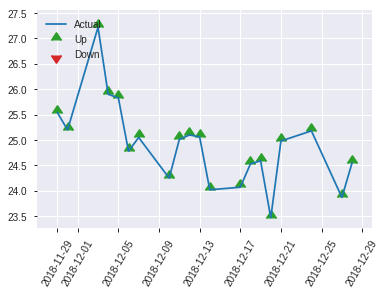


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.34494219809047727
RMSE: 0.5873177999094504
LogLoss: 4.306582238343773
Null degrees of freedom: 250
Residual degrees of freedom: -777
Null deviance: 350.81837939662717
Residual deviance: 21339.765459254122
AIC: 23395.765459254122
AUC: 0.5021008403361344
pr_auc: 0.48866122874920637
Gini: 0.004201680672268893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.3184700463284635e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    119  0        (0.0/119.0)
Total  0    251  0.5259   (132.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.31847e-51  0.643243  212
max f2                       3.31847e-51  0.818432  212
max f0point5                 3.32875e-29  0.53102   207
max accuracy                 0.562835     0.541833  7
max precision                0.562835     0.75      7
max recall                   3.31847e-51  1         212
max specificity              0.582687     0.992424  0
max absolute_mcc             0.562835     0.100254  7
max min_per_class_accuracy   0.491396     0.478992  123
max mean_per_class_accuracy  0.511858     0.532117  77

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 30.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.577512           1.40616   1.40616            0.666667         0.580302     0.666667                    0.580302            0.0168067       0.0168067                  40.6162   40.6162
    2        0.0239044                   0.57057            1.40616   1.40616            0.666667         0.574263     0.666667                    0.577282            0.0168067       0.0336134                  40.6162   40.6162
    3        0.0318725                   0.561876           2.10924   1.58193            1                0.565325     0.75                        0.574293            0.0168067       0.0504202                  110.924   58.1933
    4        0.0438247                   0.559157           0.703081  1.34225            0.333333         0.560141     0.636364                    0.570433            0.00840336      0.0588235                  -29.6919  34.2246
    5        0.0517928                   0.554778           1.05462   1.298              0.5              0.55589      0.615385                    0.568196            0.00840336      0.0672269                  5.46218   29.7996
    6        0.103586                    0.536162           0.811248  1.05462            0.384615         0.546716     0.5                         0.557456            0.0420168       0.109244                   -18.8752  5.46218
    7        0.151394                    0.529347           0.878852  0.999115           0.416667         0.532034     0.473684                    0.549428            0.0420168       0.151261                   -12.1148  -0.0884564
    8        0.203187                    0.519547           0.973497  0.992585           0.461538         0.523822     0.470588                    0.542901            0.0504202       0.201681                   -2.65029  -0.741473
    9        0.302789                    0.513359           1.26555   1.08238            0.6              0.515978     0.513158                    0.534045            0.12605         0.327731                   26.5546   8.23751
    10       0.40239                     0.505431           0.843697  1.0233             0.4              0.509287     0.485149                    0.527917            0.0840336       0.411765                   -15.6303  2.32964
    11       0.501992                    0.49013            0.674958  0.954182           0.32             0.498751     0.452381                    0.52213             0.0672269       0.478992                   -32.5042  -4.58183
    12       0.601594                    0.208132           1.09681   0.977795           0.52             0.369805     0.463576                    0.496911            0.109244        0.588235                   9.68067   -2.22049
    13       0.701195                    0.0116652          1.18118   1.00668            0.56             0.0665312    0.477273                    0.435777            0.117647        0.705882                   18.1176   0.668449
    14       0.800797                    5.02388e-13        0.928067  0.996906           0.44             0.00248799   0.472637                    0.381885            0.092437        0.798319                   -7.19328  -0.309377
    15       1                           0                  1.01244   1                  0.48             5.97836e-16  0.474104                    0.305813            0.201681        1                          1.2437    0

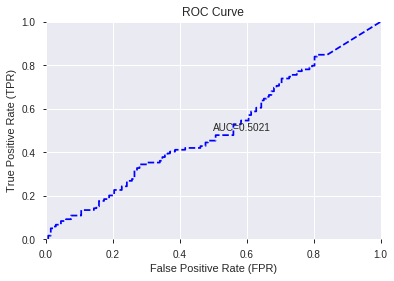

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


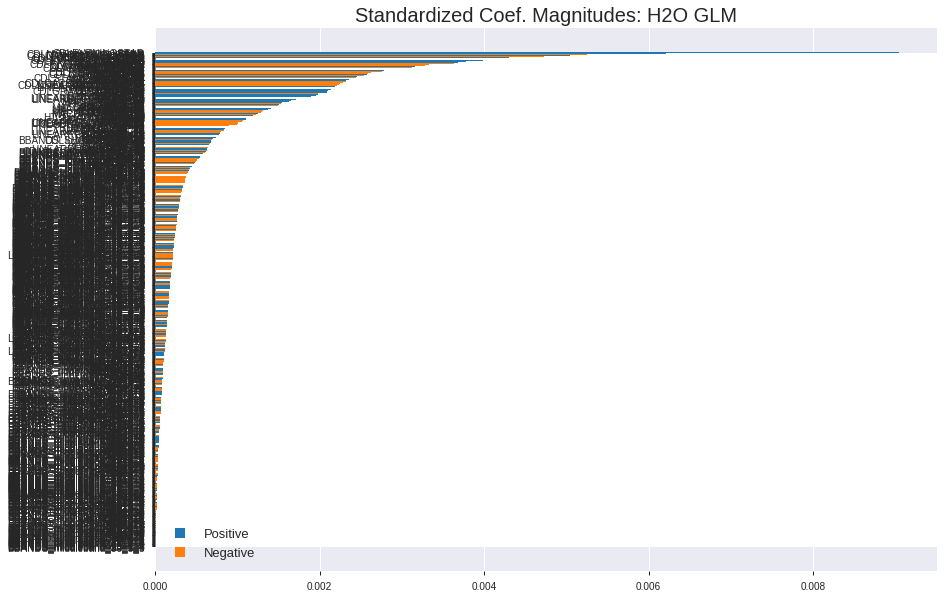

'log_likelihood'
--2019-08-27 20:53:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.65.160
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.65.160|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_205220_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_205220_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLEVENINGSTAR',
 'TANH',
 'CDLMORNINGDOJISTAR',
 'CDLENGULFING',
 'CDLHOMINGPIGEON',
 'BOP',
 'CDLMORNINGSTAR',
 'CDLDARKCLOUDCOVER',
 'BETA_12',
 'CDLSPINNINGTOP',
 'CDLLONGLEGGEDDOJI',
 'CDL3LINESTRIKE',
 'COSH',
 'SINH',
 'EXP',
 'CDLEVENINGDOJISTAR',
 'CDLDOJI',
 'weekday_name',
 'BETA_30',
 'STOCHRSI_fastk',
 'CDLINNECK',
 'VAR_8',
 'CDLINVERTEDHAMMER',
 'OBV',
 'CDLTASUKIGAP',
 'CDLHARAMICROSS',
 'BETA_14',
 'CDLONNECK',
 'STOCH_slowd',
 'CDLHIGHWAVE',
 'CDLUNIQUE3RIVER',
 'CDLADVANCEBLOCK',
 'CDLLONGLINE',
 'VAR_12',
 'CDLBELTHOLD',
 'CDL2CROWS',
 'ATAN',
 'BETA_8',
 'day',
 'CDLRICKSHAWMAN',
 'COS',
 'aroonup_12',
 'aroondown_30',
 'STDDEV_8',
 'CDLMATCHINGLOW',
 'CORREL_30',
 'CORREL_20',
 'aroonup_8',
 'CDLDOJISTAR',
 'is_month_start',
 'aroonup_24',
 'MACDFIX_hist_8',
 'CDLSTALLEDPATTERN',
 'VAR_14',
 'STOCHRSI_fastd',
 'AROONOSC_14',
 'TRANGE',
 'aroonup_20',
 'MACD_hist',
 'week',
 'weekofyear',
 'CORREL_14',
 'DX_14',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_14',
 'LINEARRE

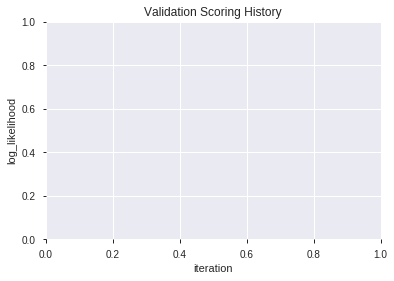

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_205400_model_5  0.508658  0.718926              0.496212  0.512085  0.262231
1  XGBoost_grid_1_AutoML_20190827_205400_model_4  0.502801  0.708553              0.500000  0.507323  0.257376
2  XGBoost_grid_1_AutoML_20190827_205400_model_7  0.501846  0.710448              0.496212  0.508054  0.258119
3  XGBoost_grid_1_AutoML_20190827_205400_model_3  0.494461  0.707766              0.500000  0.506926  0.256974
4  XGBoost_grid_1_AutoML_20190827_205400_model_2  0.481029  0.703159              0.500000  0.504907  0.254931
5  XGBoost_grid_1_AutoML_20190827_205400_model_6  0.472052  0.719912              0.500000  0.512481  0.262637
6               XGBoost_2_AutoML_20190827_205400  0.471225  0.713001              0.477687  0.509690  0.259784
7               XGBoost_1_AutoML_20190827_205400  0.468487  0.720927              0.500000  0.513303  0.263480
8               XGBoost_3_AutoML_20190827_205400  0.452636  0.715522              0.496212  0.510898  0.261017
9  XGBoost_grid_1_AutoML_20190827_205400_model_1  0.445442  0.732066              0.500000  0.518243  0.268575

variable  relative_importance  scaled_importance  percentage
0                    Volume           454.160034           1.000000    0.019461
1                       day           386.371216           0.850738    0.016556
2                      Open           331.687317           0.730331    0.014213
3                 dayofyear           328.388947           0.723069    0.014072
4                       BOP           279.845337           0.616182    0.011991
..                      ...                  ...                ...         ...
553            LINEARREG_24             0.955021           0.002103    0.000041
554                MAVP_8_6             0.950331           0.002093    0.000041
555               MAVP_20_3             0.792225           0.001744    0.000034
556                  MA_8_5             0.454556           0.001001    0.000019
557  BBANDS_lowerband_8_3_3             0.270433           0.000595    0.000012

[558 rows x 4 columns]

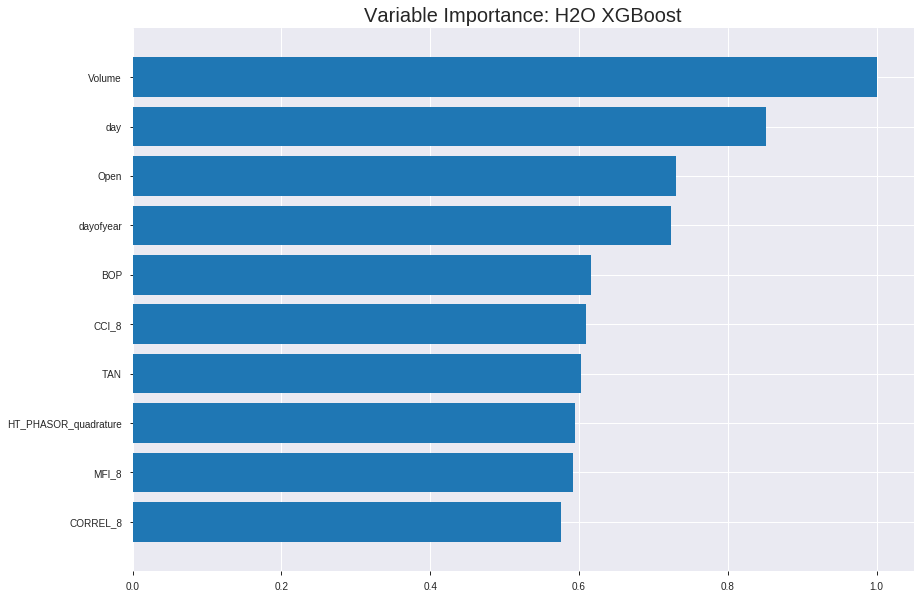

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_205400_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04340581606155267
RMSE: 0.20834062508678589
LogLoss: 0.22338157668973907
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9946524064171123
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5658988952636719: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      818  0    0        (0.0/818.0)
1      0    935  0        (0.0/935.0)
Total  818  935  0        (0.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.565899     1        206
max f2                       0.565899     1        206
max f0point5                 0.565899     1        206
max accuracy                 0.565899     1        206
max precision                0.931613     1        0
max recall                   0.565899     1        206
max specificity              0.931613     1        0
max absolute_mcc             0.565899     1        206
max min_per_class_accuracy   0.565899     1        206
max mean_per_class_accuracy  0.565899     1        206

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.919476           1.87487   1.87487            1                0.925653  1                           0.925653            0.0192513       0.0192513                  87.4866   87.4866
    2        0.0205362                   0.909677           1.87487   1.87487            1                0.914436  1                           0.920045            0.0192513       0.0385027                  87.4866   87.4866
    3        0.0302339                   0.901835           1.87487   1.87487            1                0.905553  1                           0.915396            0.0181818       0.0566845                  87.4866   87.4866
    4        0.040502                    0.897128           1.87487   1.87487            1                0.899499  1                           0.911366            0.0192513       0.0759358                  87.4866   87.4866
    5        0.0501997                   0.890684           1.87487   1.87487            1                0.894004  1                           0.908012            0.0181818       0.0941176                  87.4866   87.4866
    6        0.100399                    0.871959           1.87487   1.87487            1                0.879852  1                           0.893932            0.0941176       0.188235                   87.4866   87.4866
    7        0.150029                    0.855694           1.87487   1.87487            1                0.8633    1                           0.883799            0.0930481       0.281283                   87.4866   87.4866
    8        0.200228                    0.839956           1.87487   1.87487            1                0.846674  1                           0.874491            0.0941176       0.375401                   87.4866   87.4866
    9        0.300057                    0.812771           1.87487   1.87487            1                0.826838  1                           0.858637            0.187166        0.562567                   87.4866   87.4866
    10       0.399886                    0.776121           1.87487   1.87487            1                0.794499  1                           0.842626            0.187166        0.749733                   87.4866   87.4866
    11       0.500285                    0.698692           1.87487   1.87487            1                0.745983  1                           0.823231            0.188235        0.937968                   87.4866   87.4866
    12       0.600114                    0.277388           0.621384  1.66635            0.331429         0.436219  0.888783                    0.758852            0.0620321       1                          -37.8616  66.635
    13       0.699943                    0.227546           0         1.42869            0                0.250425  0.762021                    0.686338            0               1                          -100      42.8688
    14       0.799772                    0.189019           0         1.25036            0                0.208741  0.666904                    0.626723            0               1                          -100      25.0357
    15       0.899601                    0.151962           0         1.1116             0                0.169672  0.592898                    0.576004            0               1                          -100      11.1604
    16       1                           0.0810934          0         1                  0                0.128304  0.533371                    0.531055          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26915829011185977
RMSE: 0.5188046743350139
LogLoss: 0.7354907882231546
Mean Per-Class Error: 0.476974105883861
AUC: 0.5026358800153826
pr_auc: 0.5494098009704093
Gini: 0.005271760030765238
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10475760698318481: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    269  0        (0.0/269.0)
Total  0    501  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.104758     0.698701   399
max f2                       0.104758     0.852885   399
max f0point5                 0.261009     0.592912   383
max accuracy                 0.270127     0.540918   380
max precision                0.821481     1          0
max recall                   0.104758     1          399
max specificity              0.821481     1          0
max absolute_mcc             0.330472     0.0723037  333
max min_per_class_accuracy   0.443315     0.5        203
max mean_per_class_accuracy  0.543806     0.523026   108

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 45.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.725734           1.24164   1.24164            0.666667         0.767152  0.666667                    0.767152            0.0148699       0.0148699                  24.1636   24.1636
    2        0.0219561                   0.709264           1.11747   1.1852             0.6              0.713573  0.636364                    0.742798            0.0111524       0.0260223                  11.7472   18.5198
    3        0.0319361                   0.69678            1.48996   1.28044            0.8              0.699639  0.6875                      0.729311            0.0148699       0.0408922                  48.9963   28.0437
    4        0.0419162                   0.690638           0.744981  1.15295            0.4              0.692763  0.619048                    0.720609            0.00743494      0.0483271                  -25.5019  15.2947
    5        0.0518962                   0.676375           1.11747   1.14613            0.6              0.680714  0.615385                    0.712937            0.0111524       0.0594796                  11.7472   14.6125
    6        0.101796                    0.633033           1.04297   1.09556            0.56             0.650928  0.588235                    0.68254             0.0520446       0.111524                   4.2974    9.55609
    7        0.151697                    0.585112           0.893978  1.02925            0.48             0.606587  0.552632                    0.657556            0.0446097       0.156134                   -10.6022  2.92506
    8        0.201597                    0.560968           1.19197   1.06953            0.64             0.574852  0.574257                    0.637084            0.0594796       0.215613                   19.197    6.95278
    9        0.301397                    0.513936           0.893978  1.0114             0.48             0.540058  0.543046                    0.604956            0.0892193       0.304833                   -10.6022  1.13986
    10       0.401198                    0.471401           0.968476  1.00072            0.52             0.493695  0.537313                    0.577279            0.0966543       0.401487                   -3.15242  0.0721301
    11       0.500998                    0.443315           1.00572   1.00172            0.54             0.45959   0.537849                    0.553835            0.100372        0.501859                   0.572491  0.171803
    12       0.600798                    0.413417           0.968476  0.996196           0.52             0.426918  0.534884                    0.532753            0.0966543       0.598513                   -3.15242  -0.380392
    13       0.700599                    0.382128           1.00572   0.997553           0.54             0.397279  0.535613                    0.513455            0.100372        0.698885                   0.572491  -0.244654
    14       0.800399                    0.342198           0.856729  0.979994           0.46             0.362556  0.526185                    0.494639            0.0855019       0.784387                   -14.3271  -2.00057
    15       0.9002                      0.304691           1.15472   0.999365           0.62             0.32475   0.536585                    0.475805            0.115242        0.899628                   15.4721   -0.063469
    16       1                           0.104758           1.00572   1                  0.54             0.264928  0.536926                    0.45475


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:54:36  18.786 sec  0                  0.5              0.693147            0.5             0                  1                0.466629                         0.5                0.693147              0.5               0                    1                  0.463074
    2019-08-27 20:54:38  20.548 sec  5                  0.449162         0.595851            0.964988        0.966247           1.87487          0.0969766                        0.500655           0.694472              0.53256           0.56156              1.24164            0.461078
    2019-08-27 20:54:39  21.304 sec  10                 0.41009          0.526193            0.989158        0.988883           1.87487          0.0462065                        0.506892           0.707315              0.495081          0.531419             0.931227           0.463074
    2019-08-27 20:54:39  22.179 sec  15                 0.370828         0.460122            0.996793        0.99519            1.87487          0.0245294                        0.506826           0.707361              0.509262          0.545549             0.931227           0.463074
    2019-08-27 20:54:40  23.029 sec  20                 0.338099         0.407839            0.998901        0.997852           1.87487          0.0125499                        0.50817            0.710311              0.497588          0.547899             0.931227           0.463074
    2019-08-27 20:54:41  23.905 sec  25                 0.307214         0.360832            0.99978         0.998732           1.87487          0.00399315                       0.509893           0.714069              0.488711          0.54651              0.931227           0.463074
    2019-08-27 20:54:42  24.745 sec  30                 0.282208         0.324221            0.999948        0.998885           1.87487          0.0022818                        0.512608           0.720177              0.498462          0.550493             0.620818           0.463074
    2019-08-27 20:54:43  25.528 sec  35                 0.266385         0.301677            0.999989        0.997851           1.87487          0.0011409                        0.513253           0.721693              0.495337          0.549346             0.931227           0.463074
    2019-08-27 20:54:44  26.436 sec  40                 0.244343         0.271092            1               0.99893            1.87487          0                                0.516432           0.729162              0.497116          0.549204             1.24164            0.453094
    2019-08-27 20:54:45  27.256 sec  45                 0.226607         0.247216            1               0.99893            1.87487          0                                0.516622           0.730056              0.505624          0.555027             1.24164            0.463074
    2019-08-27 20:54:45  28.105 sec  50                 0.208341         0.223382            1               0.994652           1.87487          0                                0.518805           0.735491              0.502636          0.54941              1.24164            0.463074

Variable Importances: 


variable                relative_importance    scaled_importance      percentage
----------------------  ---------------------  ---------------------  ----------------------
Volume                  454.1600341796875      1.0                    0.019460891553519967
day                     386.3712158203125      0.8507380366882866     0.016556120672445235
Open                    331.68731689453125     0.7303313632465067     0.014212899458274664
dayofyear               328.3889465332031      0.723068790335868      0.014071563314461194
BOP                     279.8453369140625      0.616182217397276      0.011991455309975852
---                     ---                    ---                    ---
LINEARREG_24            0.95502108335495       0.0021028294246100434  4.092293538788684e-05
MAVP_8_6                0.950331449508667      0.002092503474519007   4.072198319297812e-05
MAVP_20_3               0.7922245860099792     0.0017443731865154325  3.394705741164489e-05
MA_8_5                  0.45455577969551086    0.0010008713789986788  1.9477849365715266e-05
BBANDS_lowerband_8_3_3  0.27043312788009644    0.0005954577847620562  1.158813937395361e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6449864498644986)

('auc', 0.5086580086580086)

('logloss', 0.7189259372101849)

('mean_per_class_error', 0.4589381207028266)

('rmse', 0.5120852188912035)

('mse', 0.2622312714068518)

xgboost prediction progress: |████████████████████████████████████████████| 100%


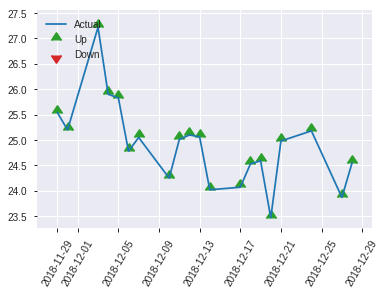


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2622312714068518
RMSE: 0.5120852188912035
LogLoss: 0.7189259372101849
Mean Per-Class Error: 0.4589381207028266
AUC: 0.5086580086580086
pr_auc: 0.5081648105258553
Gini: 0.017316017316017174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3030230402946472: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    131  0.9924   (131.0/132.0)
1      0    119  0        (0.0/119.0)
Total  1    250  0.5219   (131.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303023     0.644986  249
max f2                       0.303023     0.819559  249
max f0point5                 0.303023     0.531725  249
max accuracy                 0.676179     0.557769  29
max precision                0.803331     1         0
max recall                   0.303023     1         249
max specificity              0.803331     1         0
max absolute_mcc             0.386871     0.125395  226
max min_per_class_accuracy   0.516365     0.515152  125
max mean_per_class_accuracy  0.654049     0.541062  43

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 52.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.769536           1.40616   1.40616            0.666667         0.787437  0.666667                    0.787437            0.0168067       0.0168067                  40.6162   40.6162
    2        0.0239044                   0.756241           2.10924   1.7577             1                0.760494  0.833333                    0.773965            0.0252101       0.0420168                  110.924   75.7703
    3        0.0318725                   0.748077           1.05462   1.58193            0.5              0.749343  0.75                        0.76781             0.00840336      0.0504202                  5.46218   58.1933
    4        0.0438247                   0.732072           0.703081  1.34225            0.333333         0.74177   0.636364                    0.760708            0.00840336      0.0588235                  -29.6919  34.2246
    5        0.0517928                   0.718228           0         1.13575            0                0.722603  0.538462                    0.754846            0               0.0588235                  -100      13.5747
    6        0.103586                    0.680704           1.298     1.21687            0.615385         0.70161   0.576923                    0.728228            0.0672269       0.12605                    29.7996   21.6871
    7        0.151394                    0.657924           1.23039   1.22114            0.583333         0.66966   0.578947                    0.709733            0.0588235       0.184874                   23.0392   22.1141
    8        0.203187                    0.639657           0.973497  1.15802            0.461538         0.648716  0.54902                     0.694179            0.0504202       0.235294                   -2.65029  15.8016
    9        0.302789                    0.595811           0.928067  1.08238            0.44             0.61729   0.513158                    0.668887            0.092437        0.327731                   -7.19328  8.23751
    10       0.40239                     0.548532           0.843697  1.0233             0.4              0.571339  0.485149                    0.644741            0.0840336       0.411765                   -15.6303  2.32964
    11       0.501992                    0.516365           1.09681   1.03788            0.52             0.530479  0.492063                    0.62207             0.109244        0.521008                   9.68067   3.78818
    12       0.601594                    0.485451           0.759328  0.991764           0.36             0.499451  0.470199                    0.601769            0.0756303       0.596639                   -24.0672  -0.823641
    13       0.701195                    0.45551            0.928067  0.982716           0.44             0.472166  0.465909                    0.583359            0.092437        0.689076                   -7.19328  -1.72842
    14       0.800797                    0.428288           0.928067  0.975919           0.44             0.442181  0.462687                    0.5658              0.092437        0.781513                   -7.19328  -2.40813
    15       0.900398                    0.390633           0.843697  0.961292           0.4              0.40737   0.455752                    0.548274            0.0840336       0.865546                   -15.6303  -3.87075
    16       1                           0.247376           1.34992   1                  0.64             0.350291  0.474104                    0.528555    

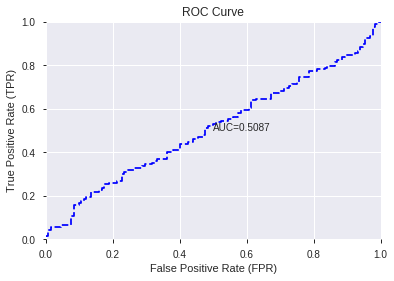

This function is available for GLM models only


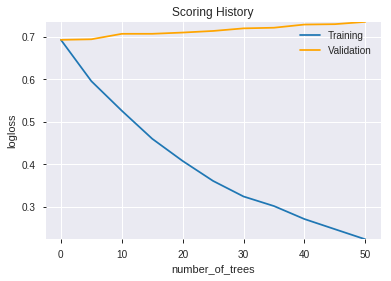

--2019-08-27 20:55:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_205400_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_205400_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'day',
 'Open',
 'dayofyear',
 'BOP',
 'CCI_8',
 'TAN',
 'HT_PHASOR_quadrature',
 'MFI_8',
 'CORREL_8',
 'SIN',
 'WILLR_8',
 'STOCH_slowd',
 'STOCH_slowk',
 'DX_8',
 'BETA_8',
 'ROC_8',
 'BETA_12',
 'High',
 'MACDEXT_hist',
 'CMO_8',
 'HT_PHASOR_inphase',
 'ADX_8',
 'MFI_12',
 'STOCHRSI_fastd',
 'MINUS_DI_8',
 'CORREL_20',
 'ULTOSC',
 'dayofweek',
 'MOM_20',
 'BETA_20',
 'COS',
 'MFI_14',
 'BETA_30',
 'MFI_30',
 'MFI_20',
 'DIV',
 'TRANGE',
 'ADXR_14',
 'CCI_12',
 'CORREL_24',
 'ROC_30',
 'WILLR_12',
 'ADOSC',
 'CORREL_12',
 'MOM_14',
 'MFI_24',
 'ROC_20',
 'Close',
 'SAREXT',
 'STOCHF_fastk',
 'BETA_14',
 'ADXR_8',
 'DX_12',
 'HT_DCPERIOD',
 'CORREL_14',
 'ROC_12',
 'CORREL_30',
 'BETA_24',
 'MINUS_DM_8',
 'ADXR_12',
 'SUB',
 'Low',
 'MACDFIX_hist_12',
 'LINEARREG_ANGLE_8',
 'aroonup_20',
 'MACDFIX_hist_8',
 'MINUS_DI_30',
 'DX_14',
 'STDDEV_20',
 'NATR_8',
 'DX_30',
 'MOM_24',
 'STDDEV_8',
 'PLUS_DM_8',
 'AdjClose',
 'PLUS_DI_12',
 'ROC_24',
 'MOM_12',
 'ADX_20',
 'TRIX_8

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

791

['BBANDS_upperband_8_5_5',
 'BBANDS_middleband_8_5_5',
 'BBANDS_lowerband_8_5_5',
 'MA_8_6',
 'MAVP_8_6',
 'T3_8_6',
 'BBANDS_upperband_8_6_2',
 'BBANDS_middleband_8_6_2',
 'BBANDS_lowerband_8_6_2',
 'BBANDS_upperband_8_6_3',
 'BBANDS_middleband_8_6_3',
 'BBANDS_lowerband_8_6_3',
 'BBANDS_upperband_8_6_4',
 'BBANDS_middleband_8_6_4',
 'BBANDS_lowerband_8_6_4',
 'BBANDS_upperband_8_6_5',
 'BBANDS_middleband_8_6_5',
 'BBANDS_lowerband_8_6_5',
 'MA_8_7',
 'MAVP_8_7',
 'T3_8_7',
 'BBANDS_upperband_8_7_2',
 'BBANDS_middleband_8_7_2',
 'BBANDS_lowerband_8_7_2',
 'BBANDS_upperband_8_7_3',
 'BBANDS_middleband_8_7_3',
 'BBANDS_lowerband_8_7_3',
 'BBANDS_upperband_8_7_4',
 'BBANDS_middleband_8_7_4',
 'BBANDS_lowerband_8_7_4',
 'BBANDS_upperband_8_7_5',
 'BBANDS_middleband_8_7_5',
 'BBANDS_lowerband_8_7_5',
 'MA_8_8',
 'MAVP_8_8',
 'T3_8_8',
 'BBANDS_upperband_8_8_2',
 'BBANDS_middleband_8_8_2',
 'BBANDS_lowerband_8_8_2',
 'BBANDS_upperband_8_8_3',
 'BBANDS_middleband_8_8_3',
 'BBANDS_lowerband_8

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190827_205816  0.555545   7.776126              0.484848  0.622337  0.387304
1  DeepLearning_grid_1_AutoML_20190827_205816_model_2  0.520977   8.071382              0.500000  0.676850  0.458126
2  DeepLearning_grid_1_AutoML_20190827_205816_model_8  0.508403   0.697668              0.500000  0.502253  0.252258
3  DeepLearning_grid_1_AutoML_20190827_205816_model_3  0.505061   7.374064              0.500000  0.648949  0.421135
4  DeepLearning_grid_1_AutoML_20190827_205816_model_9  0.500000   0.701346              0.500000  0.504070  0.254087
5  DeepLearning_grid_1_AutoML_20190827_205816_model_5  0.495798   0.714043              0.500000  0.505938  0.255974
6  DeepLearning_grid_1_AutoML_20190827_205816_model_4  0.495798   8.185925              0.500000  0.656587  0.431106
7  DeepLearning_grid_1_AutoML_20190827_205816_model_6  0.492870   0.702781              0.500000  0.504776  0.254799
8  DeepLearning_grid_1_AutoML_20190827_205816_model_1  0.468105  16.979477              0.500000  0.724518  0.524926
9  DeepLearning_grid_1_AutoML_20190827_205816_model_7  0.463203   4.428677              0.489464  0.636717  0.405408

variable  relative_importance  scaled_importance  percentage
0                       TANH             1.000000           1.000000    0.002817
1                    BETA_30             0.950446           0.950446    0.002677
2                       ATAN             0.867794           0.867794    0.002445
3                 aroonup_30             0.741973           0.741973    0.002090
4                       CEIL             0.724811           0.724811    0.002042
..                       ...                  ...                ...         ...
785  BBANDS_lowerband_12_5_2             0.213838           0.213838    0.000602
786           CDLRICKSHAWMAN             0.210026           0.210026    0.000592
787  BBANDS_upperband_12_7_2             0.209607           0.209607    0.000590
788  BBANDS_upperband_12_3_3             0.203196           0.203196    0.000572
789                   SMA_30             0.198176           0.198176    0.000558

[790 rows x 4 columns]

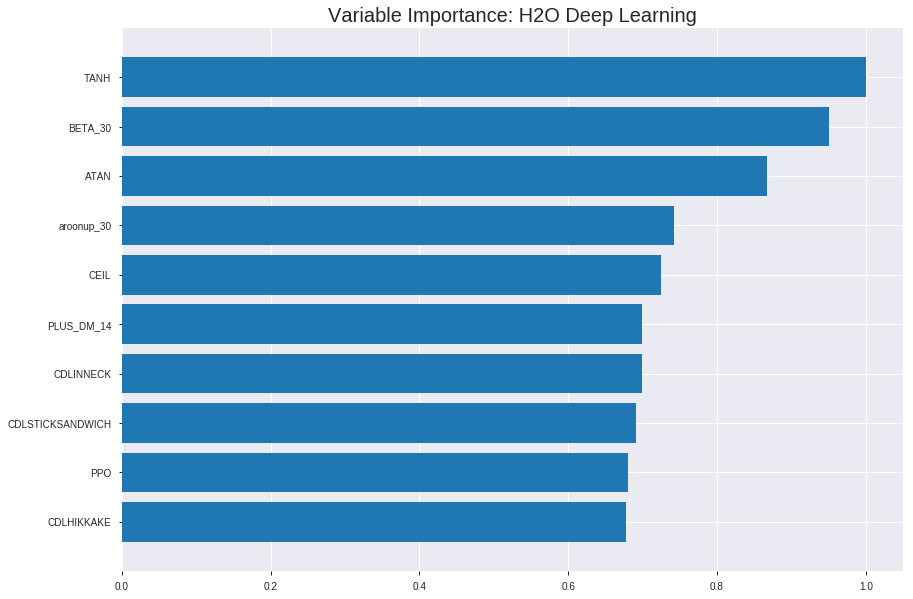

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_205816


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2623524855206978
RMSE: 0.5122035586763312
LogLoss: 0.7281338178073955
Mean Per-Class Error: 0.45250578559941423
AUC: 0.5582063988075782
pr_auc: 0.5943291759413207
Gini: 0.11641279761515633
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4915620324907106: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      55   763   0.9328   (763.0/818.0)
1      15   920   0.016    (15.0/935.0)
Total  70   1683  0.4438   (778.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491562     0.702827  352
max f2                       0.406046     0.852834  379
max f0point5                 0.498107     0.60122   345
max accuracy                 0.498107     0.559042  345
max precision                0.999824     1         0
max recall                   0.276212     1         396
max specificity              0.999824     1         0
max absolute_mcc             0.491562     0.130441  352
max min_per_class_accuracy   0.623128     0.530562  241
max mean_per_class_accuracy  0.677174     0.547494  187

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 63.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.917242           1.56239   1.56239            0.833333         0.956403  0.833333                    0.956403            0.0160428       0.0160428                  56.2389    56.2389
    2        0.0205362                   0.894954           1.45823   1.51031            0.777778         0.905541  0.805556                    0.930972            0.0149733       0.031016                   45.8229    51.0309
    3        0.0302339                   0.885487           1.43372   1.48574            0.764706         0.889694  0.792453                    0.917732            0.0139037       0.0449198                  43.3721    48.5743
    4        0.040502                    0.875682           1.04159   1.37314            0.555556         0.880195  0.732394                    0.908215            0.0106952       0.055615                   4.15924    37.3142
    5        0.0501997                   0.866597           1.21315   1.34223            0.647059         0.870961  0.715909                    0.901019            0.0117647       0.0673797                  21.3149    34.2234
    6        0.100399                    0.838813           1.10788   1.22505            0.590909         0.852856  0.653409                    0.876937            0.055615        0.122995                   10.7876    22.5055
    7        0.150029                    0.802327           1.18526   1.21189            0.632184         0.822136  0.646388                    0.858809            0.0588235       0.181818                   18.526     21.1891
    8        0.200228                    0.76763            0.980044  1.15376            0.522727         0.786398  0.615385                    0.840655            0.0491979       0.231016                   -1.99562   15.3764
    9        0.300057                    0.700993           1.06064   1.12278            0.565714         0.733147  0.598859                    0.804887            0.105882        0.336898                   6.06387    12.2781
    10       0.399886                    0.661429           0.996358  1.09122            0.531429         0.678724  0.582026                    0.773391            0.0994652       0.436364                   -0.364248  9.12203
    11       0.500285                    0.623907           0.926781  1.05822            0.494318         0.64389   0.564424                    0.747402            0.0930481       0.529412                   -7.32195   5.82199
    12       0.600114                    0.557779           0.921363  1.03545            0.491429         0.591494  0.552281                    0.721467            0.0919786       0.62139                    -7.86371   3.54537
    13       0.862521                    0.52025            1.02302   1.03167            0.545652         0.52389   0.550265                    0.661358            0.268449        0.88984                    2.30249    3.16725
    14       0.899601                    0.508053           0.980699  1.02957            0.523077         0.512976  0.549144                    0.655242            0.0363636       0.926203                   -1.93007   2.95715
    15       1                           0.192894           0.735033  1                  0.392045         0.469149  0.533371                    0.636558            0.0737968       1                          -26.4967   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.38089358994656347
RMSE: 0.6171657718527198
LogLoss: 9.509797547575687
Mean Per-Class Error: 0.48841494680169206
AUC: 0.474634662222792
pr_auc: 0.24372114987641824
Gini: -0.050730675554416016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48681496981337763: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    269  0        (0.0/269.0)
Total  0    501  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.486815     0.698701   70
max f2                       0.486815     0.852885   70
max f0point5                 0.505505     0.594966   48
max accuracy                 0.506001     0.54491    46
max precision                0.506001     0.542977   46
max recall                   0.486815     1          70
max specificity              1            0.426724   0
max absolute_mcc             0.530836     0.0587801  14
max min_per_class_accuracy   1            0.426724   0
max mean_per_class_accuracy  0.506001     0.511585   46

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 79.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.550898                    1                  0.971715  0.971715           0.521739         1         0.521739                    1                   0.535316        0.535316                   -2.82851  -2.82851
    2        0.89022                     0.52025            1.00792   0.985514           0.541176         0.546001  0.529148                    0.826951            0.342007        0.877323                   0.791603  -1.44865
    3        0.9002                      0.516397           1.11747   0.986976           0.6              0.518713  0.529933                    0.823534            0.0111524       0.888476                   11.7472   -1.30235
    4        1                           0.486815           1.11747   1                  0.6              0.503994  0.536926                    0.791644            0.111524        1                          11.7472   0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:58:16  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:58:16  0.361 sec   9324 obs/sec      1         1             1753       0.637939         1.95896             -0.63515       0.503126        0.471169           1.04159          0.464917                         0.689046           9.56359               -0.909551        0.485779          0.278591             0.950231           0.453094
    2019-08-27 20:58:18  2.045 sec   9994 obs/sec      10        10            17530      0.512204         0.728134            -0.0541056     0.558206        0.594329           1.56239          0.443811                         0.617166           9.5098                -0.53193         0.474635          0.243721             0.971715           0.463074

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
TANH                     1.0                    1.0                  0.0028169150822317
BETA_30                  0.950446367263794      0.950446367263794    0.0026773267067977105
ATAN                     0.8677937984466553     0.8677937984466553   0.0024445014391115192
aroonup_30               0.741972804069519      0.741972804069519    0.002090074382389174
CEIL                     0.7248107194900513     0.7248107194900513   0.0020417302474947355
---                      ---                    ---                  ---
BBANDS_lowerband_12_5_2  0.2138381451368332     0.2138381451368332   0.0006023638961923966
CDLRICKSHAWMAN           0.2100263386964798     0.2100263386964798   0.0005916263611400172
BBANDS_upperband_12_7_2  0.20960739254951477    0.20960739254951477  0.0005904462254199887
BBANDS_upperband_12_3_3  0.2031959593296051     0.2031959593296051   0.0005723857624841038
SMA_30                   0.19817620515823364    0.19817620515823364  0.000558245541249672


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.6502732240437158)

('auc', 0.5555449452508276)

('logloss', 7.776126040487628)

('mean_per_class_error', 0.4152342755283931)

('rmse', 0.6223372536359068)

('mse', 0.3873036572630829)

deeplearning prediction progress: |███████████████████████████████████████| 100%


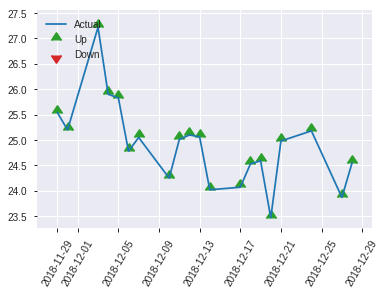


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3873036572630829
RMSE: 0.6223372536359068
LogLoss: 7.776126040487628
Mean Per-Class Error: 0.4152342755283931
AUC: 0.5555449452508276
pr_auc: 0.3004685499350113
Gini: 0.1110898905016553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47459531808657934: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    128  0.9697   (128.0/132.0)
1      0    119  0        (0.0/119.0)
Total  4    247  0.51     (128.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474595     0.650273  136
max f2                       0.474595     0.82296   136
max f0point5                 0.51503      0.5716    67
max accuracy                 0.518403     0.573705  63
max precision                0.999743     0.545455  20
max recall                   0.474595     1         136
max specificity              1            0.613636  0
max absolute_mcc             0.51503      0.186397  67
max min_per_class_accuracy   0.999417     0.568182  24
max mean_per_class_accuracy  0.51503      0.584766  67

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 81.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.390438                    1                  1.05462   1.05462            0.5              1         0.5                         1                   0.411765        0.411765                   5.46218   5.46218
    2        0.40239                     1                  0         1.0233             0                1         0.485149                    1                   0               0.411765                   -100      2.32964
    3        0.501992                    0.998821           1.60303   1.13832            0.76             0.999823  0.539683                    0.999965            0.159664        0.571429                   60.3025   13.8322
    4        0.601594                    0.96991            0.928067  1.10351            0.44             0.991035  0.523179                    0.998486            0.092437        0.663866                   -7.19328  10.3512
    5        0.701195                    0.517148           1.18118   1.11454            0.56             0.651523  0.528409                    0.949202            0.117647        0.781513                   18.1176   11.4544
    6        0.800797                    0.500201           0.590588  1.04937            0.28             0.507234  0.497512                    0.894231            0.0588235       0.840336                   -40.9412  4.9375
    7        0.900398                    0.487614           0.590588  0.998624           0.28             0.493852  0.473451                    0.849941            0.0588235       0.89916                    -40.9412  -0.137577
    8        1                           0.46854            1.01244   1                  0.48             0.480392  0.474104                    0.813133            0.10084         1                          1.2437    0

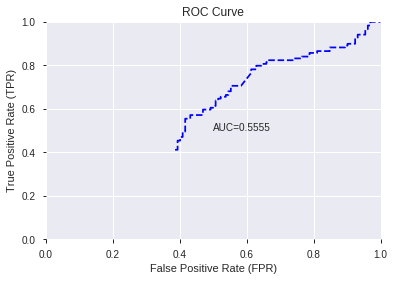

This function is available for GLM models only


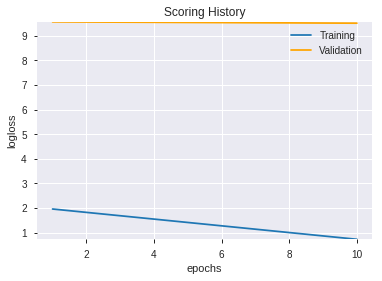

--2019-08-27 21:26:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_205816',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_205816',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_98_sid_b6d1'

['TANH',
 'BETA_30',
 'ATAN',
 'aroonup_30',
 'CEIL',
 'PLUS_DM_14',
 'CDLINNECK',
 'CDLSTICKSANDWICH',
 'PPO',
 'CDLHIKKAKE',
 'BETA_12',
 'MAVP_24_1',
 'BBANDS_lowerband_8_8_5',
 'LN',
 'CDLADVANCEBLOCK',
 'ULTOSC',
 'MACDFIX_signal_24',
 'CCI_24',
 'CDLMARUBOZU',
 'PLUS_DI_20',
 'BBANDS_upperband_12_5_5',
 'BBANDS_middleband_14_5_4',
 'BBANDS_upperband_12_2_3',
 'MOM_12',
 'STOCHRSI_fastd',
 'DX_24',
 'CDLENGULFING',
 'MOM_8',
 'STOCHF_fastk',
 'ROCR_12',
 'BBANDS_upperband_20_2_2',
 'CDLHARAMICROSS',
 'OBV',
 'MA_20_7',
 'BBANDS_upperband_8_8_4',
 'BBANDS_lowerband_14_2_3',
 'BBANDS_lowerband_14_3_2',
 'MA_20_0',
 'MAVP_14_5',
 'BBANDS_middleband_20_6_3',
 'CDLMORNINGDOJISTAR',
 'STOCH_slowd',
 'aroondown_12',
 'COS',
 'BBANDS_lowerband_12_1_4',
 'BBANDS_middleband_20_5_3',
 'EXP',
 'BBANDS_lowerband_14_5_5',
 'CDLSEPARATINGLINES',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_upperband_12_0_5',
 'BBANDS_upperband_12_2_2',
 'MOM_30',
 'BBANDS_lowerband_12_5_4',
 'CDLHARAMI',
 'BBANDS_lowerb

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_212744_model_1  0.500828  4.308125                   0.5  0.587381  0.345016

variable  relative_importance  scaled_importance  percentage
0              CDLEVENINGSTAR             0.009071           1.000000    0.019327
1                        TANH             0.007046           0.776806    0.015013
2          CDLMORNINGDOJISTAR             0.006233           0.687192    0.013282
3                CDLENGULFING             0.005611           0.618579    0.011955
4                         BOP             0.005256           0.579479    0.011200
..                        ...                  ...                ...         ...
785  BBANDS_middleband_14_1_3             0.000000           0.000000    0.000000
786  BBANDS_middleband_14_1_5             0.000000           0.000000    0.000000
787  BBANDS_middleband_20_1_5             0.000000           0.000000    0.000000
788  BBANDS_middleband_24_0_5             0.000000           0.000000    0.000000
789  BBANDS_middleband_30_1_5             0.000000           0.000000    0.000000

[790 rows x 4 columns]

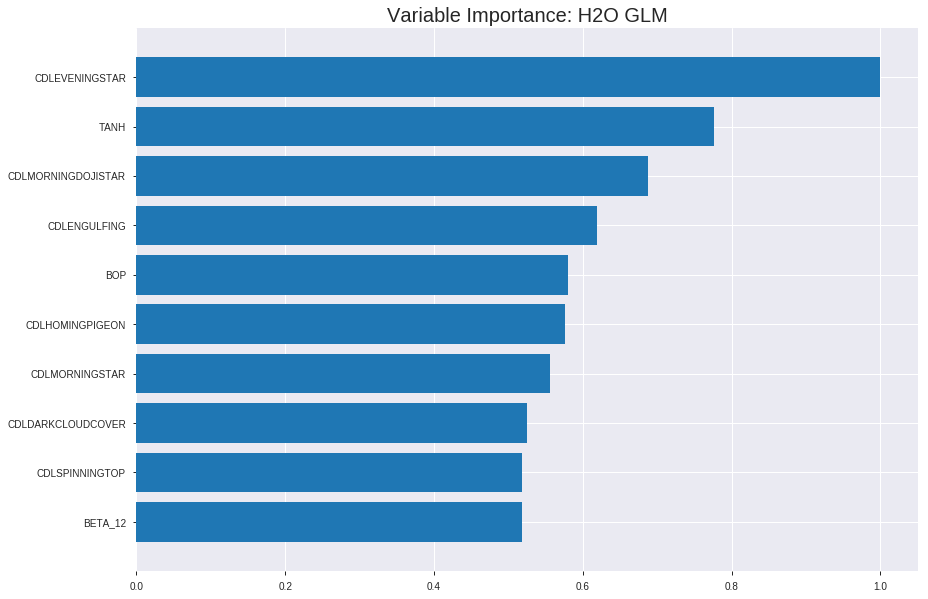

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_212744_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2464743697392316
RMSE: 0.4964618512426021
LogLoss: 0.6860670985953304
Null degrees of freedom: 1752
Residual degrees of freedom: 967
Null deviance: 2422.3593080819073
Residual deviance: 2405.3512476752285
AIC: 3977.3512476752285
AUC: 0.5855673809866245
pr_auc: 0.6069893386490665
Gini: 0.17113476197324906
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4968734206177684: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      32   786   0.9609   (786.0/818.0)
1      10   925   0.0107   (10.0/935.0)
Total  42   1711  0.4541   (796.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496873     0.699169  372
max f2                       0.487468     0.85219   388
max f0point5                 0.525564     0.615345  249
max accuracy                 0.525774     0.586994  248
max precision                0.598774     1         0
max recall                   0.483534     1         393
max specificity              0.598774     1         0
max absolute_mcc             0.525564     0.161138  249
max min_per_class_accuracy   0.533605     0.56357   196
max mean_per_class_accuracy  0.525774     0.573673  248

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.57677            1.77071   1.77071            0.944444         0.583152  0.944444                    0.583152            0.0181818       0.0181818                  77.0707   77.0707
    2        0.0205362                   0.571524           1.24991   1.51031            0.666667         0.573987  0.805556                    0.578569            0.0128342       0.031016                   24.9911   51.0309
    3        0.0302339                   0.565421           1.10286   1.37962            0.588235         0.568087  0.735849                    0.575207            0.0106952       0.0417112                  10.2863   37.9619
    4        0.040502                    0.562067           1.35407   1.37314            0.722222         0.563897  0.732394                    0.57234             0.0139037       0.055615                   35.407    37.3142
    5        0.0501997                   0.559227           1.32344   1.36354            0.705882         0.560423  0.727273                    0.570037            0.0128342       0.0684492                  32.3435   36.3539
    6        0.100399                    0.553523           1.04396   1.20375            0.556818         0.556167  0.642045                    0.563102            0.0524064       0.120856                   4.39596   20.3749
    7        0.150029                    0.549172           1.16371   1.1905             0.62069          0.5512    0.634981                    0.559165            0.057754        0.17861                    16.371    19.0504
    8        0.200228                    0.546353           0.894823  1.11637            0.477273         0.547665  0.595442                    0.556282            0.0449198       0.223529                   -10.5177  11.6373
    9        0.300057                    0.54103            1.09278   1.10852            0.582857         0.543651  0.591255                    0.552079            0.109091        0.33262                    9.27792   10.8524
    10       0.399886                    0.537259           1.22134   1.13669            0.651429         0.539138  0.606277                    0.548849            0.121925        0.454545                   22.1341   13.6688
    11       0.500285                    0.53366            1.06526   1.12235            0.568182         0.535342  0.598632                    0.546138            0.106952        0.561497                   6.52649   12.2354
    12       0.600114                    0.530508           1.00707   1.10318            0.537143         0.532104  0.588403                    0.543804            0.100535        0.662032                   0.707105  10.3177
    13       0.699943                    0.525954           1.04993   1.09558            0.56             0.528255  0.584352                    0.541586            0.104813        0.766845                   4.99251   9.5582
    14       0.799772                    0.520824           0.846368  1.06447            0.451429         0.523321  0.56776                     0.539306            0.084492        0.851337                   -15.3632  6.44747
    15       0.899601                    0.513044           0.782087  1.03314            0.417143         0.517556  0.551046                    0.536892            0.0780749       0.929412                   -21.7913  3.31381
    16       1                           0.455312           0.703075  1                  0.375            0.501821  0.533371                    0.533371          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3976506081765515
RMSE: 0.6305954393876881
LogLoss: 8.978323567817318
Null degrees of freedom: 500
Residual degrees of freedom: -285
Null deviance: 691.823895750088
Residual deviance: 119637.7057448155
AIC: 121209.7057448155
AUC: 0.5333931547237534
pr_auc: 0.5641746159208456
Gini: 0.06678630944750674
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.4929010853496661e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    269  0        (0.0/269.0)
Total  0    501  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.4929e-50   0.698701   294
max f2                       1.4929e-50   0.852885   294
max f0point5                 1.4929e-50   0.591729   294
max accuracy                 6.04879e-24  0.538922   279
max precision                0.554881     0.8        4
max recall                   1.4929e-50   1          294
max specificity              0.558288     0.99569    0
max absolute_mcc             0.520651     0.0818497  101
max min_per_class_accuracy   0.0002523    0.531599   250
max mean_per_class_accuracy  6.04879e-24  0.534763   279

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 22.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.553529           1.24164   1.24164            0.666667         0.555699      0.666667                    0.555699            0.0148699       0.0148699                  24.1636   24.1636
    2        0.0219561                   0.546659           0.744981  1.01588            0.4              0.549902      0.545455                    0.553064            0.00743494      0.0223048                  -25.5019  1.58837
    3        0.0319361                   0.545098           1.11747   1.04763            0.6              0.545721      0.5625                      0.550769            0.0111524       0.0334572                  11.7472   4.76301
    4        0.0419162                   0.540967           0.744981  0.975571           0.4              0.543157      0.52381                     0.548957            0.00743494      0.0408922                  -25.5019  -2.44291
    5        0.0518962                   0.539166           1.86245   1.14613            1                0.53968       0.615385                    0.547173            0.0185874       0.0594796                  86.2454   14.6125
    6        0.101796                    0.531123           0.968476  1.05904            0.52             0.534882      0.568627                    0.541148            0.0483271       0.107807                   -3.15242  5.90422
    7        0.151697                    0.526247           1.19197   1.10277            0.64             0.528248      0.592105                    0.536904            0.0594796       0.167286                   19.197    10.2769
    8        0.201597                    0.520697           1.26647   1.14329            0.68             0.522924      0.613861                    0.533444            0.063197        0.230483                   26.6468   14.3288
    9        0.301397                    0.507637           0.931227  1.07307            0.5              0.515557      0.576159                    0.527521            0.0929368       0.32342                    -6.87732  7.30693
    10       0.401198                    0.423884           1.04297   1.06558            0.56             0.488359      0.572139                    0.517779            0.104089        0.427509                   4.2974    6.55829
    11       0.500998                    0.0002523          1.04297   1.06108            0.56             0.173191      0.569721                    0.449136            0.104089        0.531599                   4.2974    6.10791
    12       0.600798                    4.27581e-60        0.931227  1.03951            0.5              1.22438e-05   0.55814                     0.374531            0.0929368       0.624535                   -6.87732  3.95089
    13       0.700599                    1.89164e-234       1.19197   1.06123            0.64             2.05723e-62   0.569801                    0.321179            0.118959        0.743494                   19.197    6.12271
    14       1                           0                  0.856729  1                  0.46             1.25101e-236  0.536926                    0.225018            0.256506        1                          -14.3271  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:27:46  0.000 sec   2            3.9       786           1.37213           238.798
    2019-08-27 21:27:47  1.361 sec   4            2.8       789           1.36955           255.543
    2019-08-27 21:27:49  2.708 sec   6            2.1       790           1.36649           269.87
    2019-08-27 21:27:50  4.143 sec   8            1.5       790           1.36292           281.356
    2019-08-27 21:27:51  5.484 sec   10           1.1       791           1.35887           291.213

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6432432432432432)

('auc', 0.5008276037687802)

('logloss', 4.308124715256631)

('mean_per_class_error', 0.47924624395212634)

('rmse', 0.5873808791424185)

('mse', 0.34501629718212046)

glm prediction progress: |████████████████████████████████████████████████| 100%


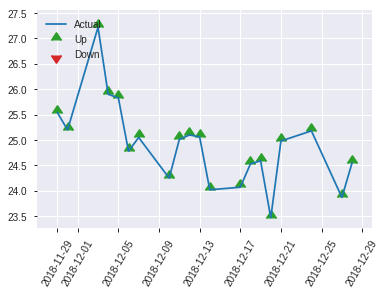


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.34501629718212046
RMSE: 0.5873808791424185
LogLoss: 4.308124715256631
Null degrees of freedom: 250
Residual degrees of freedom: -535
Null deviance: 350.81837939662717
Residual deviance: 21352.856778459212
AIC: 22924.856778459212
AUC: 0.5008276037687802
pr_auc: 0.4867039397543873
Gini: 0.0016552075375604325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.3077428965298365e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    119  0        (0.0/119.0)
Total  0    251  0.5259   (132.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.30774e-51  0.643243  212
max f2                       2.30774e-51  0.818432  212
max f0point5                 2.69779e-29  0.53102   207
max accuracy                 0.559065     0.541833  7
max precision                0.559065     0.75      7
max recall                   2.30774e-51  1         212
max specificity              0.575115     0.992424  0
max absolute_mcc             0.559065     0.100254  7
max min_per_class_accuracy   0.492735     0.470588  122
max mean_per_class_accuracy  0.508856     0.520754  80

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 30.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.568957           1.40616   1.40616            0.666667         0.5726       0.666667                    0.5726              0.0168067       0.0168067                  40.6162   40.6162
    2        0.0239044                   0.56523            1.40616   1.40616            0.666667         0.566784     0.666667                    0.569692            0.0168067       0.0336134                  40.6162   40.6162
    3        0.0318725                   0.557325           2.10924   1.58193            1                0.560934     0.75                        0.567502            0.0168067       0.0504202                  110.924   58.1933
    4        0.0438247                   0.55266            0         1.1505             0                0.554015     0.545455                    0.563824            0               0.0504202                  -100      15.0497
    5        0.0517928                   0.551319           2.10924   1.298              1                0.552069     0.615385                    0.562015            0.0168067       0.0672269                  110.924   29.7996
    6        0.103586                    0.531021           0.811248  1.05462            0.384615         0.541259     0.5                         0.551637            0.0420168       0.109244                   -18.8752  5.46218
    7        0.151394                    0.527467           0.878852  0.999115           0.416667         0.528839     0.473684                    0.544438            0.0420168       0.151261                   -12.1148  -0.0884564
    8        0.203187                    0.518271           1.13575   1.03394            0.538462         0.522062     0.490196                    0.538734            0.0588235       0.210084                   13.5747   3.3943
    9        0.302789                    0.511369           1.01244   1.02687            0.48             0.514817     0.486842                    0.530867            0.10084         0.310924                   1.2437    2.68686
    10       0.40239                     0.504851           1.01244   1.0233             0.48             0.507303     0.485149                    0.525034            0.10084         0.411765                   1.2437    2.32964
    11       0.501992                    0.488829           0.590588  0.937442           0.28             0.497765     0.444444                    0.519624            0.0588235       0.470588                   -40.9412  -6.25584
    12       0.601594                    0.209852           1.09681   0.963827           0.52             0.368127     0.456954                    0.494541            0.109244        0.579832                   9.68067   -3.61734
    13       0.701195                    0.011694           1.26555   1.00668            0.6              0.0664832    0.477273                    0.433738            0.12605         0.705882                   26.5546   0.668449
    14       0.800797                    4.53097e-13        0.928067  0.996906           0.44             0.00247448   0.472637                    0.380098            0.092437        0.798319                   -7.19328  -0.309377
    15       1                           0                  1.01244   1                  0.48             5.42338e-16  0.474104                    0.304381            0.201681        1                          1.2437    0

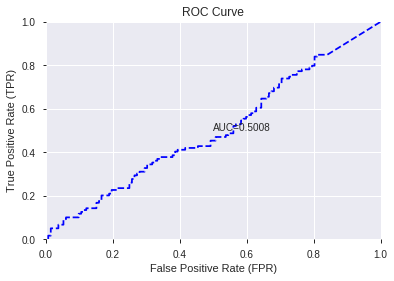

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


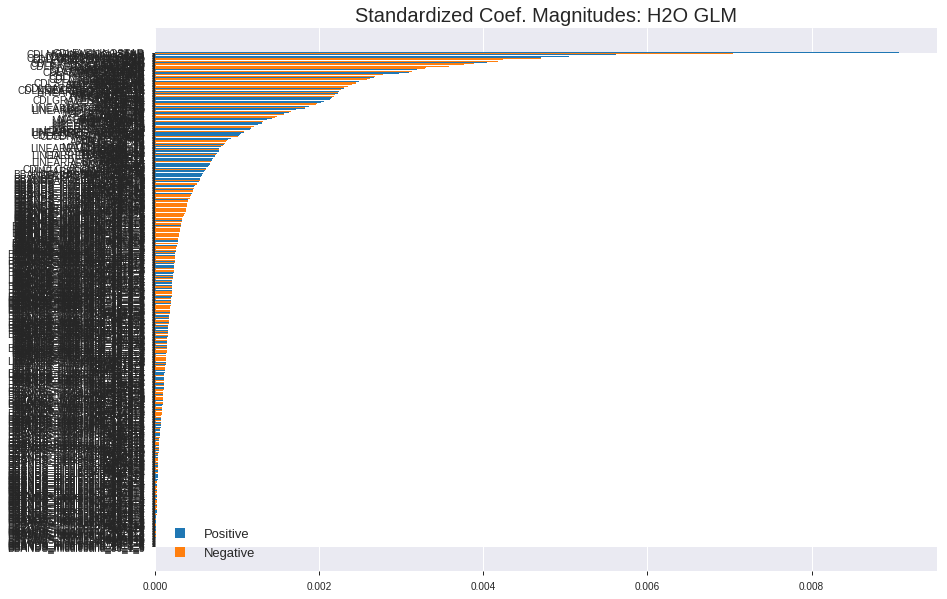

'log_likelihood'
--2019-08-27 21:28:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_212744_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_212744_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLEVENINGSTAR',
 'TANH',
 'CDLMORNINGDOJISTAR',
 'CDLENGULFING',
 'BOP',
 'CDLHOMINGPIGEON',
 'CDLMORNINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLSPINNINGTOP',
 'BETA_12',
 'CDLLONGLEGGEDDOJI',
 'CDL3LINESTRIKE',
 'EXP',
 'COSH',
 'SINH',
 'CDLEVENINGDOJISTAR',
 'CDLDOJI',
 'BETA_30',
 'STOCHRSI_fastk',
 'CDLINNECK',
 'CDLINVERTEDHAMMER',
 'OBV',
 'CDLTASUKIGAP',
 'CDLHARAMICROSS',
 'BETA_14',
 'CDLONNECK',
 'STOCH_slowd',
 'VAR_12',
 'CDLHIGHWAVE',
 'CDLUNIQUE3RIVER',
 'CDLADVANCEBLOCK',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'CDL2CROWS',
 'ATAN',
 'BETA_8',
 'CDLRICKSHAWMAN',
 'STDDEV_8',
 'aroonup_12',
 'COS',
 'CORREL_20',
 'aroondown_30',
 'CDLMATCHINGLOW',
 'aroonup_8',
 'CDLDOJISTAR',
 'aroonup_24',
 'VAR_14',
 'CDLSTALLEDPATTERN',
 'CORREL_30',
 'MACDFIX_hist_8',
 'STOCHRSI_fastd',
 'AROONOSC_14',
 'aroonup_20',
 'MACD_hist',
 'TRANGE',
 'DX_14',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_14',
 'LINEARREG_SLOPE_8',
 'CDLXSIDEGAP3METHODS',
 'CORREL_14',
 'LINEARREG_ANGLE_8',
 'AROONOSC_30',
 'DX

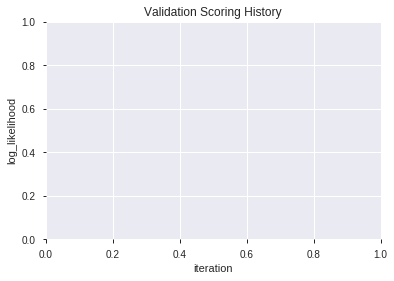

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_212915_model_6  0.542335  0.697452              0.500000  0.501966  0.251970
1  XGBoost_grid_1_AutoML_20190827_212915_model_5  0.495289  0.728971              0.496212  0.516208  0.266470
2  XGBoost_grid_1_AutoML_20190827_212915_model_4  0.493061  0.710442              0.500000  0.508244  0.258312
3  XGBoost_grid_1_AutoML_20190827_212915_model_1  0.472052  0.731071              0.496212  0.517611  0.267921
4               XGBoost_3_AutoML_20190827_212915  0.470270  0.711870              0.477687  0.508998  0.259079
5               XGBoost_2_AutoML_20190827_212915  0.468742  0.711580              0.500000  0.508746  0.258822
6  XGBoost_grid_1_AutoML_20190827_212915_model_7  0.465304  0.735398              0.500000  0.519292  0.269665
7               XGBoost_1_AutoML_20190827_212915  0.460466  0.724637              0.492424  0.514932  0.265155
8  XGBoost_grid_1_AutoML_20190827_212915_model_3  0.446651  0.726089              0.500000  0.515577  0.265820
9  XGBoost_grid_1_AutoML_20190827_212915_model_2  0.441495  0.710097              0.500000  0.508303  0.258372

variable  relative_importance  scaled_importance  percentage
0                        BOP           175.521271           1.000000    0.028171
1               MACDEXT_hist           131.701797           0.750347    0.021138
2                        TAN           119.914474           0.683191    0.019246
3                     ULTOSC           104.287949           0.594161    0.016738
4                    BETA_30            98.502281           0.561199    0.015810
..                       ...                  ...                ...         ...
249                   CMO_24             3.194095           0.018198    0.000513
250  BBANDS_upperband_30_0_3             3.178151           0.018107    0.000510
251              MINUS_DI_20             2.953420           0.016827    0.000474
252  BBANDS_upperband_24_7_4             2.430221           0.013846    0.000390
253   BBANDS_upperband_8_7_3             1.736652           0.009894    0.000279

[254 rows x 4 columns]

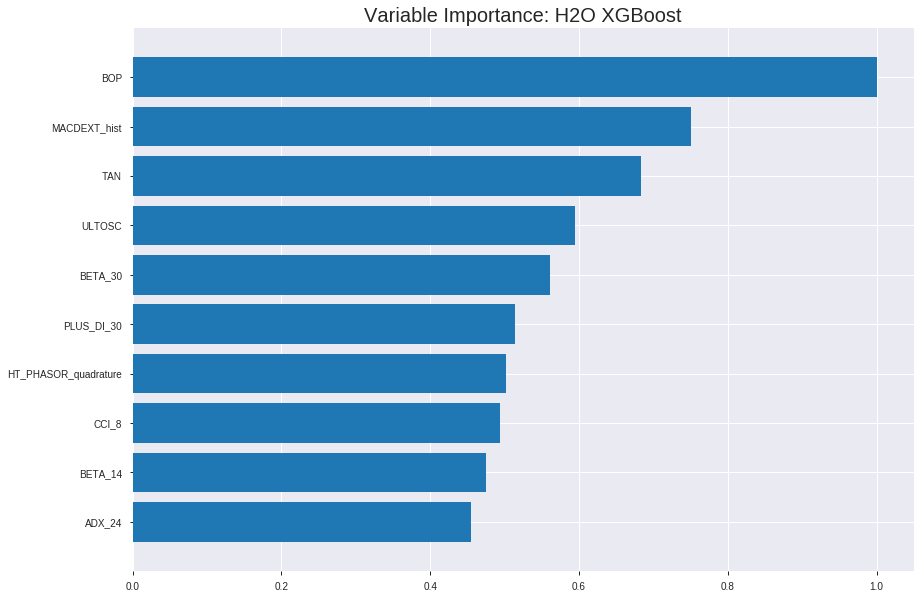

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_212915_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18840028235631764
RMSE: 0.4340510135414012
LogLoss: 0.5667164434648413
Mean Per-Class Error: 0.13644927630976822
AUC: 0.9318835558228625
pr_auc: 0.9383981882212605
Gini: 0.8637671116457251
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5152511447668076: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      683  135  0.165    (135.0/818.0)
1      106  829  0.1134   (106.0/935.0)
Total  789  964  0.1375   (241.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.515251     0.873091  220
max f2                       0.47091      0.909821  269
max f0point5                 0.544905     0.881122  185
max accuracy                 0.528102     0.862521  206
max precision                0.800547     1         0
max recall                   0.369919     1         357
max specificity              0.800547     1         0
max absolute_mcc             0.528102     0.725594  206
max min_per_class_accuracy   0.523533     0.859413  211
max mean_per_class_accuracy  0.528102     0.863551  206

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.753376           1.87487    1.87487            1                0.777353  1                           0.777353            0.0192513       0.0192513                  87.4866   87.4866
    2        0.0205362                   0.729573           1.87487    1.87487            1                0.738865  1                           0.758109            0.0192513       0.0385027                  87.4866   87.4866
    3        0.0302339                   0.711565           1.87487    1.87487            1                0.718629  1                           0.745445            0.0181818       0.0566845                  87.4866   87.4866
    4        0.040502                    0.697537           1.87487    1.87487            1                0.704693  1                           0.735114            0.0192513       0.0759358                  87.4866   87.4866
    5        0.0501997                   0.686401           1.87487    1.87487            1                0.690997  1                           0.726591            0.0181818       0.0941176                  87.4866   87.4866
    6        0.100399                    0.649521           1.83226    1.85356            0.977273         0.665568  0.988636                    0.69608             0.0919786       0.186096                   83.2256   85.3561
    7        0.150029                    0.630669           1.81022    1.83922            0.965517         0.639397  0.980989                    0.677329            0.0898396       0.275936                   81.0216   83.9222
    8        0.200228                    0.616983           1.85356    1.84282            0.988636         0.623519  0.982906                    0.663838            0.0930481       0.368984                   85.3561   84.2817
    9        0.300057                    0.586309           1.73559    1.80714            0.925714         0.60075   0.963878                    0.642849            0.173262        0.542246                   73.5591   80.7143
    10       0.399886                    0.558183           1.54275    1.74114            0.822857         0.571752  0.928673                    0.6251              0.154011        0.696257                   54.2747   74.1138
    11       0.500285                    0.529962           1.37419    1.6675             0.732955         0.54405   0.889396                    0.608834            0.137968        0.834225                   37.4192   66.7498
    12       0.600114                    0.501923           0.867795   1.53447            0.462857         0.515807  0.818441                    0.593359            0.086631        0.920856                   -13.2205  53.4468
    13       0.699943                    0.471869           0.439254   1.37826            0.234286         0.486313  0.735126                    0.578092            0.0438503       0.964706                   -56.0746  37.8264
    14       0.799772                    0.44013            0.235697   1.23565            0.125714         0.456852  0.659058                    0.562959            0.0235294       0.988235                   -76.4303  23.5647
    15       0.899601                    0.401369           0.0749947  1.10685            0.04             0.422995  0.590361                    0.547427            0.00748663      0.995722                   -92.5005  10.6849
    16       1                           0.234943           0.0426106  1                  0.0227273        0.360949  0.533371                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2598917588248019
RMSE: 0.5097958011055034
LogLoss: 0.7138437531964066
Mean Per-Class Error: 0.4899692347134983
AUC: 0.4863879630816562
pr_auc: 0.5183016397904268
Gini: -0.027224073836687568
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32686851918697357: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    226  0.9741   (226.0/232.0)
1      2    267  0.0074   (2.0/269.0)
Total  8    493  0.4551   (228.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.326869     0.700787   391
max f2                       0.273013     0.852885   399
max f0point5                 0.326869     0.595716   391
max accuracy                 0.329364     0.54491    390
max precision                0.635316     0.565217   22
max recall                   0.273013     1          399
max specificity              0.763528     0.99569    0
max absolute_mcc             0.730048     0.0966015  3
max min_per_class_accuracy   0.489648     0.482759   201
max mean_per_class_accuracy  0.455727     0.510031   259

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 49.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.713364           0.620818  0.620818           0.333333         0.734452  0.333333                    0.734452            0.00743494      0.00743494                 -37.9182  -37.9182
    2        0.0219561                   0.673486           0.744981  0.677256           0.4              0.693143  0.363636                    0.715675            0.00743494      0.0148699                  -25.5019  -32.2744
    3        0.0319361                   0.662414           1.48996   0.931227           0.8              0.667604  0.5                         0.700653            0.0148699       0.0297398                  48.9963   -6.87732
    4        0.0419162                   0.640098           1.11747   0.975571           0.6              0.650691  0.52381                     0.688757            0.0111524       0.0408922                  11.7472   -2.44291
    5        0.0518962                   0.630492           0.744981  0.931227           0.4              0.632586  0.5                         0.677955            0.00743494      0.0483271                  -25.5019  -6.87732
    6        0.101796                    0.602468           0.744981  0.83993            0.4              0.614803  0.45098                     0.646998            0.0371747       0.0855019                  -25.5019  -16.007
    7        0.151697                    0.570103           1.19197   0.955733           0.64             0.584191  0.513158                    0.626338            0.0594796       0.144981                   19.197    -4.42673
    8        0.201597                    0.556628           0.893978  0.940447           0.48             0.563501  0.50495                     0.610784            0.0446097       0.189591                   -10.6022  -5.95532
    9        0.301397                    0.528558           1.00572   0.962062           0.54             0.541125  0.516556                    0.587718            0.100372        0.289963                   0.572491  -3.79379
    10       0.401198                    0.507006           1.04297   0.982189           0.56             0.517487  0.527363                    0.570248            0.104089        0.394052                   4.2974    -1.78106
    11       0.500998                    0.489518           0.893978  0.964617           0.48             0.497774  0.517928                    0.555811            0.0892193       0.483271                   -10.6022  -3.53826
    12       0.600798                    0.468584           1.19197   1.00238            0.64             0.478221  0.538206                    0.542922            0.118959        0.60223                    19.197    0.238363
    13       0.700599                    0.445825           0.968476  0.997553           0.52             0.455718  0.535613                    0.5305              0.0966543       0.698885                   -3.15242  -0.244654
    14       0.800399                    0.420196           0.931227  0.989283           0.5              0.431936  0.531172                    0.51821             0.0929368       0.791822                   -6.87732  -1.07167
    15       0.9002                      0.390283           1.00572   0.991106           0.54             0.407493  0.532151                    0.505936            0.100372        0.892193                   0.572491  -0.889391
    16       1                           0.273013           1.08022   1                  0.58             0.357872  0.536926                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:29:54  23.812 sec  0                  0.5              0.693147            0.5             0                  1                0.466629                         0.5                0.693147              0.5               0                    1                  0.463074
    2019-08-27 21:29:55  24.745 sec  5                  0.490354         0.674008            0.766689        0.781878           1.77071          0.301198                         0.500307           0.693761              0.477727          0.512968             1.24164            0.461078
    2019-08-27 21:29:55  24.966 sec  10                 0.481768         0.657174            0.819151        0.834583           1.87487          0.257273                         0.501006           0.695179              0.484473          0.51188              0.931227           0.461078
    2019-08-27 21:29:56  25.173 sec  15                 0.47521          0.644374            0.846277        0.858519           1.87487          0.221335                         0.501765           0.696703              0.478969          0.515276             1.24164            0.457086
    2019-08-27 21:29:56  25.383 sec  20                 0.468047         0.630593            0.86721         0.880803           1.87487          0.205933                         0.503141           0.699541              0.483095          0.509999             0.310409           0.457086
    2019-08-27 21:29:56  25.607 sec  25                 0.46012          0.615476            0.891512        0.902223           1.87487          0.193383                         0.503402           0.700189              0.494704          0.518019             0.310409           0.463074
    2019-08-27 21:29:56  25.809 sec  30                 0.454616         0.605005            0.898657        0.908194           1.87487          0.17684                          0.505463           0.704486              0.482142          0.511875             0.310409           0.463074
    2019-08-27 21:29:56  26.014 sec  35                 0.449133         0.594737            0.909292        0.919306           1.87487          0.162578                         0.506987           0.707579              0.475708          0.509253             0.620818           0.463074
    2019-08-27 21:29:57  26.229 sec  40                 0.443939         0.585               0.918091        0.925575           1.87487          0.150029                         0.507012           0.70771               0.480611          0.510207             0.620818           0.457086
    2019-08-27 21:29:57  26.437 sec  45                 0.439978         0.577624            0.924596        0.931823           1.87487          0.15231                          0.507312           0.708415              0.483512          0.514623             0.620818           0.453094
    2019-08-27 21:29:57  26.664 sec  50                 0.434051         0.566716            0.931884        0.938398           1.87487          0.137479                         0.509796           0.713844              0.486388          0.518302             0.620818           0.45509

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      175.52127075195312     1.0                   0.02817114646455512
MACDEXT_hist             131.70179748535156     0.7503466498454919    0.02113812537198561
TAN                      119.91447448730469     0.6831905556151537    0.019246261205435287
ULTOSC                   104.28794860839844     0.5941613125384575    0.0167382053590932
BETA_30                  98.50228118896484      0.5611985417321208    0.015809606314830325
---                      ---                    ---                   ---
CMO_24                   3.1940948963165283     0.018197765334267816  0.0005126519125592626
BBANDS_upperband_30_0_3  3.1781511306762695     0.01810692867628355   0.0005100929397628372
MINUS_DI_20              2.9534201622009277     0.016826565518516013  0.0004740236417175475
BBANDS_upperband_24_7_4  2.4302213191986084     0.013845736808919302  0.00039005027955374774
BBANDS_upperband_8_7_3   1.7366516590118408     0.00989425185660876   0.0002787324182097218


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6432432432432432)

('auc', 0.5423351158645277)

('logloss', 0.697452289783527)

('mean_per_class_error', 0.45263559969442324)

('rmse', 0.5019660982359285)

('mse', 0.25196996377820186)

xgboost prediction progress: |████████████████████████████████████████████| 100%


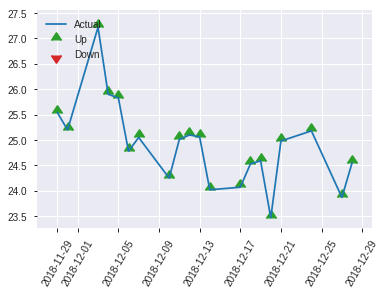


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25196996377820186
RMSE: 0.5019660982359285
LogLoss: 0.697452289783527
Mean Per-Class Error: 0.45263559969442324
AUC: 0.5423351158645277
pr_auc: 0.5039286563607895
Gini: 0.0846702317290553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3307540714740753: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    119  0        (0.0/119.0)
Total  0    251  0.5259   (132.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330754     0.643243  250
max f2                       0.330754     0.818432  250
max f0point5                 0.434461     0.542047  216
max accuracy                 0.606398     0.557769  37
max precision                0.606398     0.605263  37
max recall                   0.330754     1         250
max specificity              0.713116     0.992424  0
max absolute_mcc             0.606398     0.110947  37
max min_per_class_accuracy   0.513488     0.537879  125
max mean_per_class_accuracy  0.480072     0.547364  170

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 52.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.697971           0.703081  0.703081           0.333333         0.704878  0.333333                    0.704878            0.00840336      0.00840336                 -29.6919  -29.6919
    2        0.0239044                   0.681315           1.40616   1.05462            0.666667         0.688705  0.5                         0.696791            0.0168067       0.0252101                  40.6162   5.46218
    3        0.0318725                   0.66334            1.05462   1.05462            0.5              0.670523  0.5                         0.690224            0.00840336      0.0336134                  5.46218   5.46218
    4        0.0438247                   0.658469           0.703081  0.958747           0.333333         0.660494  0.454545                    0.682116            0.00840336      0.0420168                  -29.6919  -4.12529
    5        0.0517928                   0.651548           2.10924   1.13575            1                0.652473  0.538462                    0.677556            0.0168067       0.0588235                  110.924   13.5747
    6        0.103586                    0.623515           1.13575   1.13575            0.538462         0.639596  0.538462                    0.658576            0.0588235       0.117647                   13.5747   13.5747
    7        0.151394                    0.605217           1.58193   1.27665            0.75             0.61557   0.605263                    0.644995            0.0756303       0.193277                   58.1933   27.6648
    8        0.203187                    0.588134           0.811248  1.15802            0.384615         0.596574  0.54902                     0.632652            0.0420168       0.235294                   -18.8752  15.8016
    9        0.302789                    0.557099           1.01244   1.11013            0.48             0.576826  0.526316                    0.614288            0.10084         0.336134                   1.2437    11.0128
    10       0.40239                     0.536595           0.759328  1.0233             0.36             0.54532   0.485149                    0.597217            0.0756303       0.411765                   -24.0672  2.32964
    11       0.501992                    0.513488           1.34992   1.0881             0.64             0.525429  0.515873                    0.582973            0.134454        0.546218                   34.9916   8.81019
    12       0.601594                    0.498417           0.674958  1.0197             0.32             0.504683  0.483444                    0.570011            0.0672269       0.613445                   -32.5042  1.97006
    13       0.701195                    0.476171           1.26555   1.05462            0.6              0.486452  0.5                         0.558142            0.12605         0.739496                   26.5546   5.46218
    14       0.800797                    0.450339           0.928067  1.03888            0.44             0.464147  0.492537                    0.546451            0.092437        0.831933                   -7.19328  3.88812
    15       0.900398                    0.421398           0.759328  1.00796            0.36             0.437071  0.477876                    0.534352            0.0756303       0.907563                   -24.0672  0.795717
    16       1                           0.330754           0.928067  1                  0.44             0.390032  0.474104                    0.519977      

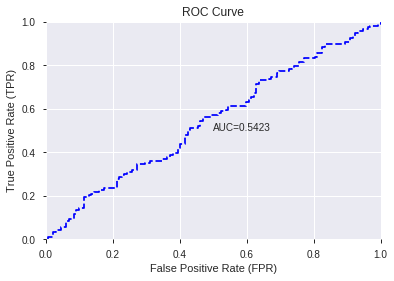

This function is available for GLM models only


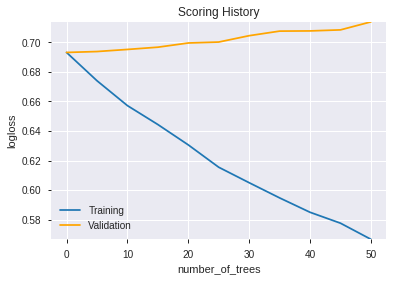

--2019-08-27 21:30:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_212915_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_212915_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b6d1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'MACDEXT_hist',
 'TAN',
 'ULTOSC',
 'BETA_30',
 'PLUS_DI_30',
 'HT_PHASOR_quadrature',
 'CCI_8',
 'BETA_14',
 'ADX_24',
 'ADOSC',
 'STOCH_slowd',
 'MOM_20',
 'ADXR_12',
 'MACDEXT_signal',
 'LINEARREG_ANGLE_8',
 'CORREL_12',
 'CORREL_14',
 'HT_DCPERIOD',
 'SIN',
 'TRANGE',
 'APO',
 'DIV',
 'BETA_8',
 'NATR_24',
 'HT_PHASOR_inphase',
 'WILLR_12',
 'DX_8',
 'CORREL_8',
 'CORREL_30',
 'NATR_8',
 'STOCHF_fastk',
 'ROC_8',
 'BETA_12',
 'STOCH_slowk',
 'MFI_12',
 'AD',
 'WILLR_30',
 'ROC_30',
 'CORREL_24',
 'AROONOSC_24',
 'MFI_20',
 'MFI_24',
 'CORREL_20',
 'PLUS_DI_12',
 'COS',
 'aroonup_14',
 'ADXR_8',
 'OBV',
 'DX_30',
 'PLUS_DI_20',
 'BETA_24',
 'STOCHRSI_fastd',
 'MFI_8',
 'MFI_30',
 'PLUS_DI_24',
 'MACDFIX_hist_8',
 'WILLR_14',
 'MOM_14',
 'CCI_14',
 'STOCHRSI_fastk',
 'BBANDS_lowerband_20_1_3',
 'ADX_8',
 'MOM_24',
 'MACDFIX_hist_24',
 'ADX_20',
 'PLUS_DM_24',
 'BBANDS_lowerband_14_7_4',
 'MFI_14',
 'MINUS_DM_30',
 'CMO_20',
 'PLUS_DM_30',
 'PLUS_DI_14',
 'WILLR_8',
 'ADX_14'

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.598
GLM             0.562
XGBoost         0.566
dtype: float64

DeepLearning    GLM  XGBoost
All          0.598  0.542    0.558
DLF          0.590  0.562    0.566
Fwe          0.582  0.542    0.558
RFE          0.574  0.542    0.558
XGBF         0.558  0.562    0.566





F1


DeepLearning    0.652
GLM             0.643
XGBoost         0.655
dtype: float64

DeepLearning    GLM  XGBoost
All          0.643  0.643    0.645
DLF          0.652  0.643    0.655
Fwe          0.643  0.643    0.645
RFE          0.650  0.643    0.643
XGBF         0.647  0.643    0.655





auc


DeepLearning    0.581
GLM             0.530
XGBoost         0.570
dtype: float64

DeepLearning    GLM  XGBoost
All          0.557  0.502    0.509
DLF          0.581  0.530    0.570
Fwe          0.560  0.502    0.509
RFE          0.556  0.501    0.542
XGBF         0.545  0.530    0.570





logloss


DeepLearning    7.971
GLM             4.308
XGBoost         0.719
dtype: float64

DeepLearning    GLM  XGBoost
All          4.569  4.307    0.719
DLF          0.875  0.696    0.687
Fwe          7.971  4.307    0.719
RFE          7.776  4.308    0.697
XGBF         0.704  0.696    0.687





mean_per_class_error


DeepLearning    0.452
GLM             0.479
XGBoost         0.459
dtype: float64

DeepLearning    GLM  XGBoost
All          0.416  0.468    0.459
DLF          0.411  0.431    0.432
Fwe          0.413  0.468    0.459
RFE          0.415  0.479    0.453
XGBF         0.452  0.431    0.432





rmse


DeepLearning    0.655
GLM             0.587
XGBoost         0.512
dtype: float64

DeepLearning    GLM  XGBoost
All          0.655  0.587    0.512
DLF          0.571  0.501    0.497
Fwe          0.629  0.587    0.512
RFE          0.622  0.587    0.502
XGBF         0.505  0.501    0.497





mse


DeepLearning    0.429
GLM             0.345
XGBoost         0.262
dtype: float64

DeepLearning    GLM  XGBoost
All          0.429  0.345    0.262
DLF          0.327  0.251    0.247
Fwe          0.395  0.345    0.262
RFE          0.387  0.345    0.252
XGBF         0.255  0.251    0.247

{'F1':       DeepLearning    GLM  XGBoost
 All          0.643    NaN      NaN
 DLF          0.652    NaN      NaN
 DLF            NaN  0.643      NaN
 DLF            NaN    NaN    0.655
 All            NaN  0.643      NaN
 All            NaN    NaN    0.645
 XGBF         0.647    NaN      NaN
 XGBF           NaN  0.643      NaN
 XGBF           NaN    NaN    0.655
 Fwe          0.643    NaN      NaN
 Fwe            NaN  0.643      NaN
 Fwe            NaN    NaN    0.645
 RFE          0.650    NaN      NaN
 RFE            NaN  0.643      NaN
 RFE            NaN    NaN    0.643,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.598    NaN      NaN
 DLF          0.590    NaN      NaN
 DLF            NaN  0.562      NaN
 DLF            NaN    NaN    0.566
 All            NaN  0.542      NaN
 All            NaN    NaN    0.558
 XGBF         0.558    NaN      NaN
 XGBF           NaN  0.562      NaN
 XGBF           NaN    NaN    0.566
 Fwe          0.582    NaN      NaN
 Fwe     